In [1]:
import influxdb_client
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pytz
import os
import csv

In [2]:
def find_daytime(arr):
    #find start of day
    for i, element in enumerate(arr):
        if element > 0.1:
            start = i
            break
    #find end of day
    for i, element in enumerate(arr[::-1]):
        if element >= 0.1:
            end = len(arr)-i
            break
    return start, end

array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0,1,2,3,4,5,6,7,8,9,10,11,12,13,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
start, end = find_daytime(array)
print(array[start:end])

[0.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 14]


In [3]:
def lux_to_wm2(lux_array):
    """
    Umrechnung von Lux zu W/m² für Sonnenlicht.
    1 W/m² ≈ 125 Lux (für Sonnenlicht, grobe Faustformel) https://www.landwirtschaftskammer.de/gartenbau/beratung/technik/artikel/lichtwerte-umrechnen.htm
    """
    return np.array(lux_array) / 125


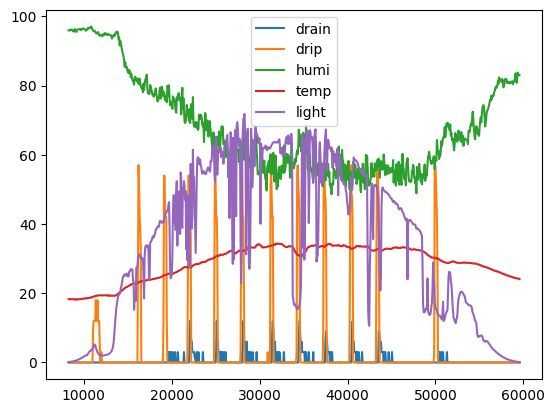

In [4]:
def get_data(nodeId, start, stop):
  #set influxDB access
  token = "tpvr6ve_kbZqMH1YypOEY17Bkz6dF7ccxd_pycGUmOsPowCMHTQvNzPKBhdoPFKddZY4yJgEdt49Bu4Lo-5NmA=="
  org = "home"
  url = "http://192.168.8.15:8086"
  client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
  query_api = client.query_api()

  #set timezone
  local_tz = pytz.timezone('Europe/Berlin')
  start = local_tz.localize(start)
  stop = local_tz.localize(stop)

  #create queries
  labels = {
      "drain":  {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")'},
      "drip":   {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")'},
      "humi":   {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "humidity")'},
      "temp":   {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "temperature")'},
      "light":  {"query": '|> filter(fn: (r) => r["_measurement"] == "2CF7F1C0449000CD")|> filter(fn: (r) => r["_field"] == "light_intensity")'},
  }

  for label in labels:
    genericFluxQuery = 'from(bucket: "SensorNodes")|> range(start: startTime, stop: stopTime)' + labels[label]["query"]
    genericFluxQuery = genericFluxQuery.replace("startTime",start.isoformat())  #replace start time
    genericFluxQuery = genericFluxQuery.replace("stopTime",stop.isoformat())    #replace stop time
    genericFluxQuery = genericFluxQuery.replace("nodeID", nodeId)               #replace nodID

    tables = query_api.query(genericFluxQuery, org=org)
    x_time = []
    y_value = []

    for table in tables:
      for record in table.records:
        time = record["_time"] - start
        x_time.append(time.total_seconds())
        y_value.append(record["_value"])

    #interpolate if it not fits the drain measurment
    if label != "drain":
      labels[label]["value"] = np.interp(labels["drain"]["time"],x_time,y_value)
      labels[label]["time"] = labels["drain"]["time"]
    else:
      labels[label]["value"] = y_value
      labels[label]["time"] = x_time

    #scale data
    if label == "light":
      labels[label]["value"] = np.array(labels[label]["value"]) / 1800
    elif label == "drip" or label == "drain":
      labels[label]["value"] = np.array(labels[label]["value"]) * 300

  #cut labeled data to daytime
  start, stop = find_daytime(labels["light"]["value"])
  for label in labels:
    labels[label]["value"] = labels[label]["value"][start:stop]
    labels[label]["time"] = labels[label]["time"][start:stop]
  return labels

#Test
labels = get_data("70B3D57ED005C6D0", datetime(2023, 8, 23, 4), datetime(2023, 8, 23, 23))
for label in labels:
  plt.plot(labels[label]["time"],labels[label]["value"],label=label)
plt.legend()
plt.show()

Original data length: 801
Downsampled data length: 80


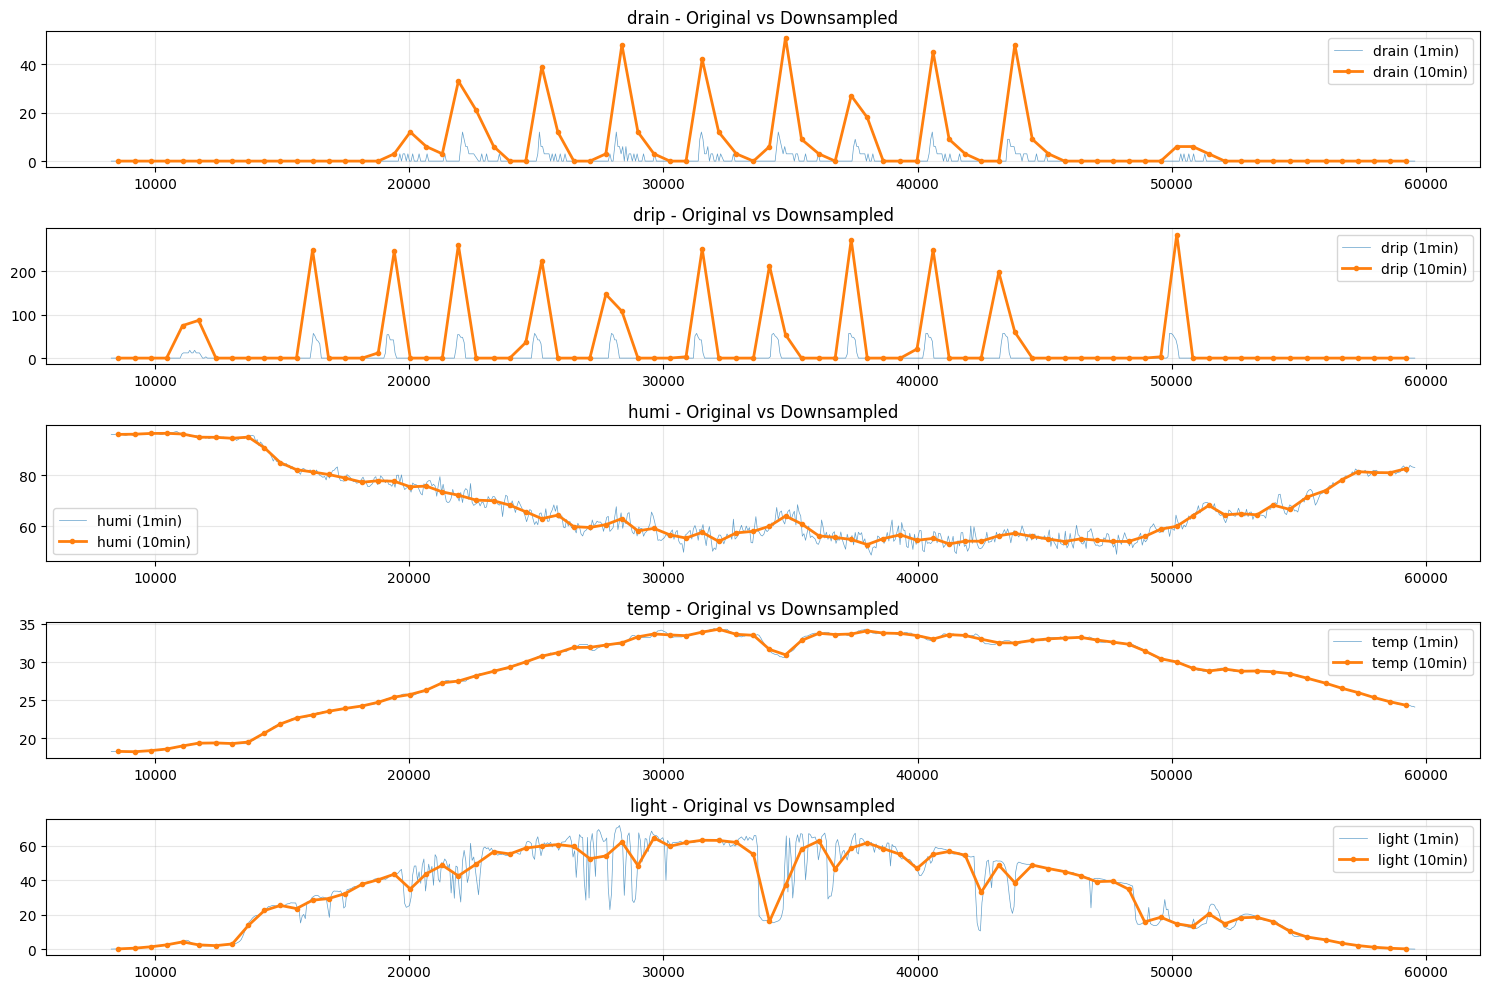

In [5]:
def downsample_labeled_data(labeledData, factor=10):
    """
    Downsample labeledData from 1min to factor*1min intervals
    
    Args:
        labeledData: Dictionary with sensor data
        factor: Downsampling factor (default=10 for 10min intervals)
    
    Returns:
        Downsampled labeledData dictionary
    """
    downsampled_data = {}
    
    for label in labeledData:
        values = np.array(labeledData[label]["value"])
        times = np.array(labeledData[label]["time"])
        
        # Calculate number of complete intervals
        n_intervals = len(values) // factor
        
        if n_intervals == 0:
            # If data is shorter than one interval, keep original
            downsampled_data[label] = {
                "value": values,
                "time": times
            }
            continue
            
        # Reshape and aggregate data
        reshaped_values = values[:n_intervals * factor].reshape(n_intervals, factor)
        reshaped_times = times[:n_intervals * factor].reshape(n_intervals, factor)
        
        if label in ["drip", "drain"]:
            # Sum for volume measurements (total volume in interval)
            aggregated_values = np.sum(reshaped_values, axis=1)
        else:
            # Mean for other measurements (temperature, humidity, light)
            aggregated_values = np.mean(reshaped_values, axis=1)
        
        # Use the middle time point of each interval
        aggregated_times = np.mean(reshaped_times, axis=1)
        
        downsampled_data[label] = {
            "value": aggregated_values,
            "time": aggregated_times
        }
    
    return downsampled_data

# Test the downsampling
test_data = get_data("70B3D57ED005C6D0", datetime(2023, 8, 23, 4), datetime(2023, 8, 23, 23))
print(f"Original data length: {len(test_data['drip']['value'])}")

downsampled_test = downsample_labeled_data(test_data, factor=10)
print(f"Downsampled data length: {len(downsampled_test['drip']['value'])}")

# Plot comparison
plt.figure(figsize=(15, 10))

for i, label in enumerate(test_data.keys()):
    plt.subplot(len(test_data), 1, i+1)
    
    # Original data
    plt.plot(test_data[label]["time"], test_data[label]["value"], 
             label=f'{label} (1min)', alpha=0.7, linewidth=0.5)
    
    # Downsampled data
    plt.plot(downsampled_test[label]["time"], downsampled_test[label]["value"], 
             label=f'{label} (10min)', linewidth=2, marker='o', markersize=3)
    
    plt.title(f'{label} - Original vs Downsampled')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[(0, 13, 26), (13, 18, 22), (18, 24, 29), (24, 29, 33), (29, 37, 43), (37, 44, 48), (44, 49, 53), (49, 52, 53), (52, 59, 65), (59, 66, 72), (66, 71, 75), (71, 91, 91)]


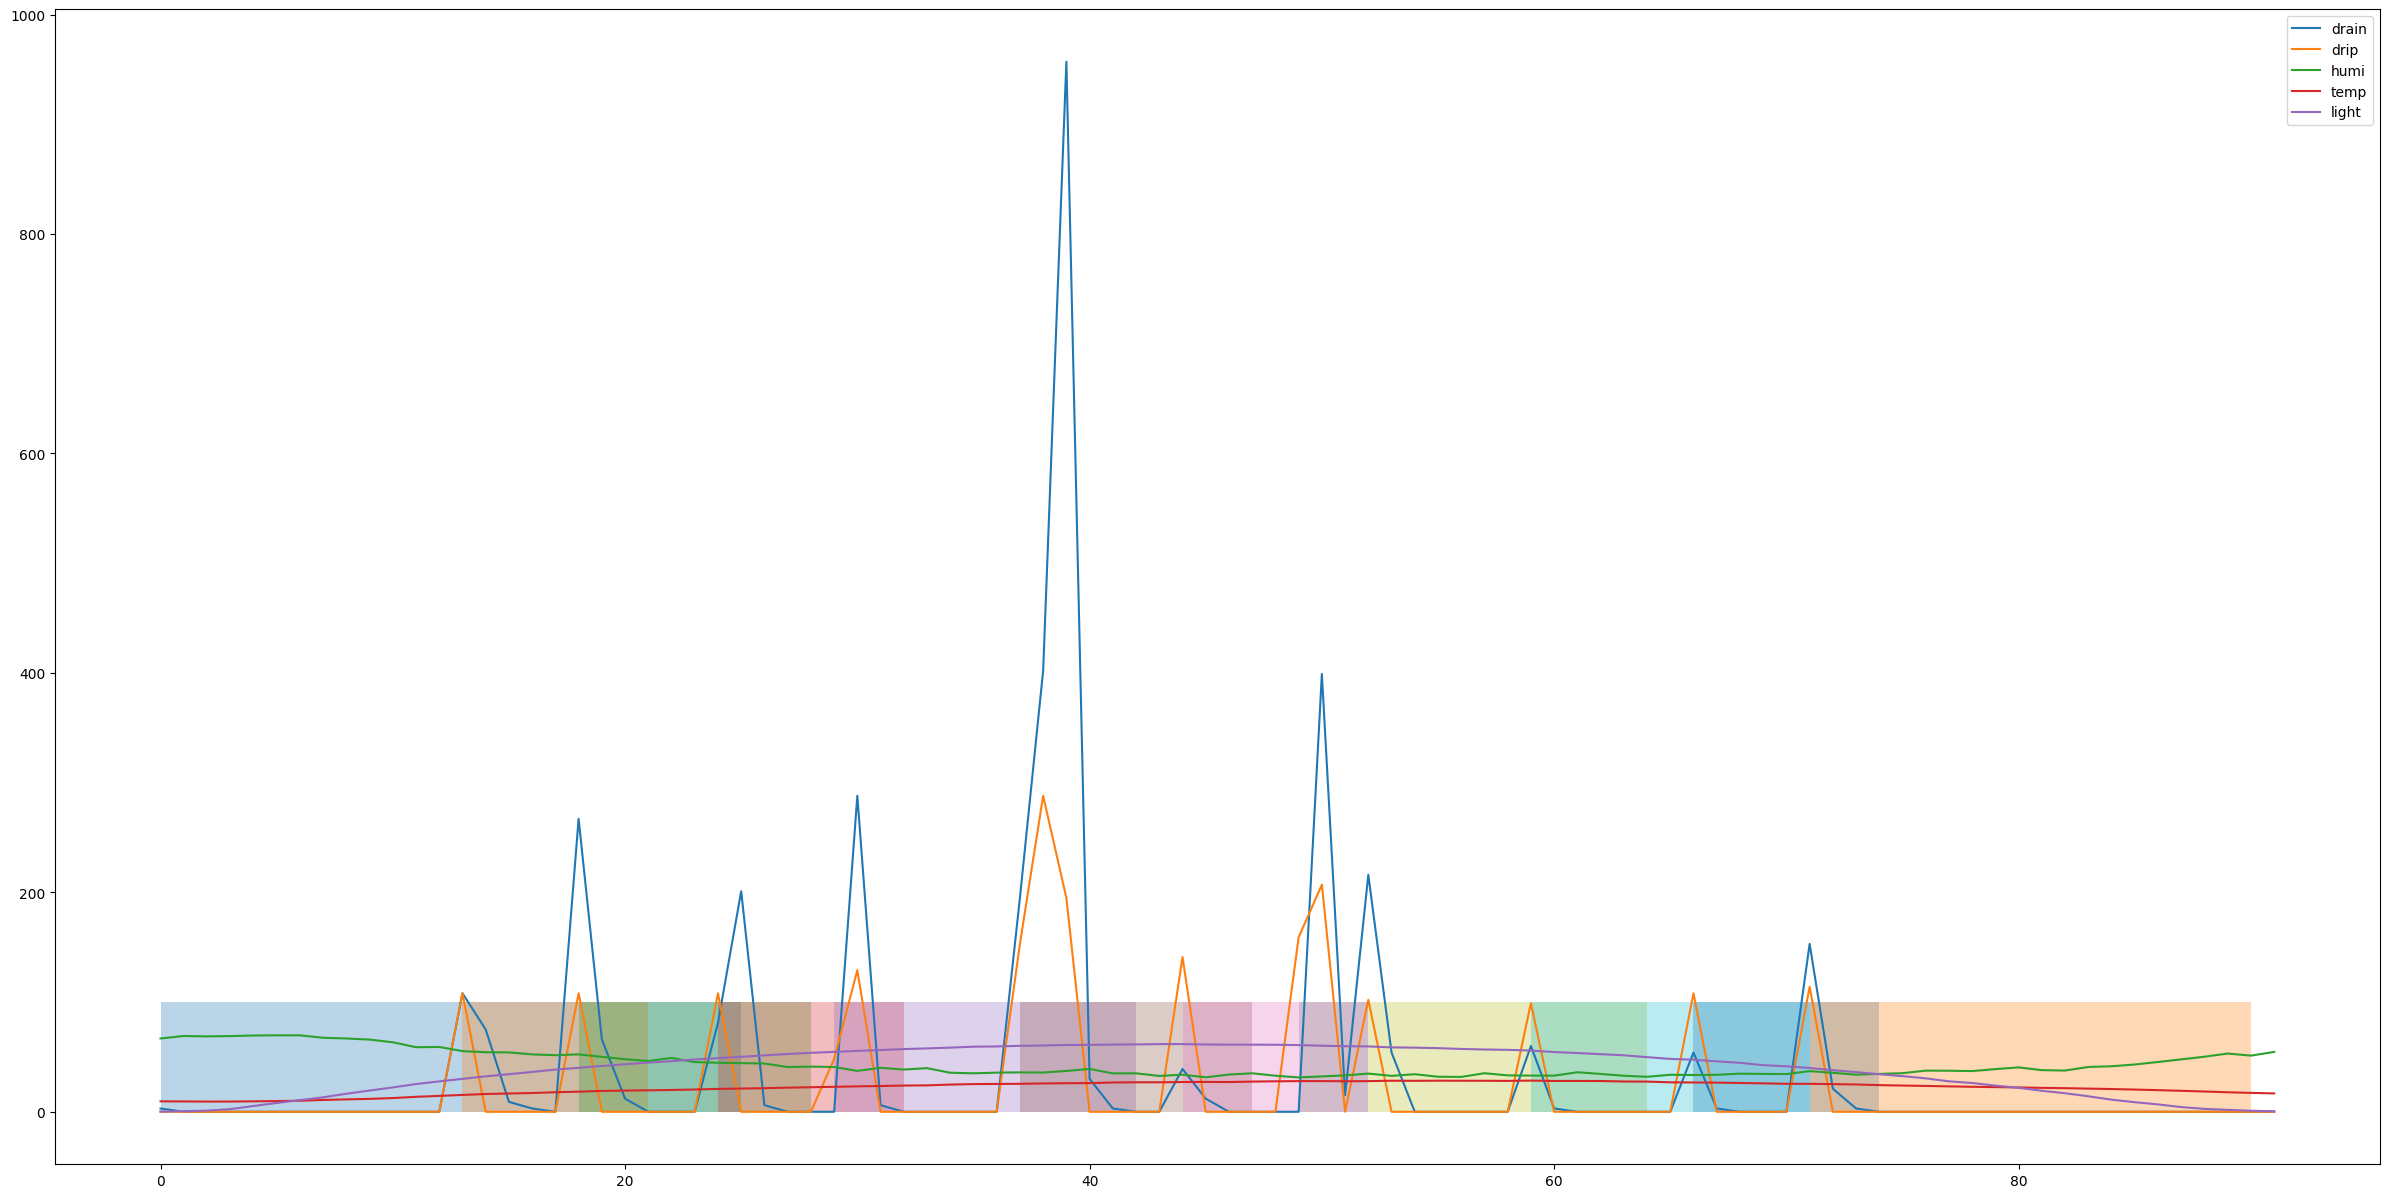

In [6]:
#returns tupels of start, irrigation Point and end of episode in one day
def find_episodes(arr):
    list = []
    start, lastEnd = 0,0
    while start < len(arr)-1: # goes over each sample in a day
        sampleToIgnore = 1
        for i in range(sampleToIgnore,len(arr[start:])): #goes from last starting point and checks if a drip is over 0
            element = (arr[start:][i])
            if element > 0:
                for j, subElement in enumerate(arr[start+i:]): #hops over drips that are below a threshold
                    if subElement == 0:
                        if sum(arr[start+i-sampleToIgnore:start+i+j]) < 80: # one episodes has at least the sum of 80 drip
                            start += i+j
                        # elif start+i <= 20: # one episodes is at least 15 sample/min long
                        #     start += i
                        else:
                            ending = int(start+(i*2)) #150% der eigentlichen zwischen periode
                            ending = min(len(arr),ending) #prevent index bigger than array
                            list.append((lastEnd, start+i, ending)) 
                            lastEnd = start+i
                            start += i+j
                        break
                break 
            elif i == len(arr[start:])-1: #add last array
                list.append((lastEnd, start+i+1, start+i+1))
                start += i
                break
            elif start + i + 1 >= len(arr)-1: #add last array
                list.append((lastEnd, start+i+1, start+i+1))
                start = len(arr)-1
                break
    return list

#Test
day=14
month=6
labels = get_data("70B3D57ED005C6D0", datetime(2023, month, day, 4), datetime(2023, month, day, 23))
labels = downsample_labeled_data(labels, 10)
epis = find_episodes(labels["drip"]["value"])
print(epis)
plt.figure(figsize=(30,15))
for label in labels:
    plt.plot(range(len(labels[label]["value"])),labels[label]["value"],label=label)
for s,irri,end in epis:
    plt.fill_between(range(s,end),np.ones(len(range(s,end)))*100,alpha=0.3)
plt.legend()

[(0, 44, 88), (44, 124, 188), (124, 169, 208), (169, 213, 250), (213, 259, 299), (259, 307, 349), (307, 360, 364), (360, 405, 444), (405, 452, 492), (452, 499, 539), (499, 546, 587), (546, 649, 746), (649, 800, 800)]
[(165, np.float64(184.7133333333333), np.float64(0.0), np.float64(19.009999999999998), np.float64(96.12), np.float64(0.03427452365332796), np.float64(0.0), np.float64(75.0), np.float64(85.21333333333335), 0), (165, np.float64(195.225), np.float64(10.51166666666668), np.float64(19.37), np.float64(94.88), np.float64(0.054682778761311474), np.float64(0.0), np.float64(162.0), np.float64(74.70166666666667), 0), (165, np.float64(206.57333333333332), np.float64(21.860000000000007), np.float64(19.4), np.float64(94.82000000000001), np.float64(0.07155897828890455), np.float64(0.0), np.float64(162.0), np.float64(63.353333333333346), 0), (165, np.float64(217.32999999999998), np.float64(32.61666666666667), np.float64(19.320000000000004), np.float64(94.45), np.float64(0.0963814176885440

C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_14296\688564848.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


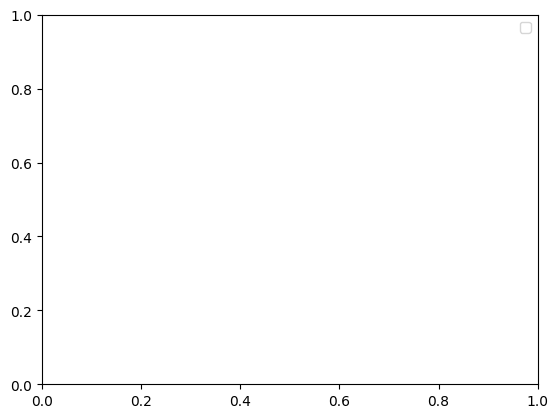

[(165, np.float64(269.9266666666667), np.float64(0.0), np.float64(23.080000000000002), np.float64(81.22999999999999), np.float64(0.2277237362535669), np.float64(0.0), np.float64(249.0), np.float64(43.08166666666666), 0), (165, np.float64(280.44), np.float64(10.513333333333351), np.float64(23.55), np.float64(80.24), np.float64(0.4630015935196834), np.float64(0.0), np.float64(249.0), np.float64(32.56833333333331), 0), (165, np.float64(291.2583333333333), np.float64(21.33166666666666), np.float64(23.919999999999998), np.float64(78.84), np.float64(0.7213939912815563), np.float64(0.0), np.float64(249.0), np.float64(21.75), 0), (165, np.float64(302.50333333333333), np.float64(32.576666666666675), np.float64(24.25), np.float64(77.2), np.float64(1.0235793413307985), np.float64(0.0), np.float64(249.0), np.float64(10.504999999999988), 0), (165, np.float64(313.0083333333333), np.float64(43.08166666666666), np.float64(24.729999999999997), np.float64(77.78999999999999), np.float64(1.346433873981514

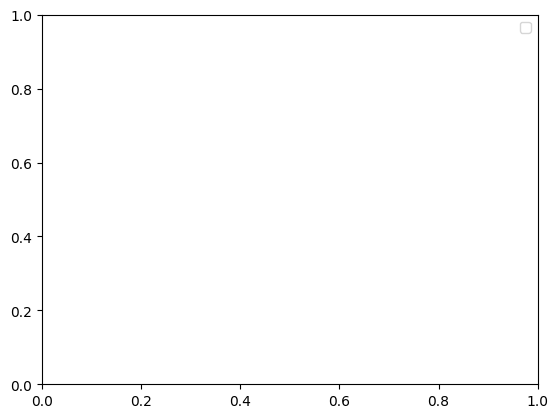

[(165, np.float64(313.0083333333333), np.float64(0.0), np.float64(24.729999999999997), np.float64(77.78999999999999), np.float64(0.32285453265071584), np.float64(0.0), np.float64(12.0), np.float64(52.570000000000014), 0), (165, np.float64(323.51666666666665), np.float64(10.508333333333333), np.float64(25.41), np.float64(77.58000000000001), np.float64(0.6713632076944954), np.float64(3.0), np.float64(258.0), np.float64(42.06166666666668), 0), (165, np.float64(334.025), np.float64(21.016666666666666), np.float64(25.75), np.float64(75.39999999999999), np.float64(0.9511395029548817), np.float64(15.0), np.float64(258.0), np.float64(31.553333333333345), 0), (165, np.float64(344.53333333333336), np.float64(31.525), np.float64(26.32), np.float64(75.67999999999998), np.float64(1.3019067264195363), np.float64(21.0), np.float64(258.0), np.float64(21.045000000000012), 0), (165, np.float64(355.0416666666667), np.float64(42.03333333333333), np.float64(27.28), np.float64(73.39000000000001), np.float64

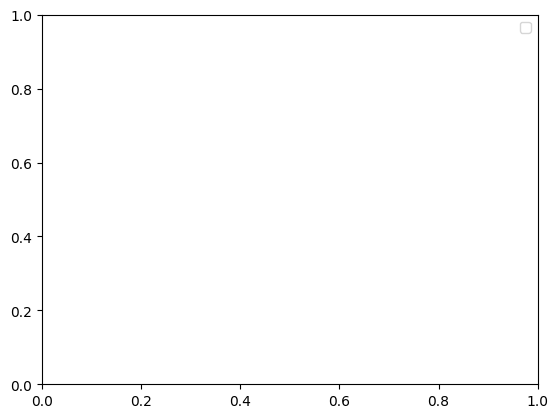

[(165, np.float64(365.5783333333333), np.float64(0.0), np.float64(27.51), np.float64(72.13000000000001), np.float64(0.3406944206688598), np.float64(33.0), np.float64(261.0), np.float64(44.19666666666665), 0), (165, np.float64(377.2083333333333), np.float64(11.629999999999988), np.float64(28.21), np.float64(70.17), np.float64(0.7360271116285657), np.float64(54.0), np.float64(261.0), np.float64(32.56666666666667), 0), (165, np.float64(388.76666666666665), np.float64(23.188333333333322), np.float64(28.8), np.float64(69.92), np.float64(1.1892284774669335), np.float64(60.0), np.float64(261.0), np.float64(21.008333333333333), 0), (165, np.float64(399.27000000000004), np.float64(33.69166666666667), np.float64(29.330000000000002), np.float64(68.19999999999999), np.float64(1.6317510988508812), np.float64(60.0), np.float64(261.0), np.float64(10.504999999999988), 0), (165, np.float64(409.775), np.float64(44.19666666666665), np.float64(30.029999999999994), np.float64(65.58999999999999), np.float64

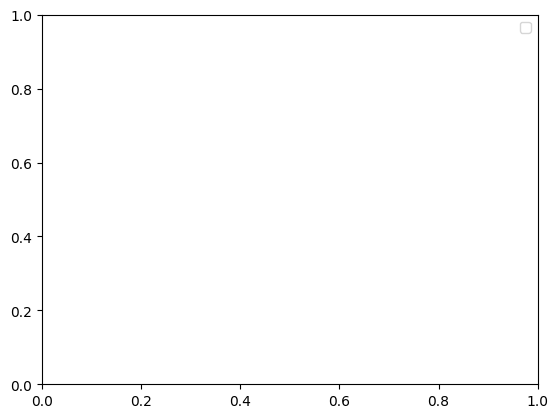

[(165, np.float64(409.775), np.float64(0.0), np.float64(30.029999999999994), np.float64(65.58999999999999), np.float64(0.47007262337331135), np.float64(0.0), np.float64(36.0), np.float64(52.521666666666654), 0), (165, np.float64(420.27666666666664), np.float64(10.501666666666642), np.float64(30.78), np.float64(62.910000000000004), np.float64(0.9489570585808458), np.float64(39.0), np.float64(261.0), np.float64(42.02000000000001), 0), (165, np.float64(430.78333333333336), np.float64(21.008333333333333), np.float64(31.229999999999997), np.float64(64.28), np.float64(1.4348771362946395), np.float64(51.0), np.float64(261.0), np.float64(31.51333333333332), 0), (165, np.float64(441.2883333333333), np.float64(31.51333333333332), np.float64(31.919999999999998), np.float64(59.75999999999999), np.float64(1.9120707081329407), np.float64(51.0), np.float64(261.0), np.float64(21.008333333333333), 0), (165, np.float64(451.7916666666667), np.float64(42.016666666666666), np.float64(31.93), np.float64(59.

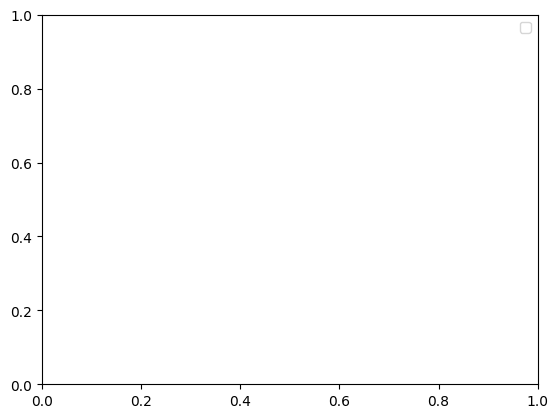

[(165, np.float64(462.2966666666667), np.float64(0.0), np.float64(32.230000000000004), np.float64(60.55), np.float64(0.4333124378611839), np.float64(3.0), np.float64(147.0), np.float64(52.56666666666667), 0), (165, np.float64(472.8016666666666), np.float64(10.504999999999988), np.float64(32.53), np.float64(62.92999999999999), np.float64(0.9312075443661706), np.float64(51.0), np.float64(255.0), np.float64(42.06166666666668), 0), (165, np.float64(483.30833333333334), np.float64(21.011666666666677), np.float64(33.309999999999995), np.float64(58.11), np.float64(1.319635041154321), np.float64(63.0), np.float64(255.0), np.float64(31.55499999999999), 0), (165, np.float64(493.81), np.float64(31.51333333333332), np.float64(33.690000000000005), np.float64(59.08), np.float64(1.8364130355156103), np.float64(66.0), np.float64(255.0), np.float64(21.053333333333345), 0), (165, np.float64(504.32166666666666), np.float64(42.025), np.float64(33.56), np.float64(56.529999999999994), np.float64(2.314572566

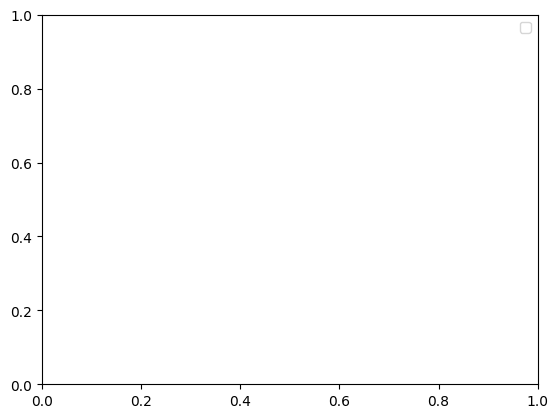

[(165, np.float64(514.8633333333333), np.float64(0.0), np.float64(33.46), np.float64(55.279999999999994), np.float64(0.49576092298094593), np.float64(0.0), np.float64(3.0), np.float64(54.72000000000001), 0), (165, np.float64(525.4566666666667), np.float64(10.59333333333337), np.float64(33.93), np.float64(57.54), np.float64(1.0017235346107505), np.float64(42.0), np.float64(255.0), np.float64(44.126666666666644), 0), (165, np.float64(536.275), np.float64(21.41166666666668), np.float64(34.3), np.float64(53.96999999999999), np.float64(1.506976591162209), np.float64(54.0), np.float64(255.0), np.float64(33.30833333333333), 0), (165, np.float64(547.8366666666666), np.float64(32.973333333333294), np.float64(33.63999999999999), np.float64(57.32000000000001), np.float64(2.002845464556741), np.float64(57.0), np.float64(255.0), np.float64(21.746666666666716), 0), (165, np.float64(559.075), np.float64(44.21166666666668), np.float64(33.51), np.float64(57.94), np.float64(2.442788149386032), np.float6

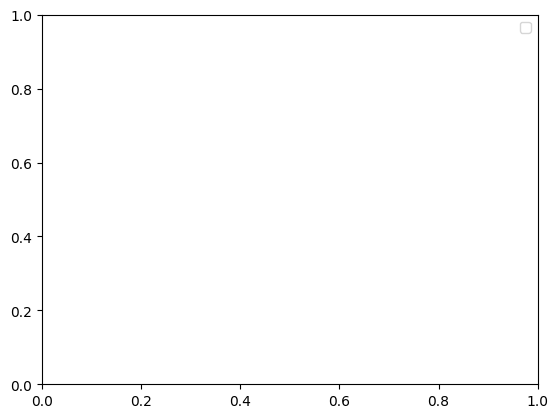

[(165, np.float64(569.5833333333334), np.float64(0.0), np.float64(31.660000000000004), np.float64(59.95), np.float64(0.12917709801143476), np.float64(6.0), np.float64(213.0), np.float64(53.58833333333338), 0), (165, np.float64(580.09), np.float64(10.50666666666669), np.float64(30.959999999999997), np.float64(63.95), np.float64(0.4256523643427286), np.float64(57.0), np.float64(267.0), np.float64(43.08166666666669), 0), (165, np.float64(590.5916666666667), np.float64(21.008333333333333), np.float64(32.83), np.float64(60.870000000000005), np.float64(0.890391018163683), np.float64(66.0), np.float64(267.0), np.float64(32.58000000000005), 0), (165, np.float64(601.9433333333333), np.float64(32.35999999999998), np.float64(33.769999999999996), np.float64(56.160000000000004), np.float64(1.3935489111737613), np.float64(69.0), np.float64(267.0), np.float64(21.228333333333406), 0), (165, np.float64(612.66), np.float64(43.07666666666664), np.float64(33.61), np.float64(55.54), np.float64(1.7670990304

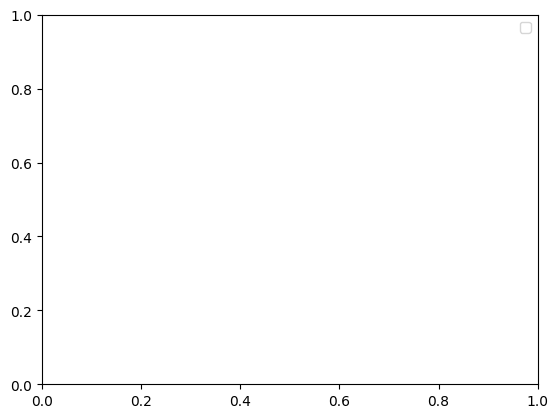

[(165, np.float64(623.1716666666667), np.float64(0.0), np.float64(33.68), np.float64(54.73), np.float64(0.469804100050757), np.float64(27.0), np.float64(273.0), np.float64(43.1399999999999), 0), (165, np.float64(633.6766666666666), np.float64(10.504999999999928), np.float64(34.09), np.float64(52.73), np.float64(0.9637675105700801), np.float64(45.0), np.float64(273.0), np.float64(32.63499999999998), 0), (165, np.float64(644.1883333333334), np.float64(21.016666666666666), np.float64(33.8), np.float64(55.07000000000001), np.float64(1.4311443999107756), np.float64(45.0), np.float64(273.0), np.float64(22.123333333333235), 0), (165, np.float64(655.4316666666667), np.float64(32.25999999999998), np.float64(33.75), np.float64(56.57000000000001), np.float64(1.8712502656863501), np.float64(45.0), np.float64(273.0), np.float64(10.879999999999928), 0), (165, np.float64(666.3116666666666), np.float64(43.1399999999999), np.float64(33.48), np.float64(54.410000000000004), np.float64(2.2463037898506037)

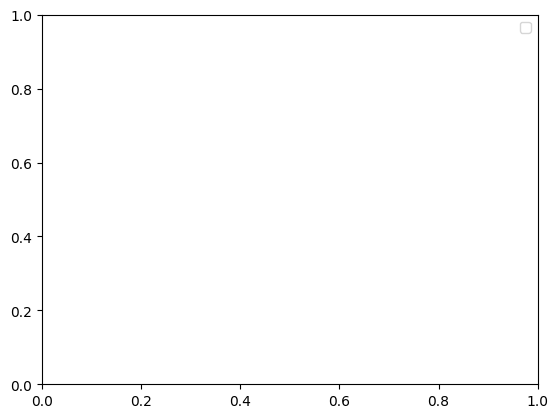

[(165, np.float64(666.3116666666666), np.float64(0.0), np.float64(33.48), np.float64(54.410000000000004), np.float64(0.37505352416425386), np.float64(0.0), np.float64(21.000000000000004), np.float64(53.648333333333355), 0), (165, np.float64(676.8733333333333), np.float64(10.56166666666674), np.float64(33.02), np.float64(55.15999999999999), np.float64(0.8150527427599252), np.float64(45.0), np.float64(270.0), np.float64(43.086666666666616), 0), (165, np.float64(687.385), np.float64(21.07333333333336), np.float64(33.6), np.float64(52.989999999999995), np.float64(1.2690202582872663), np.float64(54.0), np.float64(270.0), np.float64(32.575), 0), (165, np.float64(697.8933333333333), np.float64(31.581666666666692), np.float64(33.489999999999995), np.float64(54.07000000000001), np.float64(1.7055144624409144), np.float64(57.0), np.float64(270.0), np.float64(22.066666666666666), 0), (165, np.float64(708.4050000000001), np.float64(42.09333333333343), np.float64(32.99999999999999), np.float64(54.05

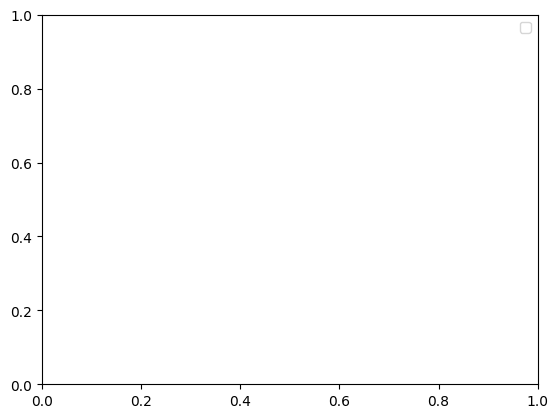

[(165, np.float64(719.9599999999999), np.float64(0.0), np.float64(32.53), np.float64(56.21), np.float64(0.3904508377123727), np.float64(0.0), np.float64(198.0), np.float64(106.19833333333335), 0), (165, np.float64(730.4716666666667), np.float64(10.51166666666674), np.float64(32.510000000000005), np.float64(57.169999999999995), np.float64(0.6993653596875558), np.float64(48.0), np.float64(258.0), np.float64(95.68666666666662), 0), (165, np.float64(741.925), np.float64(21.965000000000025), np.float64(32.839999999999996), np.float64(55.92), np.float64(1.0902849297152786), np.float64(57.0), np.float64(258.0), np.float64(84.23333333333333), 0), (165, np.float64(752.5433333333333), np.float64(32.583333333333336), np.float64(33.04), np.float64(54.9), np.float64(1.4649458650870157), np.float64(60.0), np.float64(258.0), np.float64(73.61500000000002), 0), (165, np.float64(763.0566666666667), np.float64(43.096666666666714), np.float64(33.150000000000006), np.float64(53.92999999999999), np.float64(

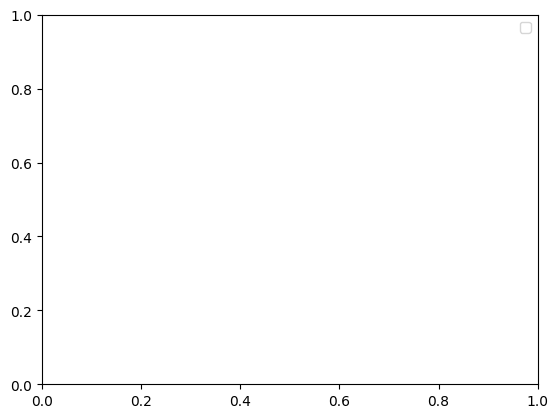

In [7]:
def get_episodes_from_day(labeledData, doy=None):
    labeledData = downsample_labeled_data(labeledData, factor=10) #downsample to 10min intervals
    episodes = []
    lengthEpisodes = find_episodes(labeledData["drip"]["value"])
    for start, irri, end in lengthEpisodes[1:-1]: #drop last episode because no action possible, drop first episode because no drain measured
        epi = []
        time, drain, humi, temp, timeToIrri, light, drip, terminal = 0, 0, 0, 0, 0, 0, 0, 0
        for i in range(start, end):
            epiDoy = doy
            abstime = labeledData["drip"]["time"][i]/60 # in Minuten
            timeToIrri = (labeledData["drip"]["time"][irri] - labeledData["drip"]["time"][i])/60 # in Minuten
            time = (labeledData["drip"]["time"][i] - labeledData["drip"]["time"][start])/60 # in Minuten
            terminal = 1
            if timeToIrri > 0:
                drain += labeledData["drain"]["value"][i]
                drip += labeledData["drip"]["value"][i]
                terminal = 0
            humi = labeledData["humi"]["value"][i]
            temp = labeledData["temp"]["value"][i]
            light += lux_to_wm2(labeledData["light"]["value"])[i]
            oberservation = (epiDoy, abstime, time, temp, humi, light, drain, drip, timeToIrri, terminal)
            epi.append(oberservation)
        episodes.append(epi)
    return episodes

data = get_data("70B3D57ED005C6D0", datetime(2023, 8, 23, 4), datetime(2023, 8, 23, 23))
lengthEpisodes = find_episodes(data["drip"]["value"])
print(lengthEpisodes)
episoden = get_episodes_from_day(data, doy=datetime(2023, month, day).timetuple().tm_yday)
for n, epi in enumerate(episoden):
    print(epi)
    print("länge der Episode: ", len(epi))
    timeToIrris = []
    # plt.plot(range(len(epi)),data["drip"]["value"][lengthEpisodes[n][0]:lengthEpisodes[n][2]],label="drip")
    # plt.plot(range(len(epi)),data["drain"]["value"][lengthEpisodes[n][0]:lengthEpisodes[n][2]],label="drain")
    # plt.plot(range(len(epi)),[abstime for abstime, time, drain, humi, temp, light, drip, timeToIrri in epi],label="seconds absolut")
    # plt.plot(range(len(epi)),[time for abstime, time, drain, humi, temp, light, drip, timeToIrri in epi],label="seconds relativ")
    # plt.plot(range(len(epi)),[drain for epiDoy, abstime, time, temp, humi, light, drain, drip, timeToIrri, terminal in epi],label="drain")
    # plt.plot(range(len(epi)),[drip for epiDoy, abstime, time, temp, humi, light, drain, drip, timeToIrri, terminal in epi],label="drip")
    # plt.plot(range(len(epi)),[humi for abstime, time, drain, humi, temp, light, drip, timeToIrri in epi],label="humidity")
    # plt.plot(range(len(epi)),[temp for abstime, time, drain, humi, temp, light, drip, timeToIrri in epi],label="temperatur")
    # plt.plot(range(len(epi)),[light for abstime, time, drain, humi, temp, light, drip, timeToIrri in epi],label="light")
    # plt.plot(range(len(epi)),[timeToIrri for abstime, time, drain, humi, temp, light, drip, timeToIrri in epi],label="seconds to irrigation")
    # plt.legend()
    # plt.show()

In [8]:
#month day tuples
dataD0 = [(5,16),(5,17),(5,18),(5,19),(5,20),(5,21),(5,22),(5,23),(5,24),(5,25),(5,26),(5,27),(5,28),(5,29),(5,30),(5,31),
          (6,2),(6,3),(6,14),(6,15),(6,16),(6,17),(6,18),(6,19),(6,20),(6,21),(6,22),(6,23),(6,24),(6,25),(6,26),(6,27),
          (7,6),(7,7),(7,8),(7,9),(7,10),(7,11),(7,15),
          (8,19),(8,20),(8,21),(8,22),(8,23),(8,24),(8,25),(8,26),(8,27),(8,28),(8,29),(8,30),(8,31),
          (9,1),(9,11),(9,12),(9,13),(9,14)]
dataD0problem = [(6,4),(6,5),(6,6),(6,8),(6,28),(6,29),(6,30),(7,1),(7,2),(7,3),(7,4),(7,5),(7,12),(7,13),(7,14),(7,16),(7,24),
                 (7,25),(7,26),(7,27),(7,28),(7,29),(9,2),(9,3),(9,4),(9,5),(9,6),(9,8),(9,9),(9,10),(9,15),(9,16),(9,17),(9,18)]
dataD2 = [(5,16),(5,17),(5,18),(5,19),(5,20),(5,21),(5,22),(5,23),(5,24),(5,25),(5,28),(6,7),(6,8),(7,8)]
dataD2problem = [(5,26),(5,27),(5,29),(5,30),(5,31),(6,2),(6,3),(6,4),(6,5),(6,6)]

#wechseln von Drip und Drain
dataD1 = [(6,23),(6,24),(6,25),(6,26),(7,6),(7,7),(7,9),(7,10),(7,11),(7,15),(7,16),(7,25),(7,26),(7,27),(7,28),(8,19)]
dataD1problem = [(6,27),(6,28),(6,29),(8,20),(8,21),(8,22),(8,23),(9,8),(9,9),(9,10),(9,11),(9,12),(9,13),(9,14),(9,15)]

#create data tuples
data = [("70B3D57ED005C6D0", dataD0, dataD0problem), ("70B3D57ED005C6D1", dataD1, dataD1problem), ("70B3D57ED005C6D2", dataD2, dataD2problem)]

In [9]:
#save Episodes from data
def save_Episode(baseFolder,month,day,episodes):
    if not os.path.exists(baseFolder):
        os.makedirs(baseFolder)

    for i, epi in enumerate(episodes):
        fileName = os.path.join(baseFolder,str(month)+"-"+str(day)+"-Epi"+str(i)+".csv")
        with open(fileName, "w", newline="") as file:
            writer = csv.writer(file)
            for obs in epi:
                writer.writerow(obs)
            
def read_Episodes(baseFolder):
    episodes = []
    for filename in sorted(os.listdir(baseFolder)):
        filePath = os.path.join(baseFolder, filename)
        episode = []
        with open(filePath, "r", newline="") as file:
            reader = csv.reader(file)
            for row in reader:
                observation = [float(epi) for epi in row]
                episode.append(tuple(observation))
            episodes.append(episode)        
    return episodes

# Test
# save_Episode("firstTrue", 8, 23, episoden)
# a  = read_Episodes("firstTrue")
# for i, epsi in enumerate(a):
#     print(epsi)
#     print(epis[i])

In [10]:
savePath = "3.2 test für 2.0"
data = [("70B3D57ED005C6D0", dataD0, dataD0problem)]
for id,good,bad in data:
    for month, day in good:
        dayData = get_data(id, datetime(2023, month, day, 4), datetime(2023, month, day, 23))
        episodes = get_episodes_from_day(dayData, doy=datetime(2023, month, day).timetuple().tm_yday)
        save_Episode(savePath, month, day, episodes)

C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_9688\478605191.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


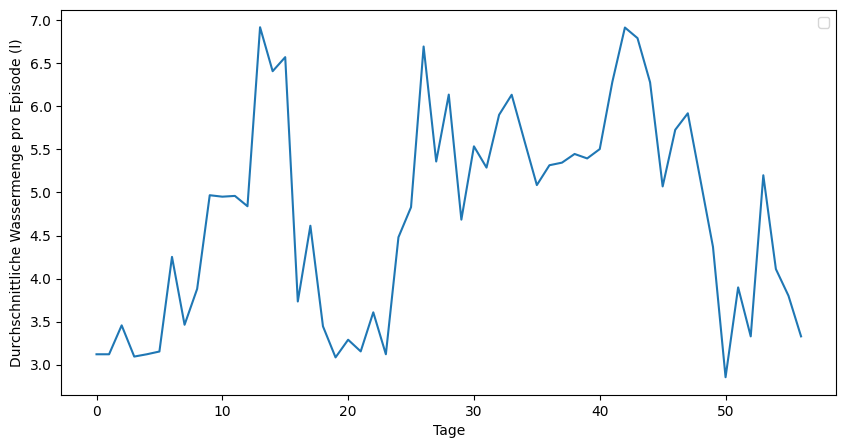

Mean drip:  4.738512639407376 l


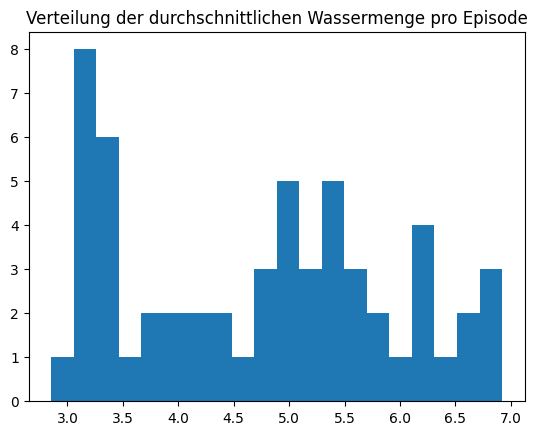

In [24]:
#get mean Drip
meanDrip = []
for id,good,bad in [("70B3D57ED005C6D0", dataD0, dataD0problem)]:
    for month, day in good:
        dayData = get_data(id, datetime(2023, month, day, 4), datetime(2023, month, day, 23))
        epis = find_episodes(dayData["drip"]["value"])
        waterGiven = (dayData['drip']['value'].sum()/300)*8 # /300 um scalierung rückgängig zu machen * 8 wegen 8 tropfern
        drip = waterGiven/(len(epis)-1) # -1 weil letzte epi kein drain gemessen wurde
        meanDrip.append(drip)
plt.figure(figsize=(10,5))
plt.xlabel("Tage")
plt.ylabel("Durchschnittliche Wassermenge pro Episode (l)")
plt.plot(np.arange(len(meanDrip)), meanDrip)
plt.legend()
plt.show()
plt.hist(meanDrip, bins=20)
plt.title("Verteilung der durchschnittlichen Wassermenge pro Episode")
meanDrip = np.mean(meanDrip)
print("Mean drip: ", meanDrip, "l")

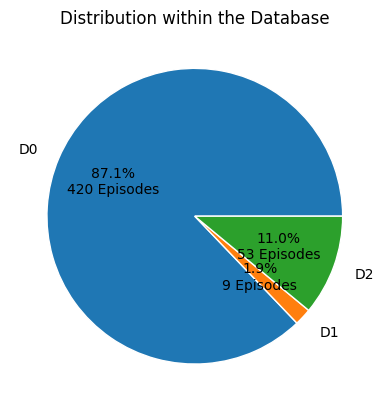

In [ ]:
# Anzahl der Episoden
values = [
    len(os.listdir(savePath+"/70B3D57ED005C6D0")),
    len(os.listdir(savePath+"/70B3D57ED005C6D1")),
    len(os.listdir(savePath+"/70B3D57ED005C6D2")),
]
names = ["D0","D1","D2"]


# Creating autopct arguments
def getPct(pct, allvalues):
    absoluteVal = int(pct / 100.0 * np.sum(allvalues))
    return "{:.1f}%\n{:d} Episodes".format(pct, absoluteVal)


# Create a pieplot
plt.pie(
    values,
    labels=names,
    labeldistance=1.15,
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
    autopct=lambda pct: getPct(pct, values),
)
plt.title("Distribution within the Database")
plt.show()

from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop:

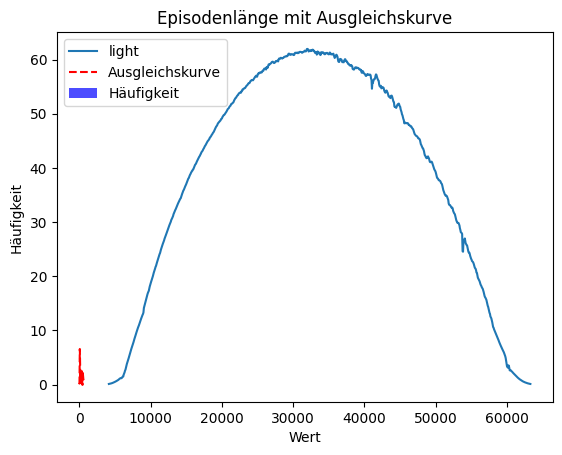

In [ ]:
#episoden Länge
data = [("70B3D57ED005C6D0", dataD0, dataD0problem), ("70B3D57ED005C6D1", dataD1, dataD1problem), ("70B3D57ED005C6D2", dataD2, dataD2problem)]
epis = []
for id,good,bad in data:
    for month, day in good:
        dayData = get_data(id, datetime(2023, month, day, 4), datetime(2023, month, day, 23))
        epi = get_episodes_from_day(dayData)
        for e in epi:
            epis.append(len(e))

plt.plot(labels[label]["time"],labels[label]["value"],label=label)
plt.legend()
import numpy as np
import matplotlib.pyplot as plt

def create_bar_chart_with_trend(array):
    unique_values, value_counts = np.unique(array, return_counts=True)
    
    # Erstelle das Balkendiagramm
    plt.bar(unique_values, value_counts, color='b', alpha=0.7, label='Häufigkeit')

    # Berechne die Ausgleichskurve (linear)
    z = np.polyfit(unique_values, value_counts, 10)
    p = np.poly1d(z)
    
    # Zeichne die Ausgleichskurve
    plt.plot(unique_values, p(unique_values), 'r--', label='Ausgleichskurve')

    plt.xlabel('Wert')
    plt.ylabel('Häufigkeit')
    plt.title('Episodenlänge mit Ausgleichskurve')
    plt.legend()
    plt.show()

# Beispielarray
create_bar_chart_with_trend(epis)

from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop: 2023-05-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-16T04:00:00+02:00, stop:

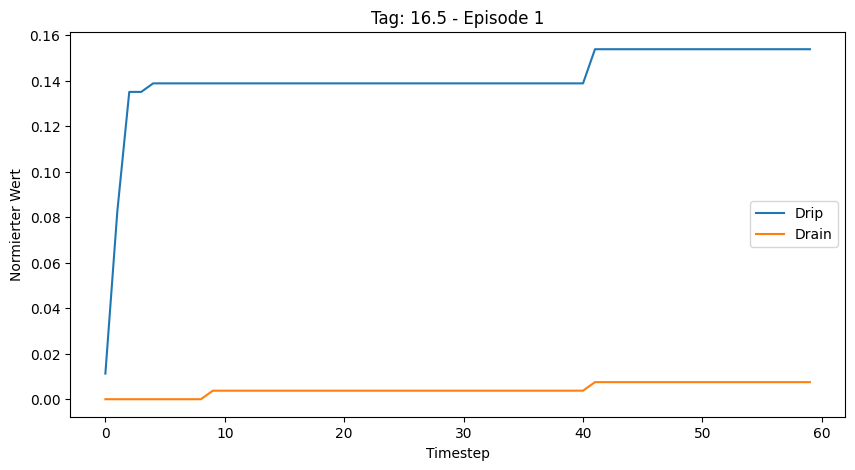

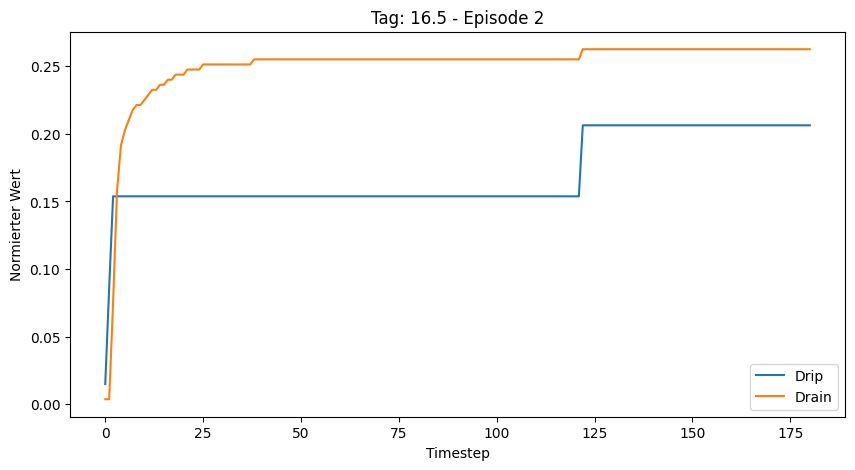

from(bucket: "SensorNodes")|> range(start: 2023-05-17T04:00:00+02:00, stop: 2023-05-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-17T04:00:00+02:00, stop: 2023-05-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-17T04:00:00+02:00, stop: 2023-05-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-17T04:00:00+02:00, stop: 2023-05-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-17T04:00:00+02:00, stop:

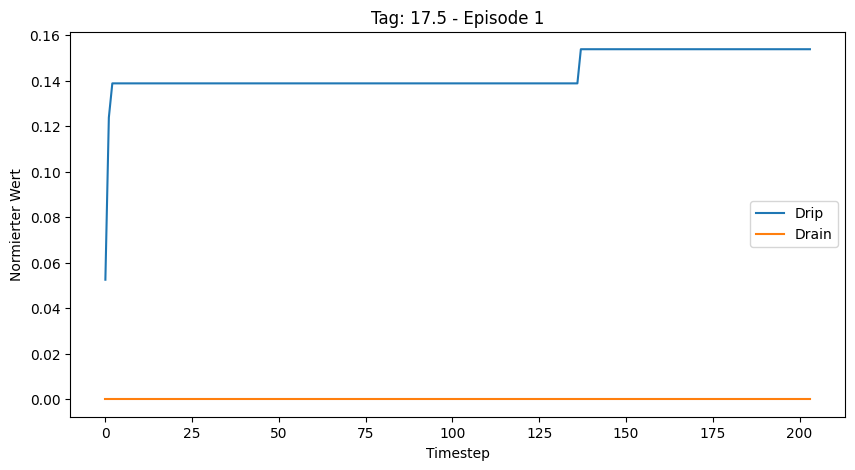

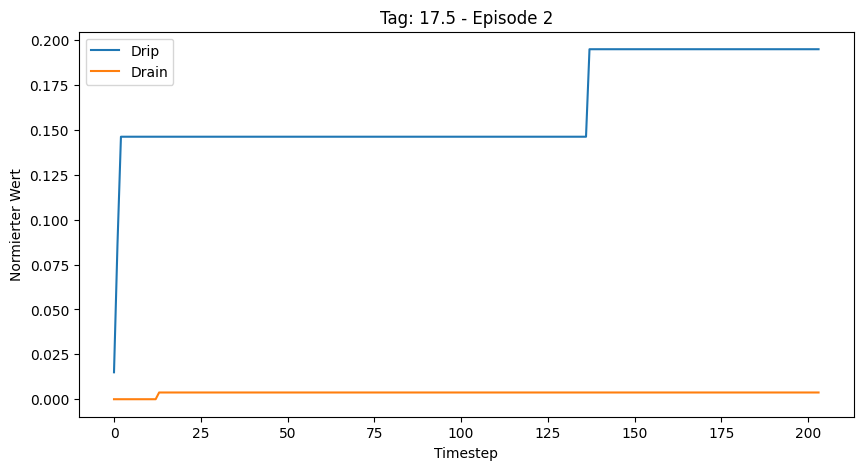

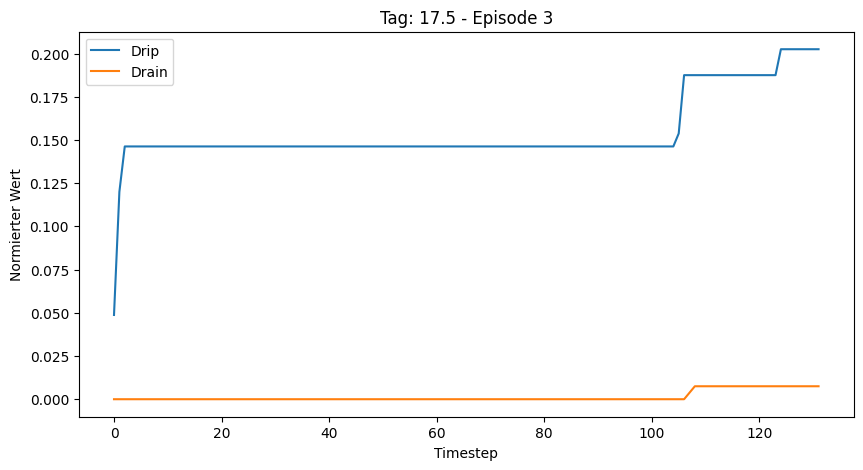

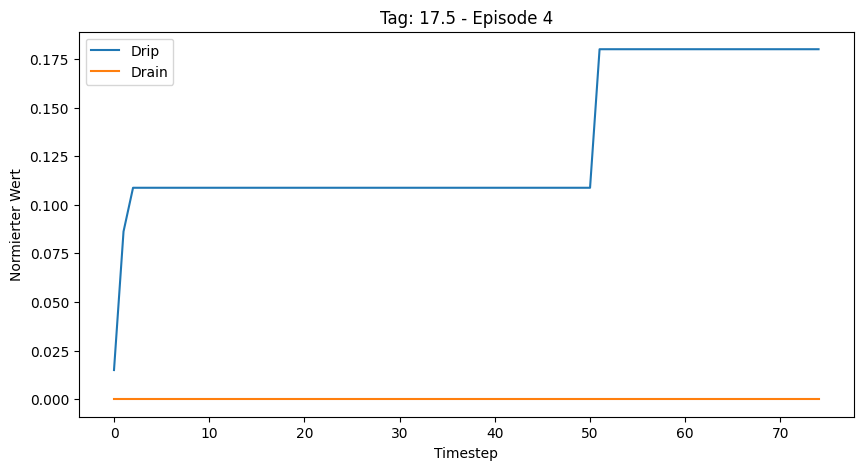

from(bucket: "SensorNodes")|> range(start: 2023-05-18T04:00:00+02:00, stop: 2023-05-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-18T04:00:00+02:00, stop: 2023-05-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-18T04:00:00+02:00, stop: 2023-05-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-18T04:00:00+02:00, stop: 2023-05-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-18T04:00:00+02:00, stop:

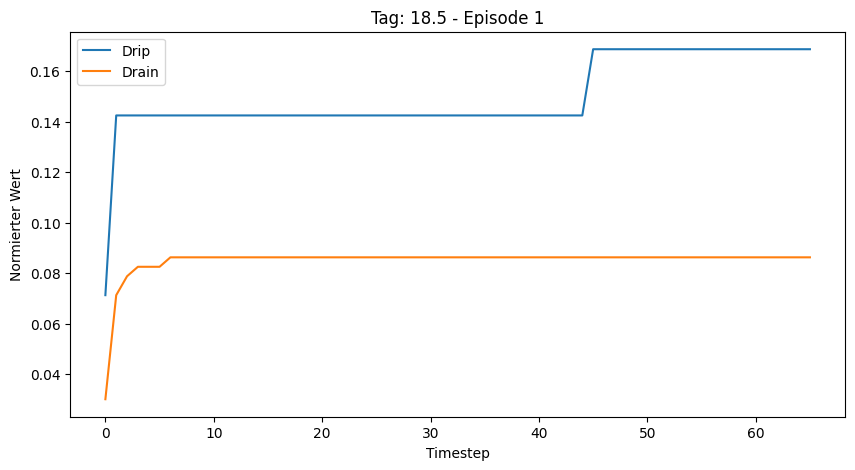

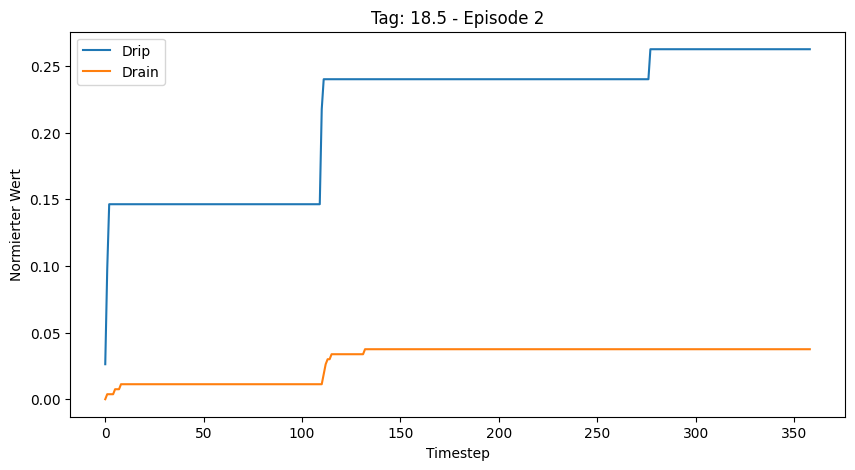

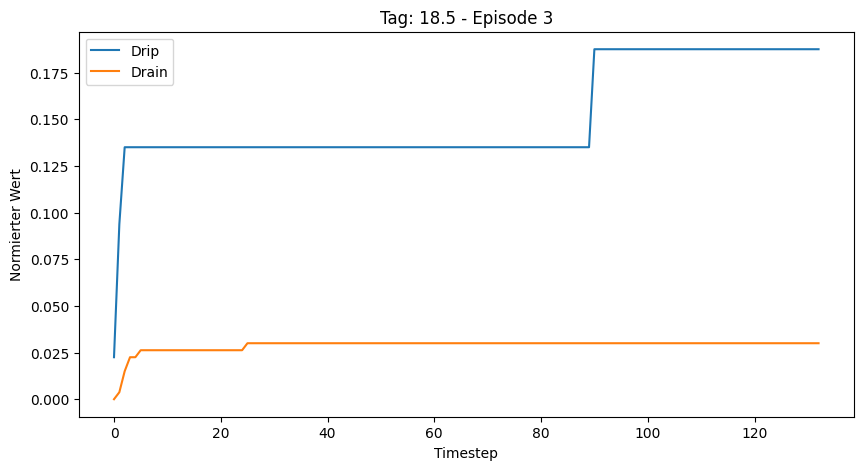

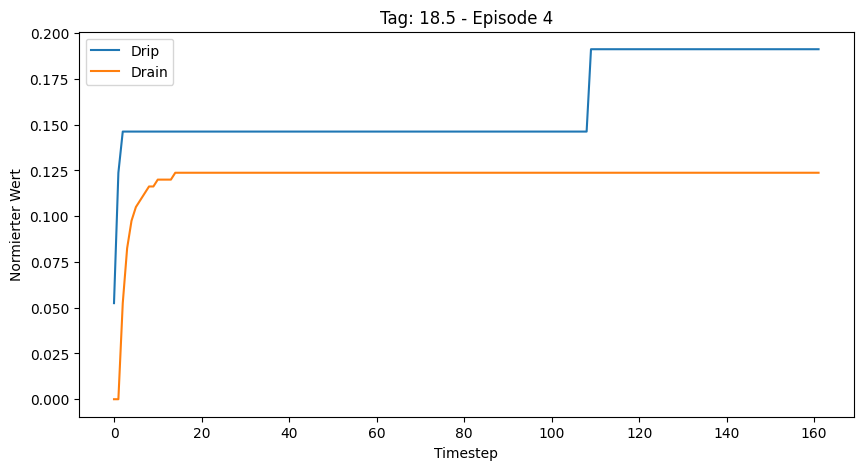

from(bucket: "SensorNodes")|> range(start: 2023-05-19T04:00:00+02:00, stop: 2023-05-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-19T04:00:00+02:00, stop: 2023-05-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-19T04:00:00+02:00, stop: 2023-05-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-19T04:00:00+02:00, stop: 2023-05-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-19T04:00:00+02:00, stop:

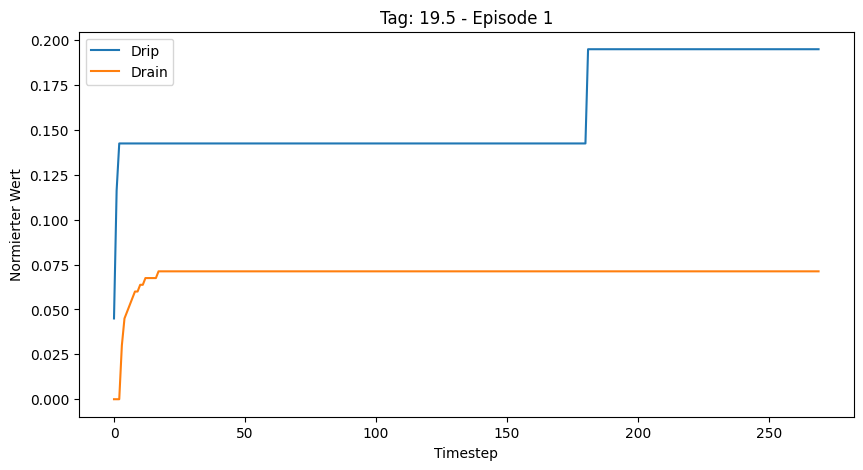

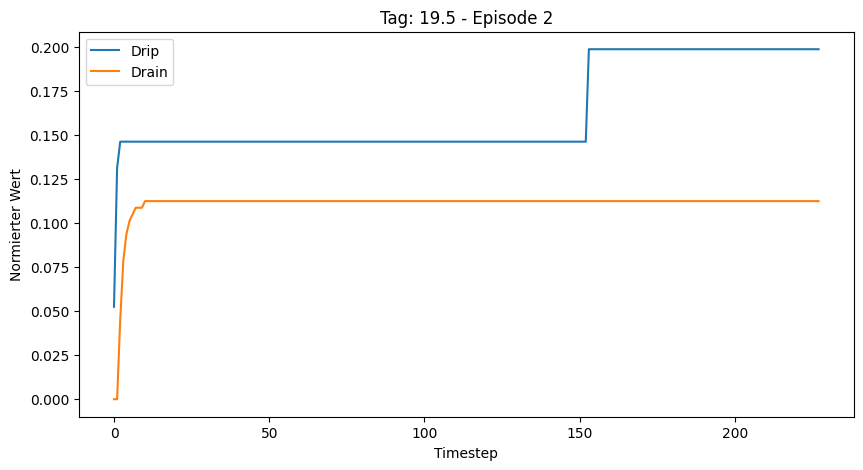

from(bucket: "SensorNodes")|> range(start: 2023-05-20T04:00:00+02:00, stop: 2023-05-20T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-20T04:00:00+02:00, stop: 2023-05-20T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-20T04:00:00+02:00, stop: 2023-05-20T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-20T04:00:00+02:00, stop: 2023-05-20T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-20T04:00:00+02:00, stop:

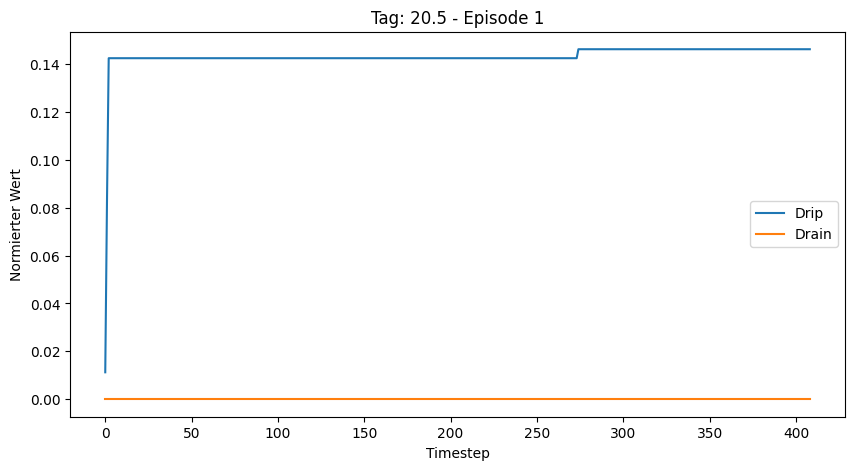

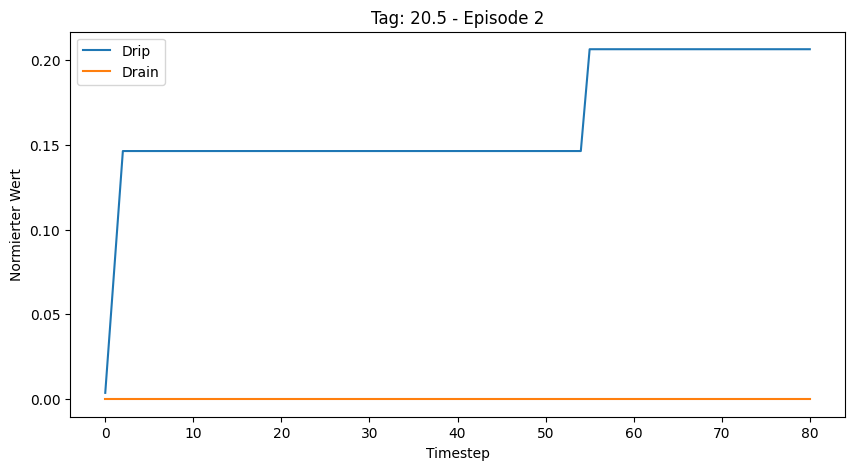

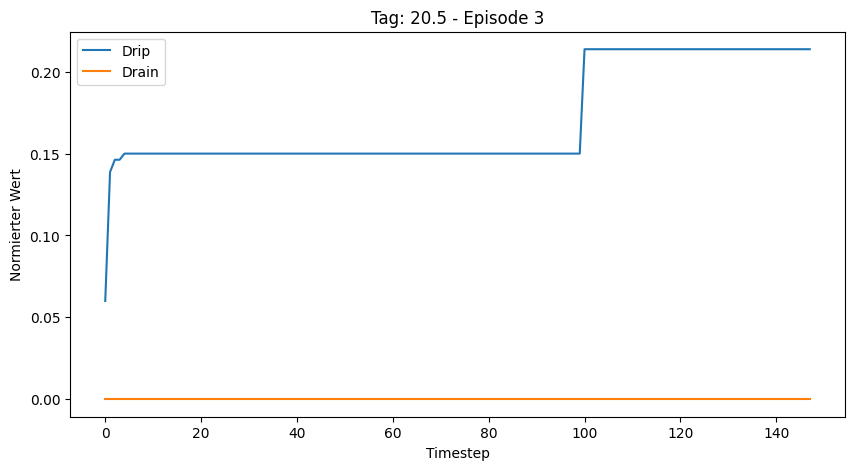

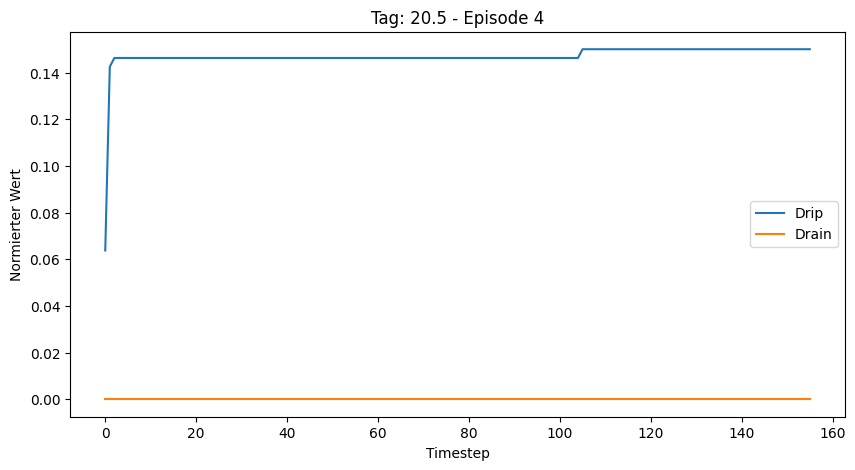

from(bucket: "SensorNodes")|> range(start: 2023-05-21T04:00:00+02:00, stop: 2023-05-21T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-21T04:00:00+02:00, stop: 2023-05-21T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-21T04:00:00+02:00, stop: 2023-05-21T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-21T04:00:00+02:00, stop: 2023-05-21T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-21T04:00:00+02:00, stop:

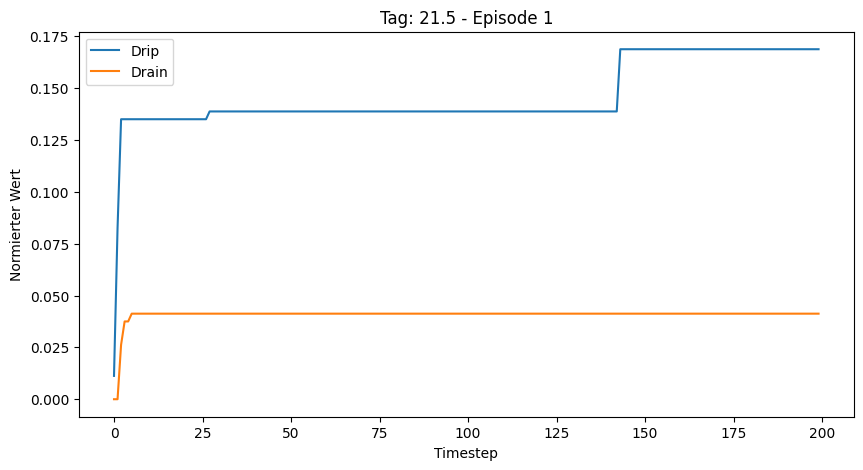

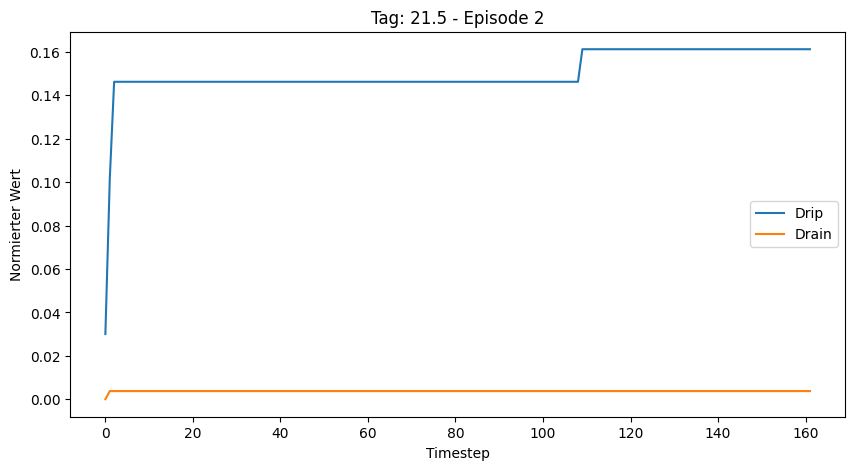

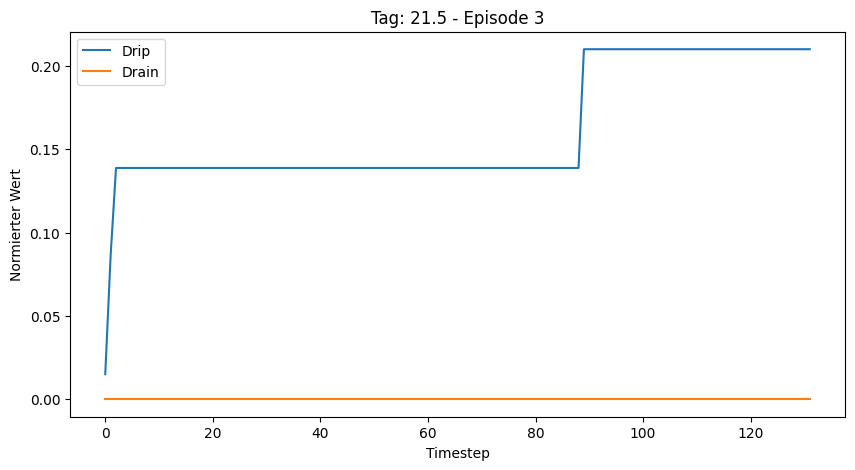

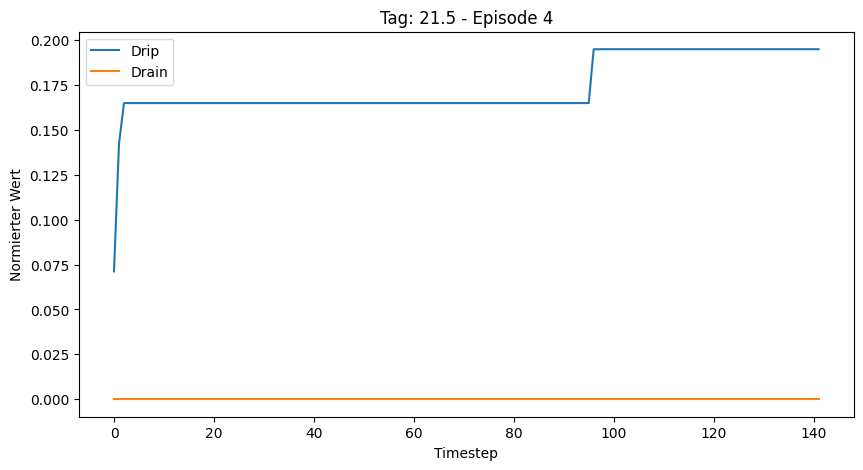

from(bucket: "SensorNodes")|> range(start: 2023-05-22T04:00:00+02:00, stop: 2023-05-22T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-22T04:00:00+02:00, stop: 2023-05-22T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-22T04:00:00+02:00, stop: 2023-05-22T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-22T04:00:00+02:00, stop: 2023-05-22T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-22T04:00:00+02:00, stop:

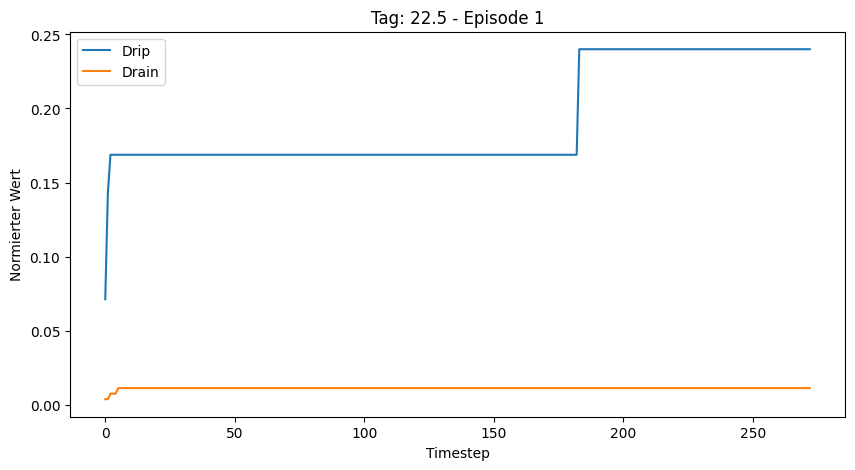

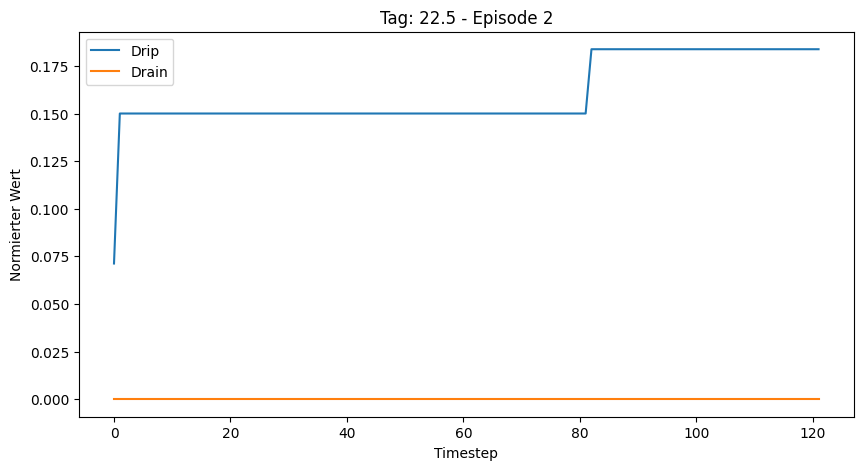

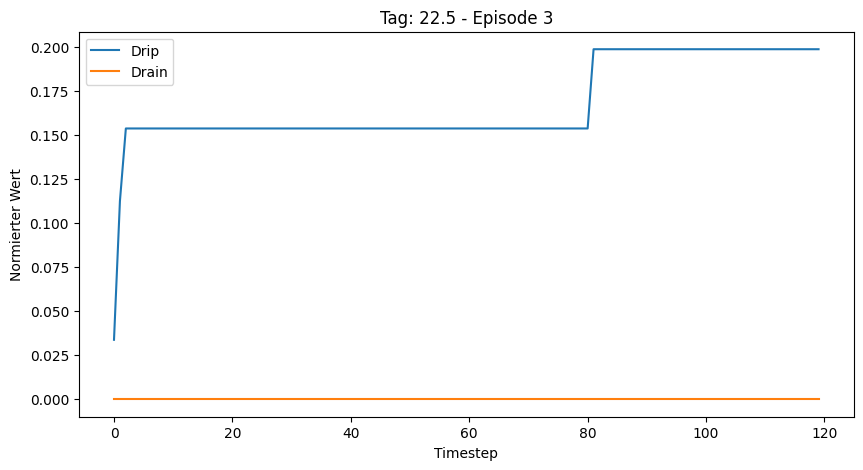

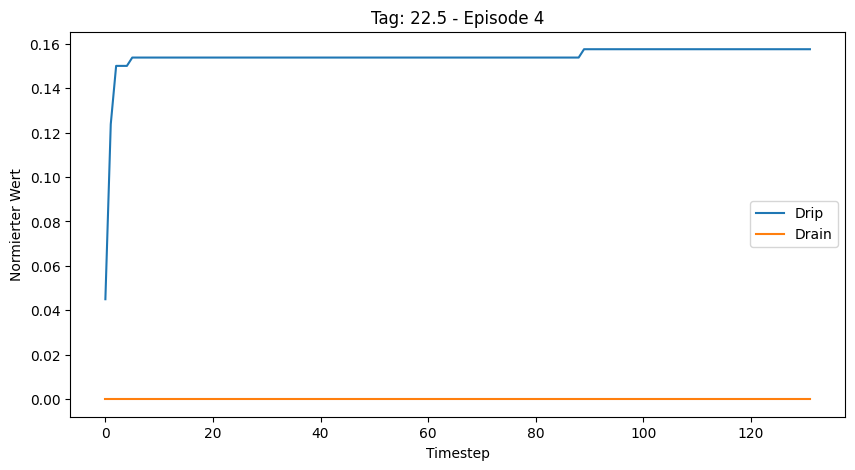

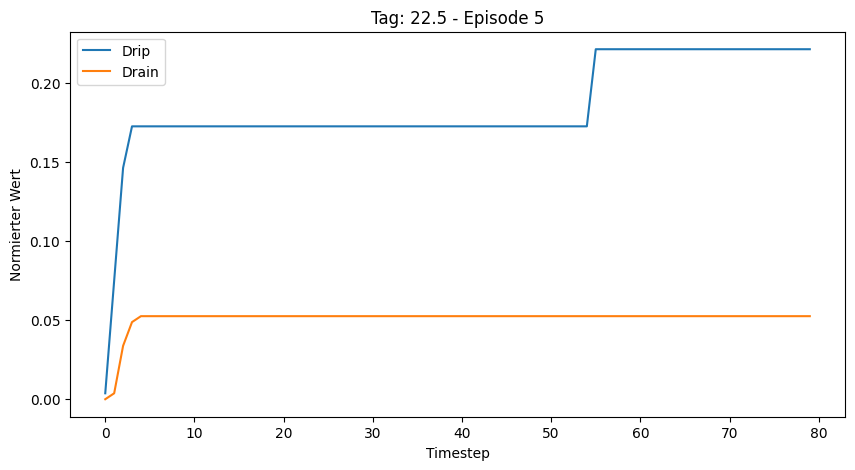

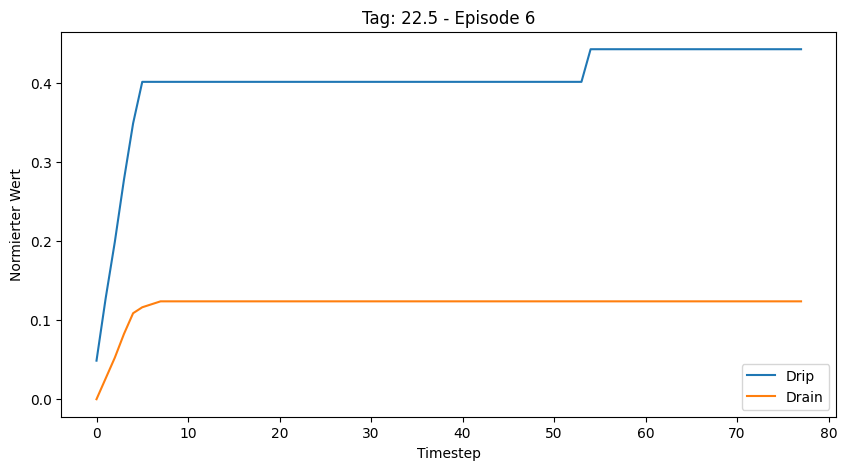

from(bucket: "SensorNodes")|> range(start: 2023-05-23T04:00:00+02:00, stop: 2023-05-23T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-23T04:00:00+02:00, stop: 2023-05-23T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-23T04:00:00+02:00, stop: 2023-05-23T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-23T04:00:00+02:00, stop: 2023-05-23T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-23T04:00:00+02:00, stop:

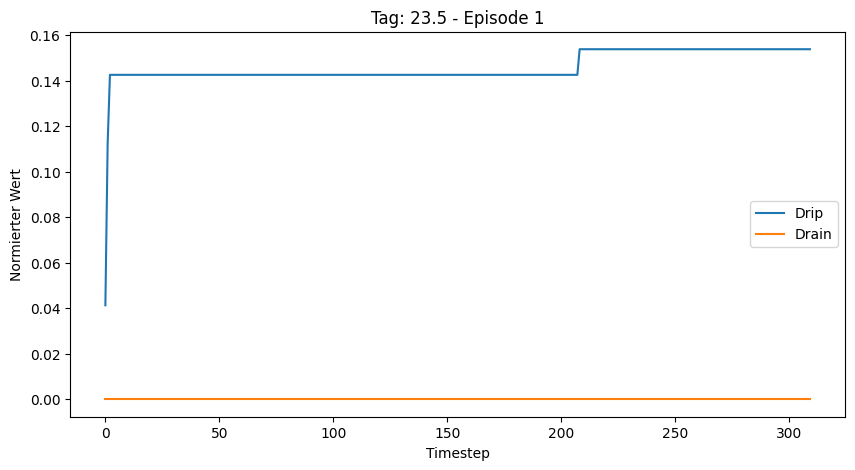

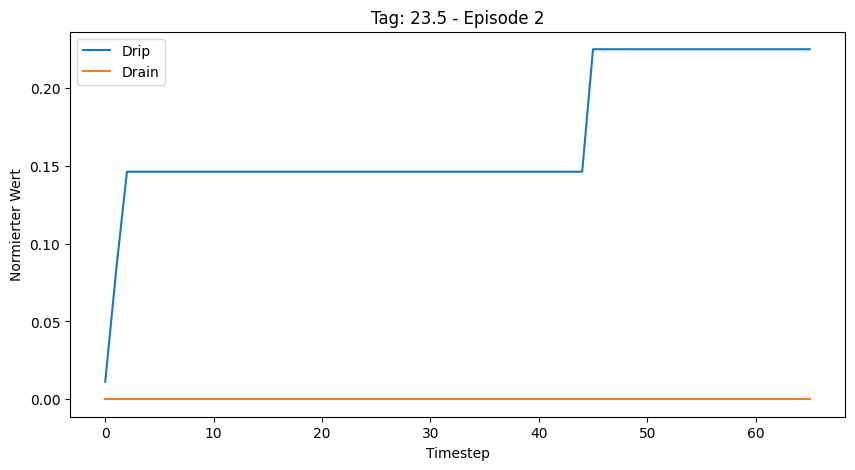

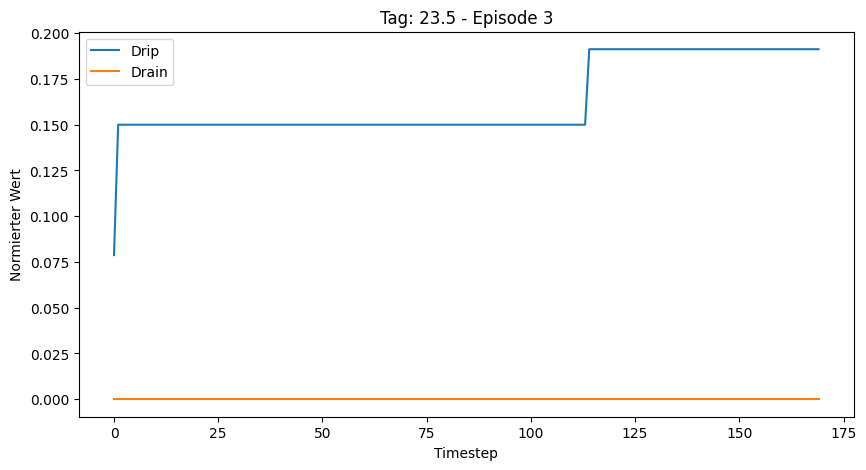

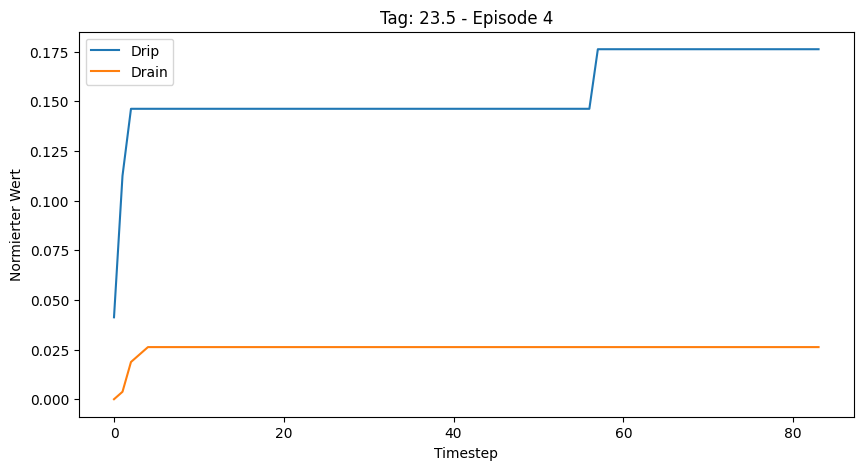

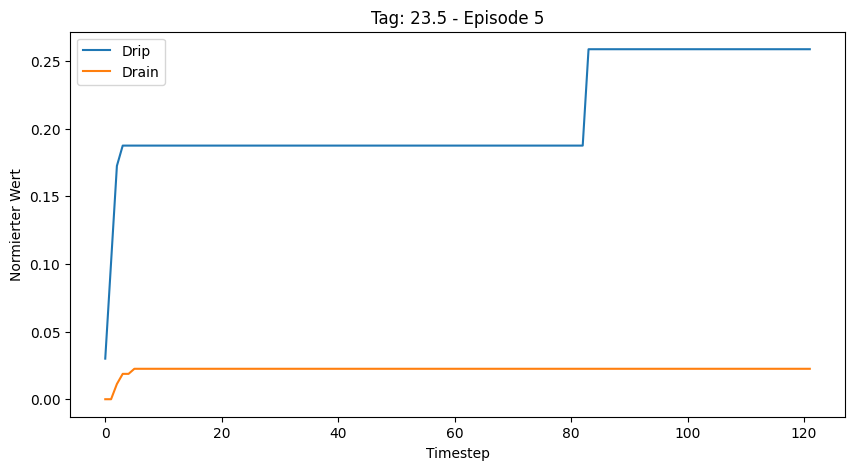

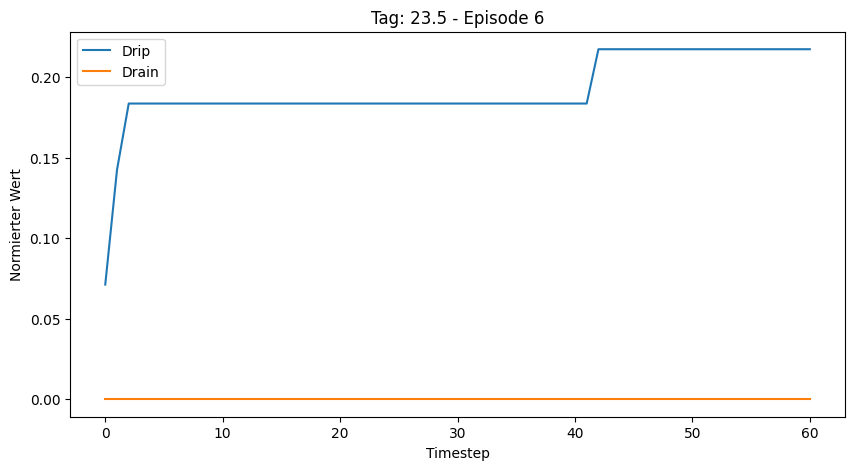

from(bucket: "SensorNodes")|> range(start: 2023-05-24T04:00:00+02:00, stop: 2023-05-24T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-24T04:00:00+02:00, stop: 2023-05-24T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-24T04:00:00+02:00, stop: 2023-05-24T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-24T04:00:00+02:00, stop: 2023-05-24T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-24T04:00:00+02:00, stop:

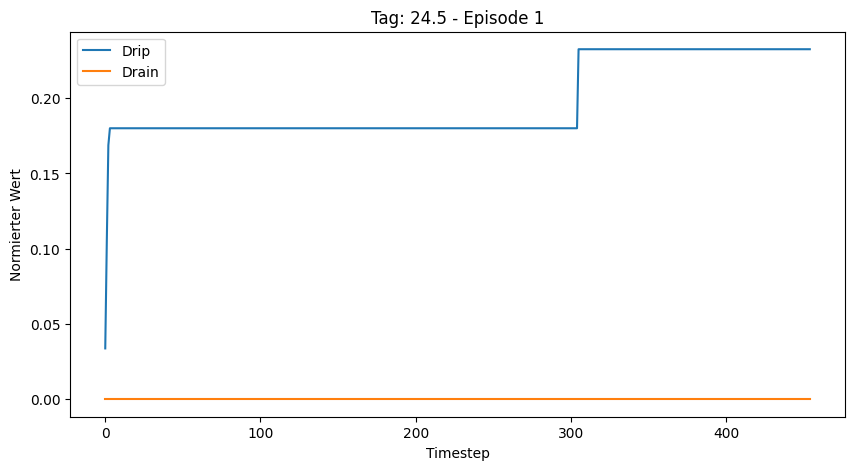

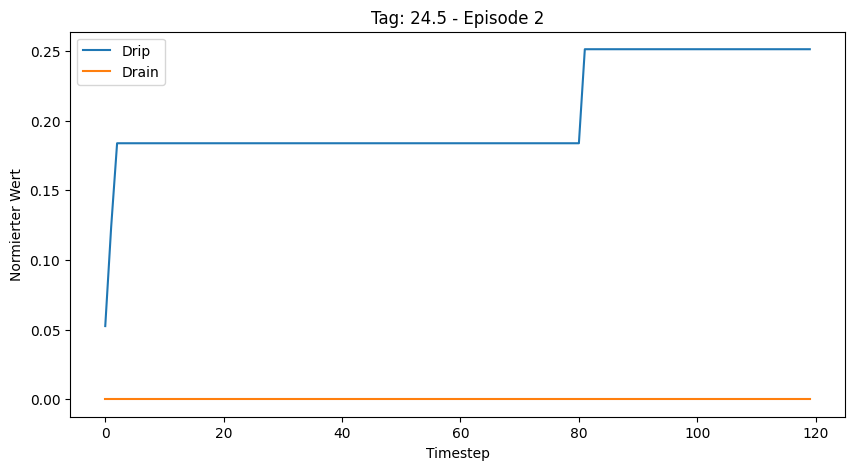

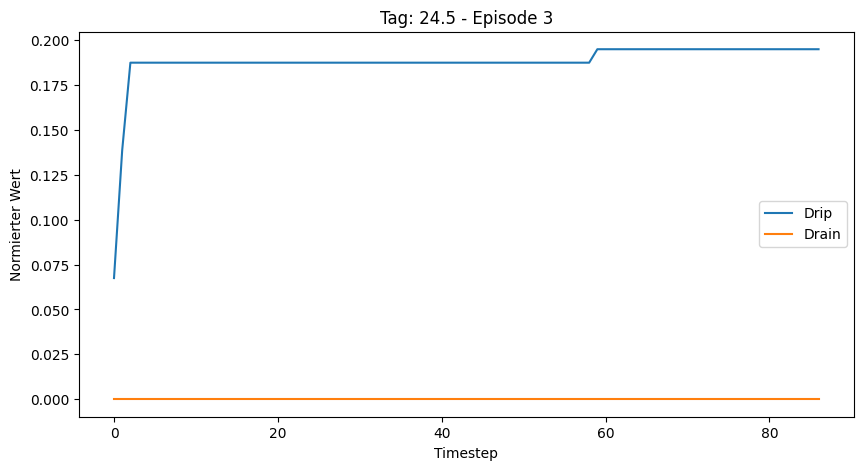

from(bucket: "SensorNodes")|> range(start: 2023-05-25T04:00:00+02:00, stop: 2023-05-25T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-25T04:00:00+02:00, stop: 2023-05-25T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-25T04:00:00+02:00, stop: 2023-05-25T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-25T04:00:00+02:00, stop: 2023-05-25T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-25T04:00:00+02:00, stop:

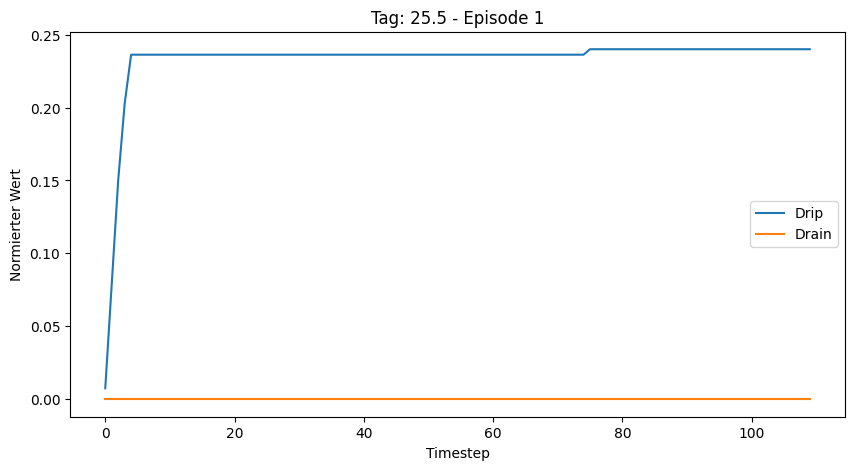

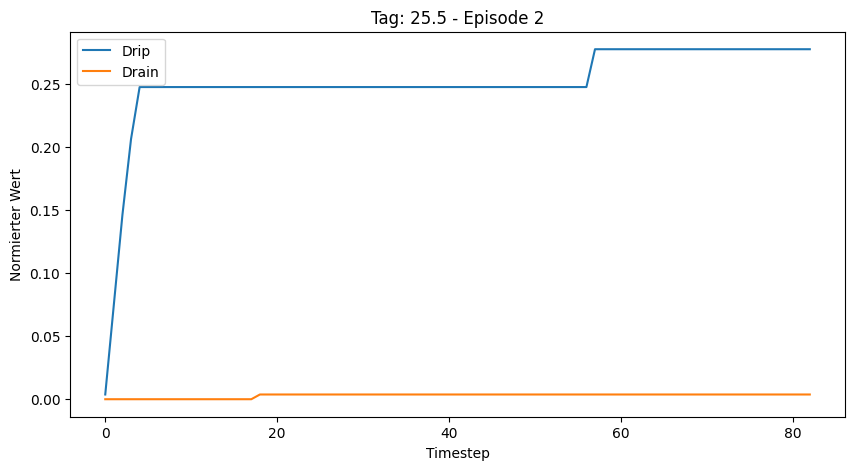

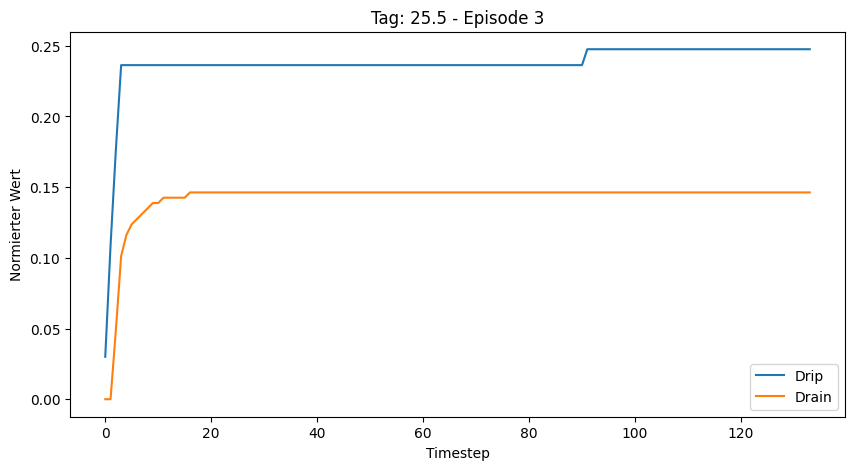

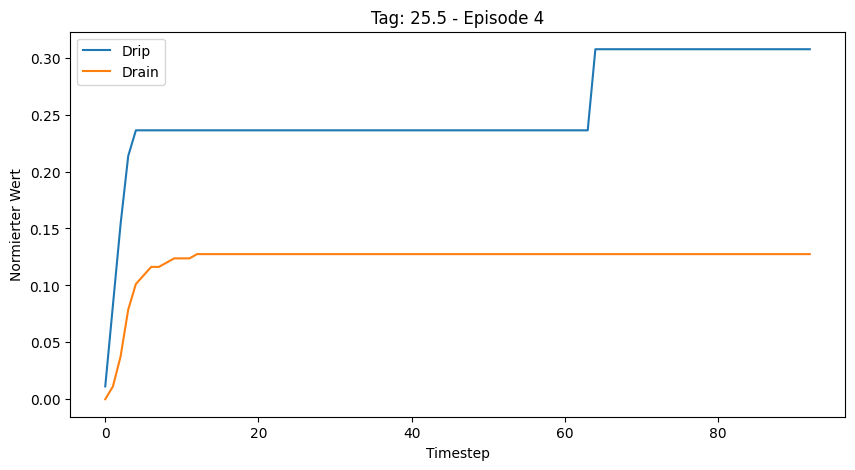

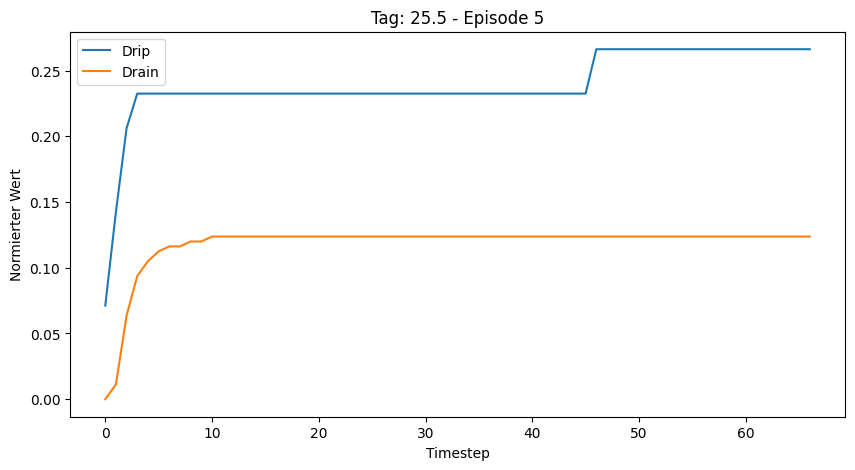

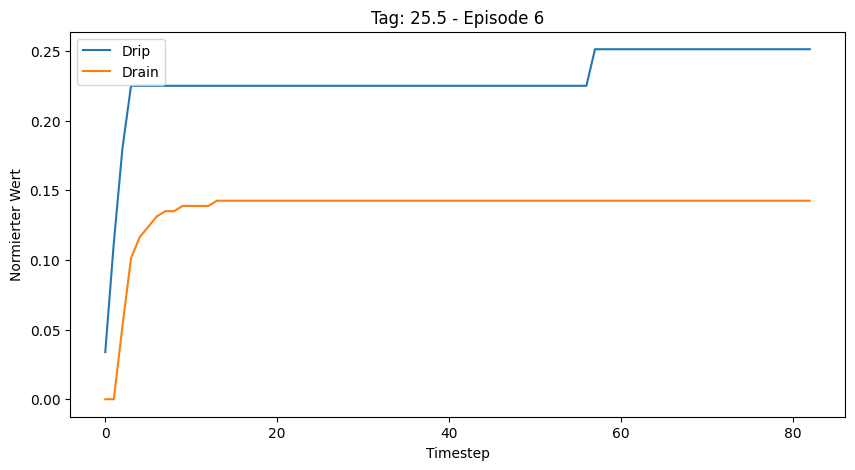

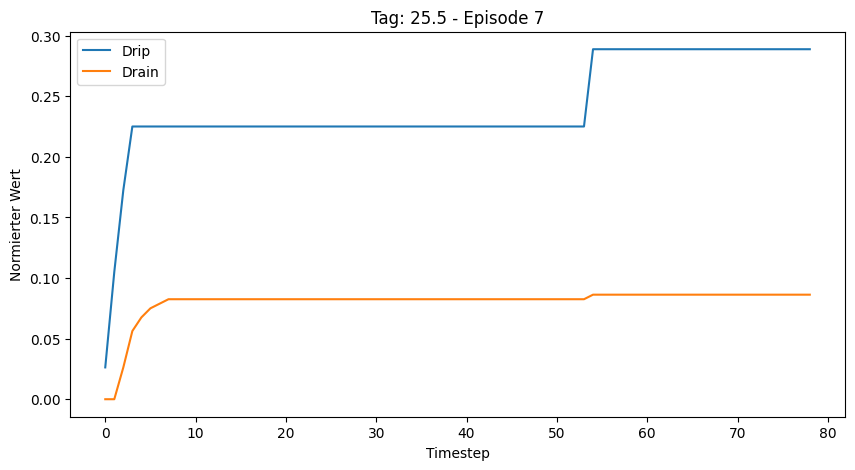

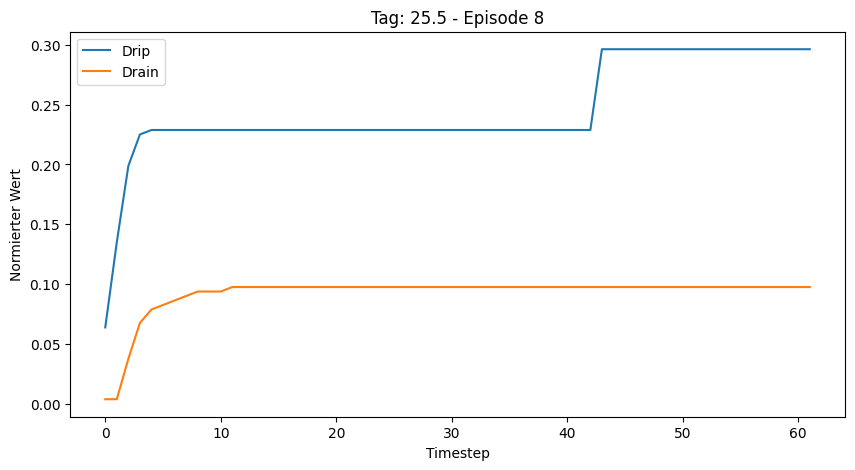

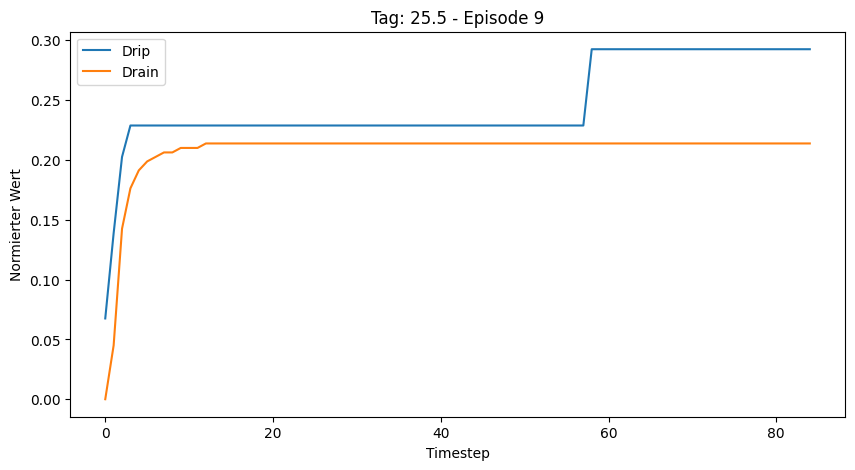

from(bucket: "SensorNodes")|> range(start: 2023-05-26T04:00:00+02:00, stop: 2023-05-26T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-26T04:00:00+02:00, stop: 2023-05-26T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-26T04:00:00+02:00, stop: 2023-05-26T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-26T04:00:00+02:00, stop: 2023-05-26T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-26T04:00:00+02:00, stop:

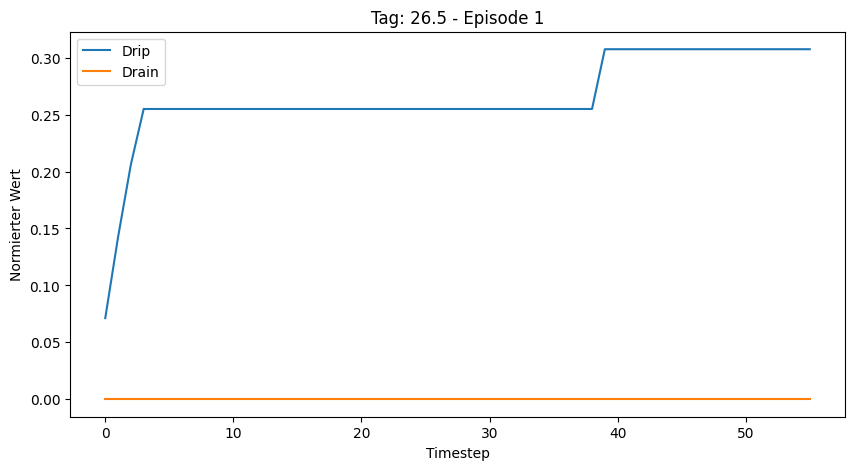

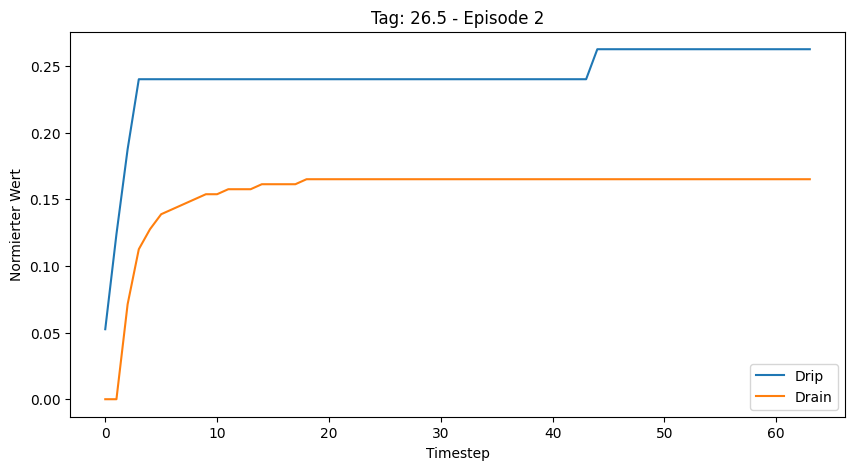

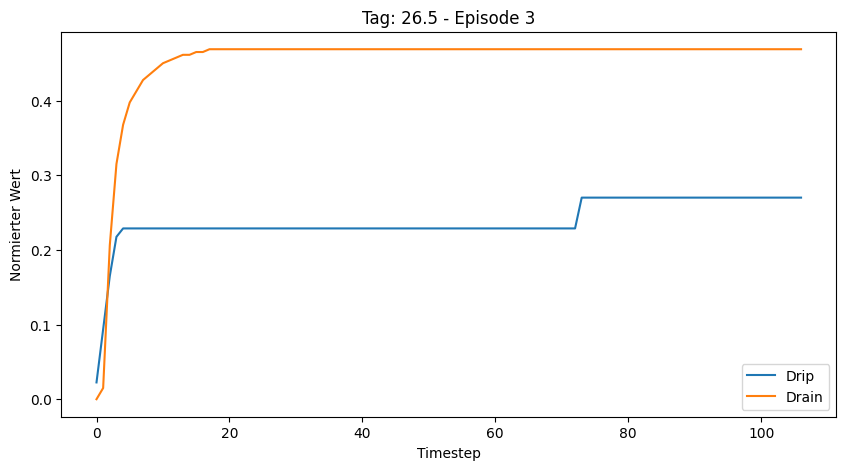

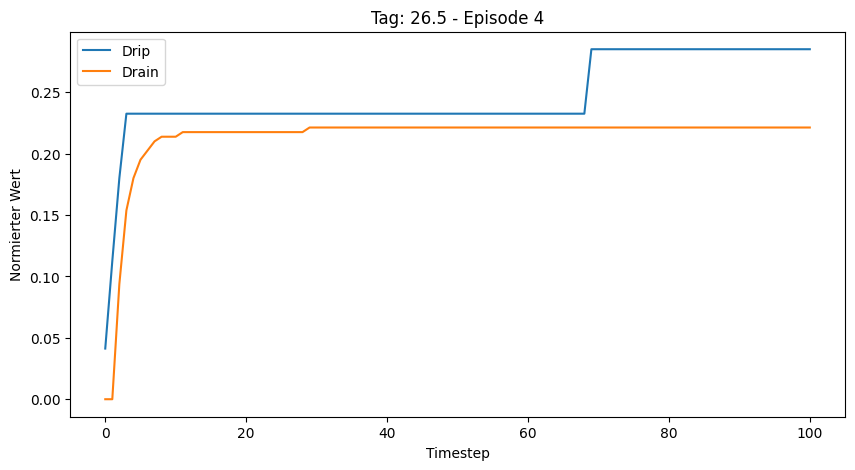

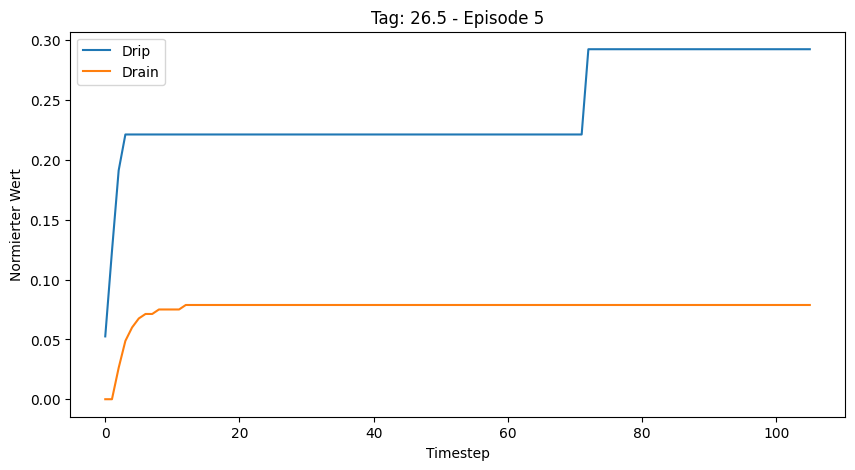

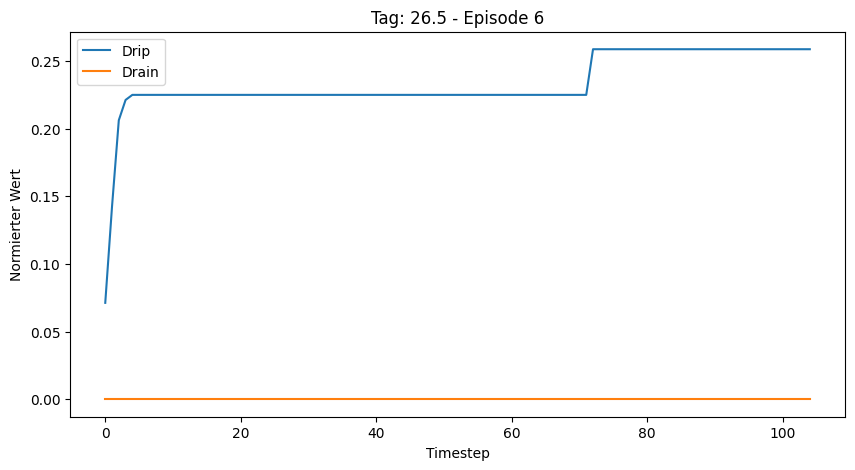

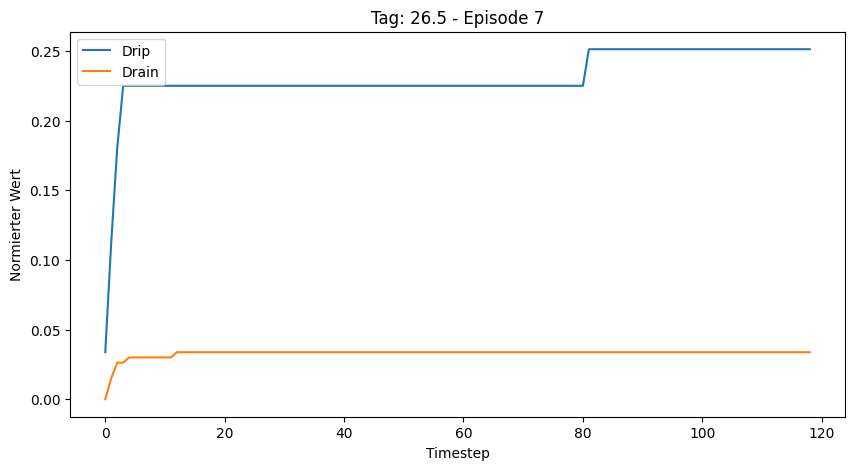

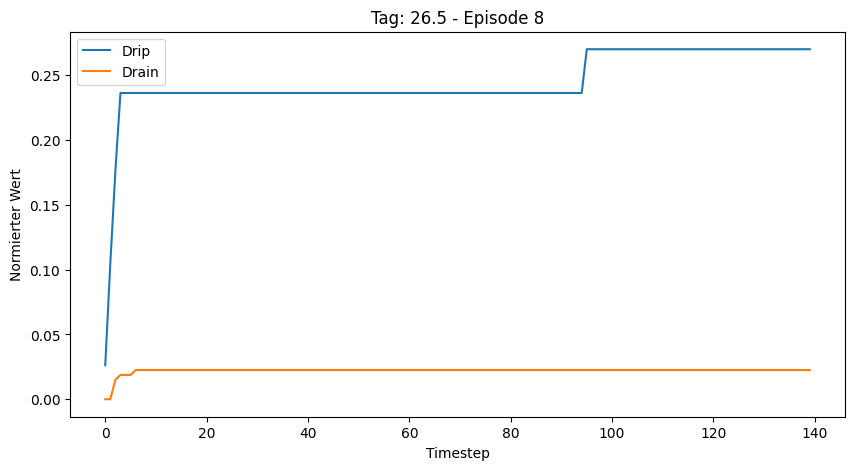

from(bucket: "SensorNodes")|> range(start: 2023-05-27T04:00:00+02:00, stop: 2023-05-27T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-27T04:00:00+02:00, stop: 2023-05-27T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-27T04:00:00+02:00, stop: 2023-05-27T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-27T04:00:00+02:00, stop: 2023-05-27T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-27T04:00:00+02:00, stop:

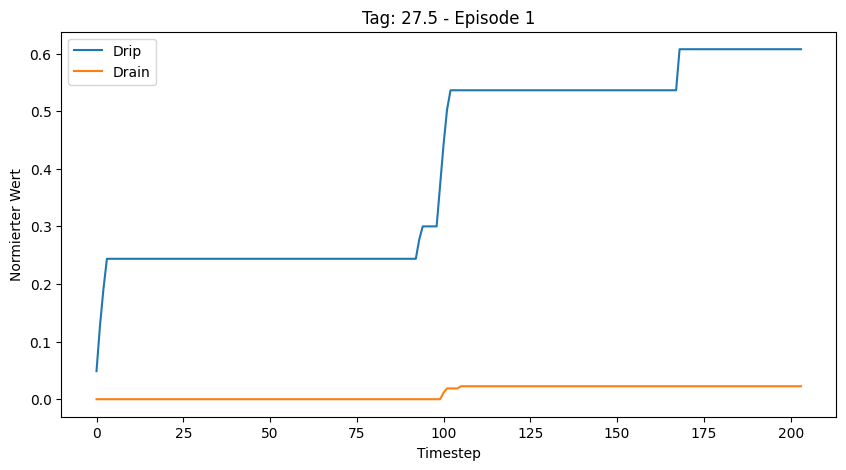

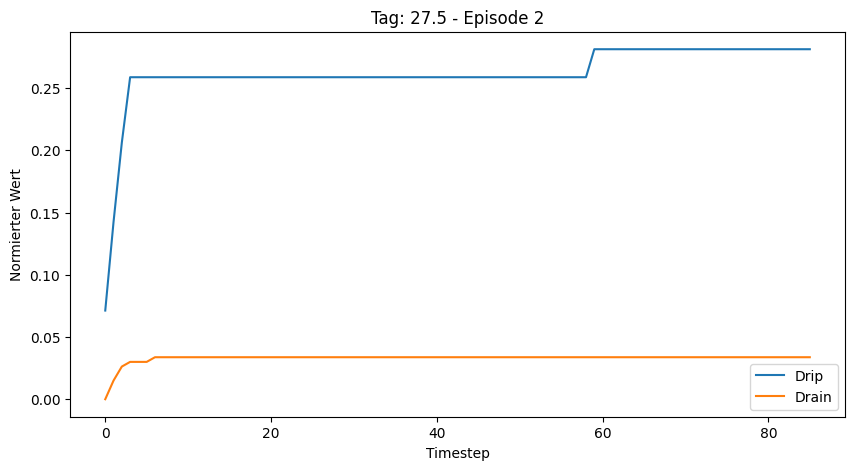

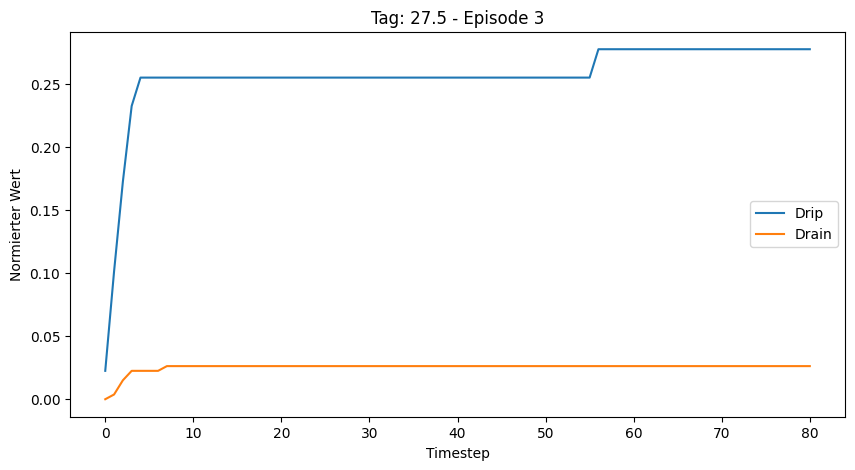

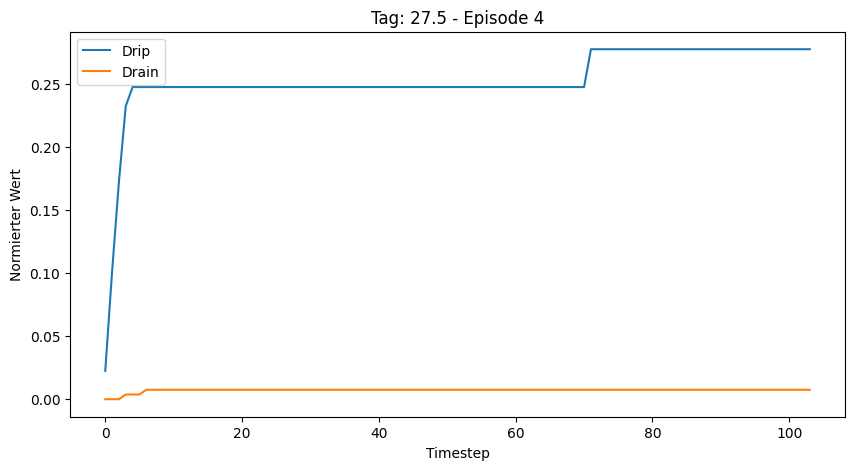

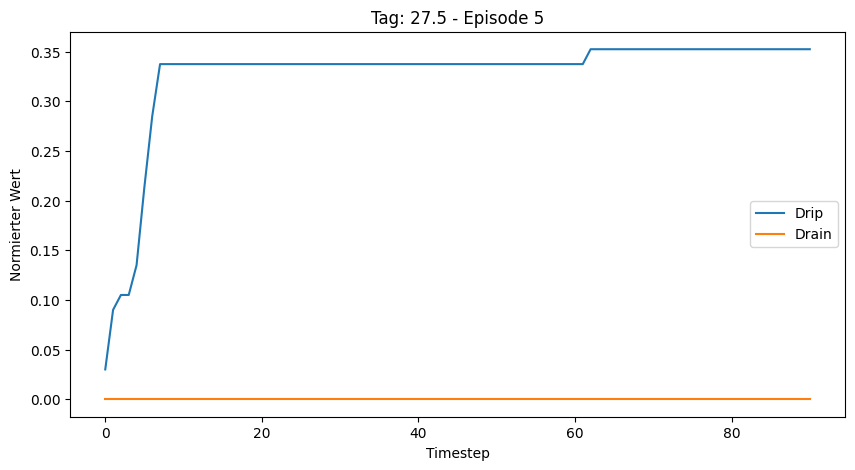

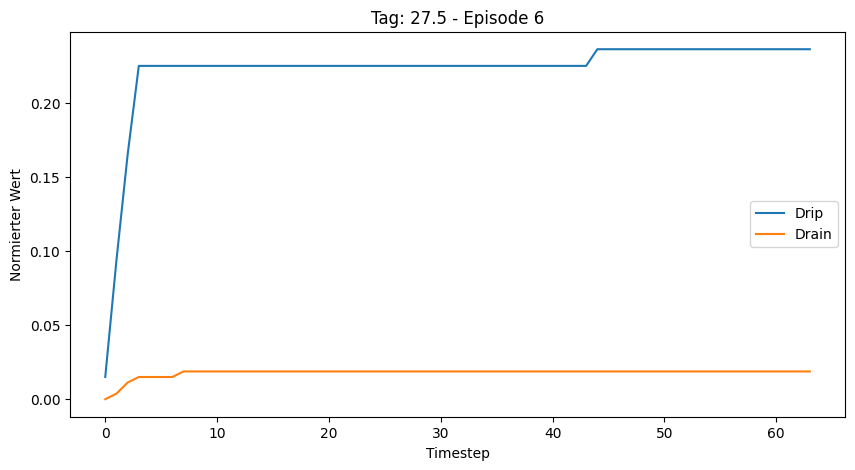

from(bucket: "SensorNodes")|> range(start: 2023-05-28T04:00:00+02:00, stop: 2023-05-28T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-28T04:00:00+02:00, stop: 2023-05-28T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-28T04:00:00+02:00, stop: 2023-05-28T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-28T04:00:00+02:00, stop: 2023-05-28T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-28T04:00:00+02:00, stop:

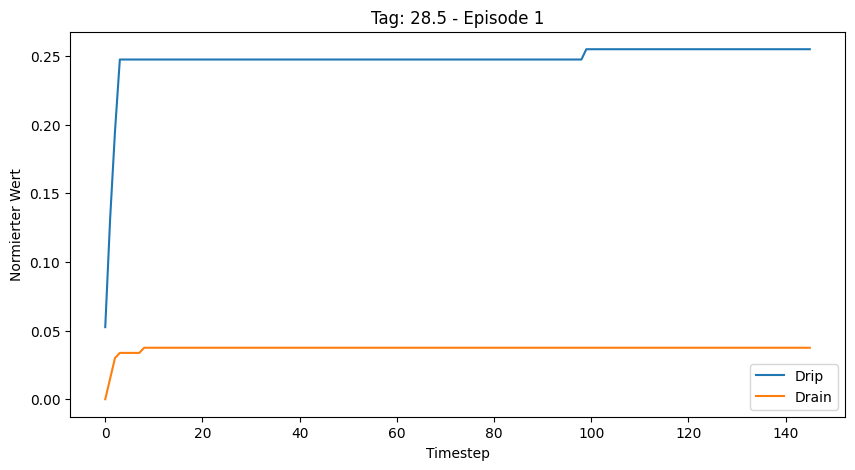

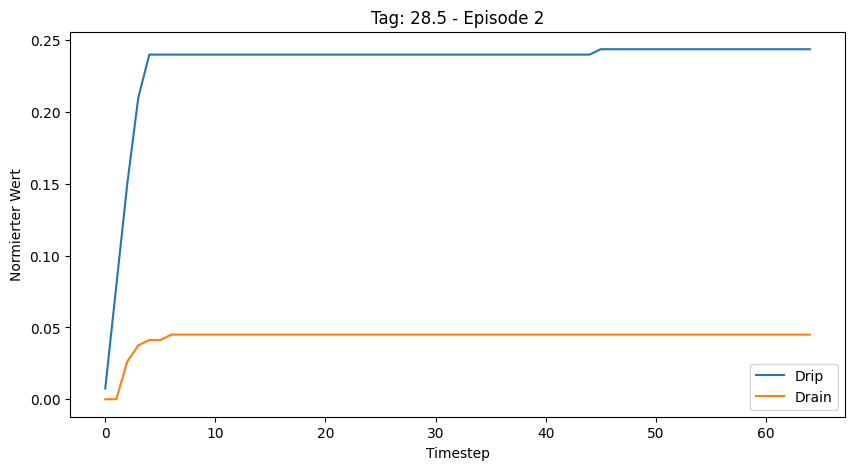

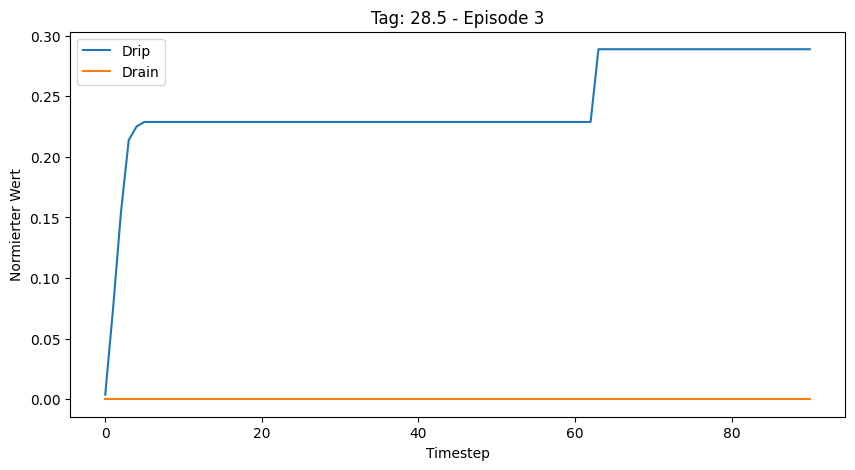

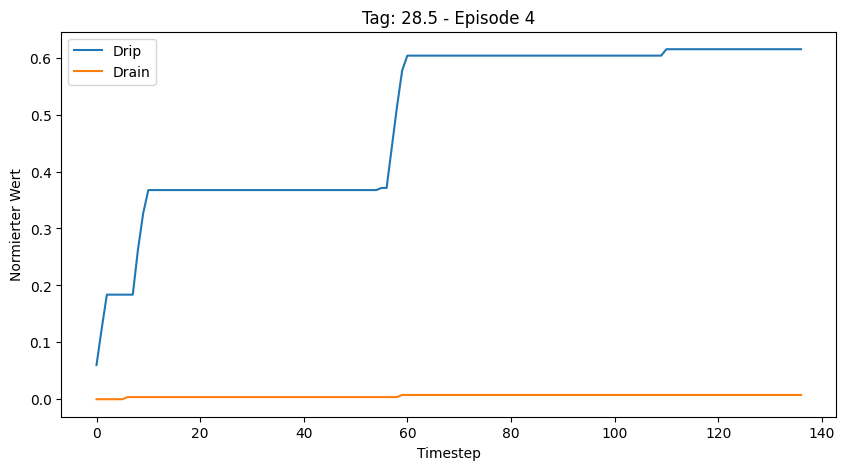

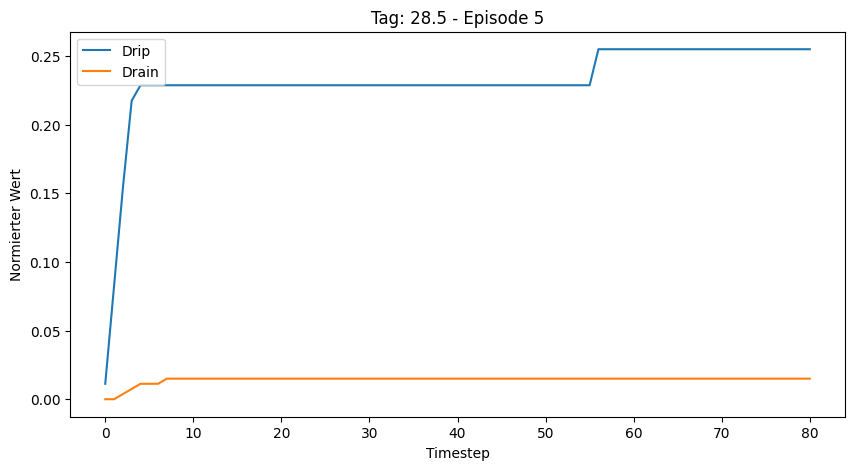

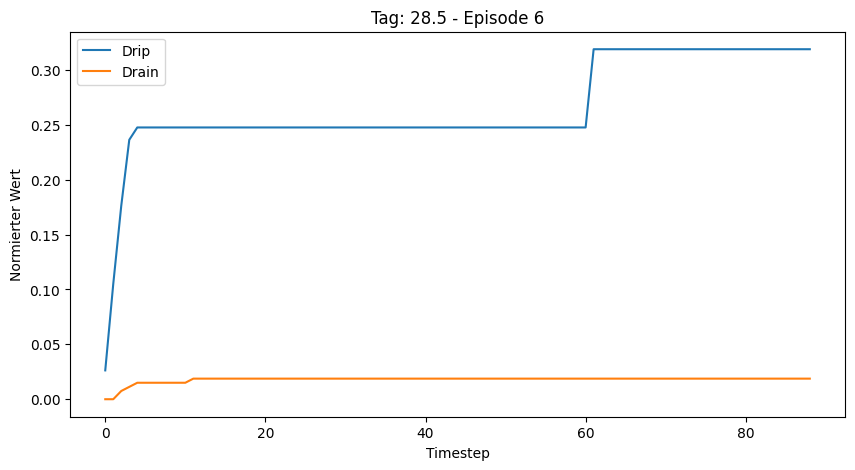

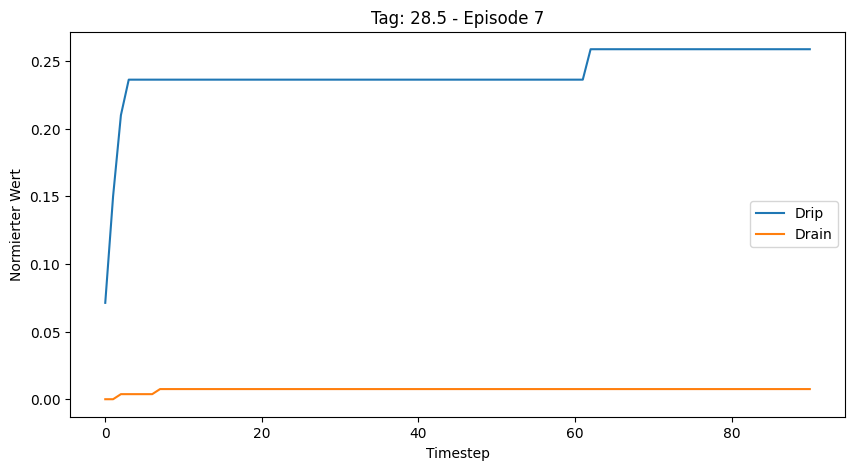

from(bucket: "SensorNodes")|> range(start: 2023-05-29T04:00:00+02:00, stop: 2023-05-29T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-29T04:00:00+02:00, stop: 2023-05-29T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-29T04:00:00+02:00, stop: 2023-05-29T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-29T04:00:00+02:00, stop: 2023-05-29T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-29T04:00:00+02:00, stop:

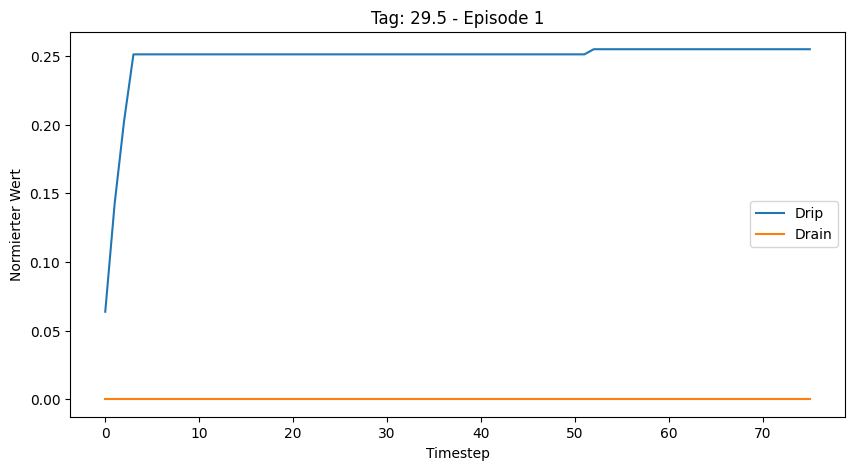

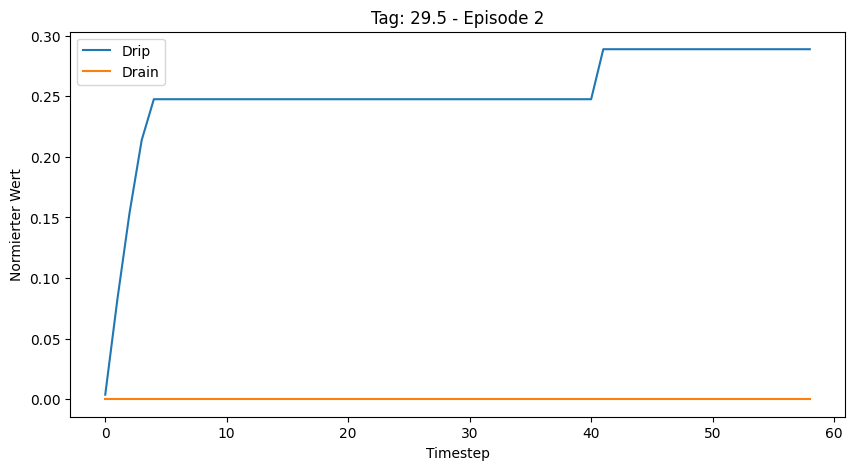

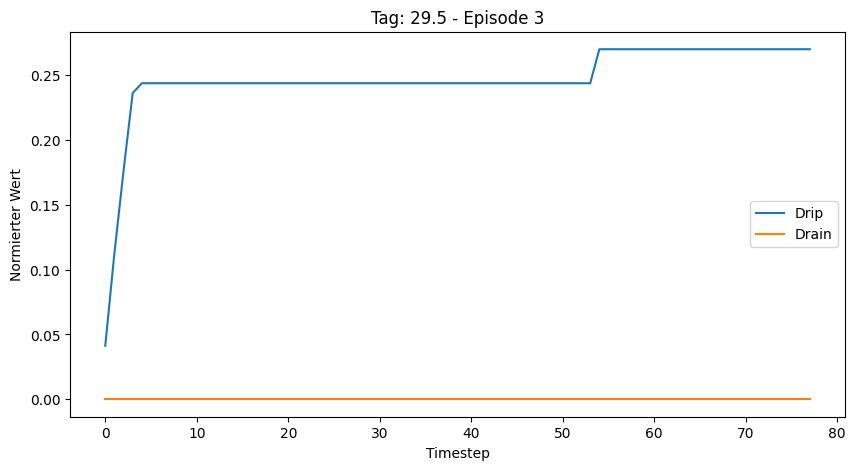

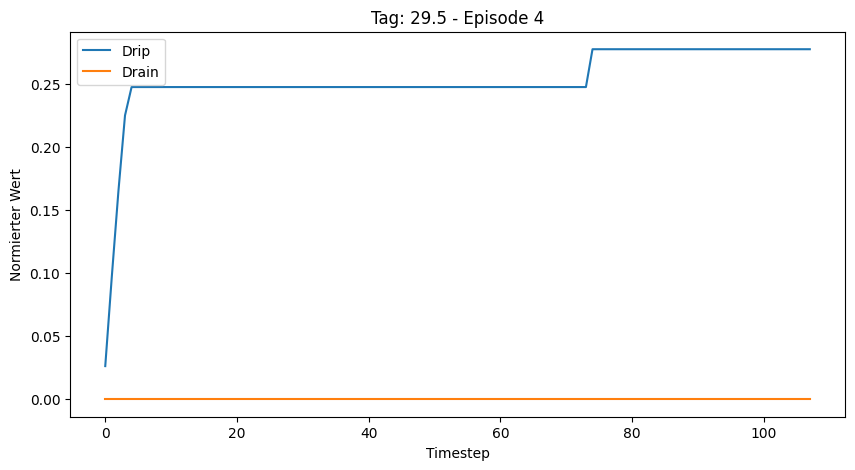

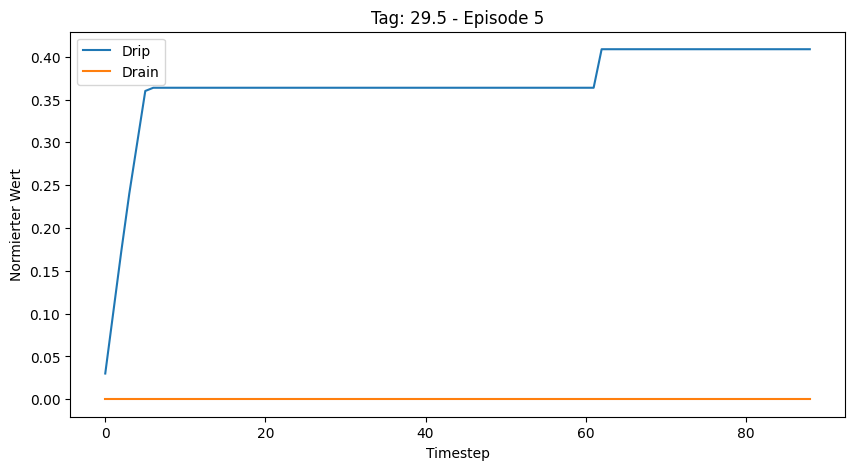

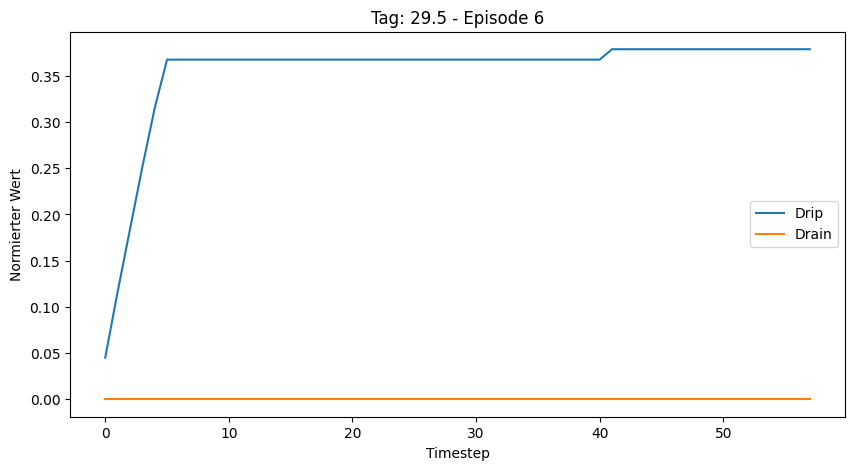

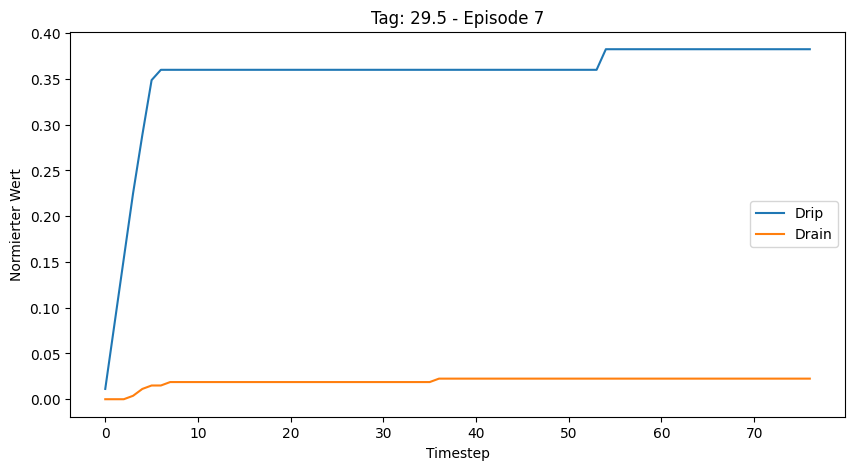

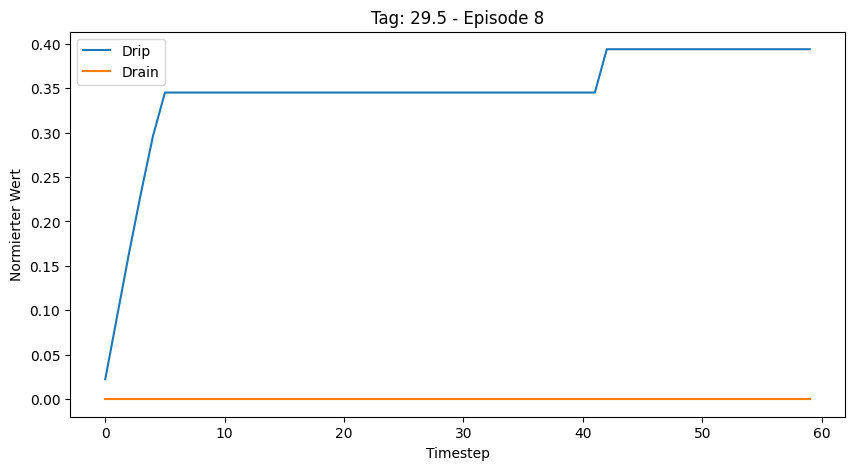

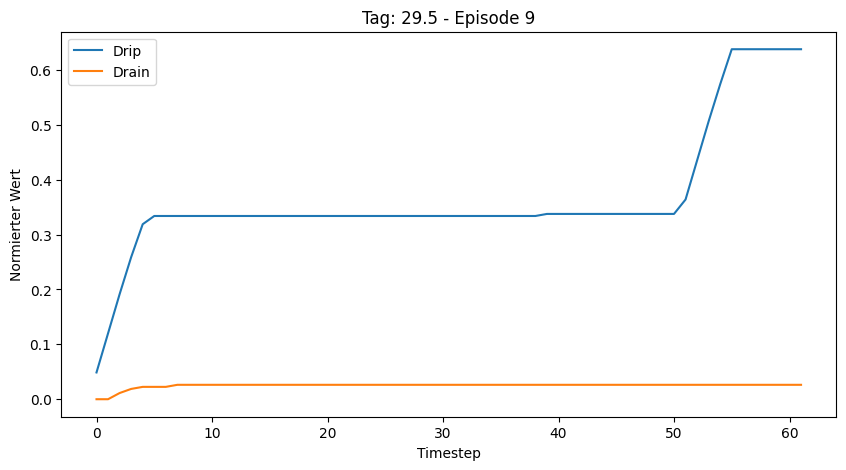

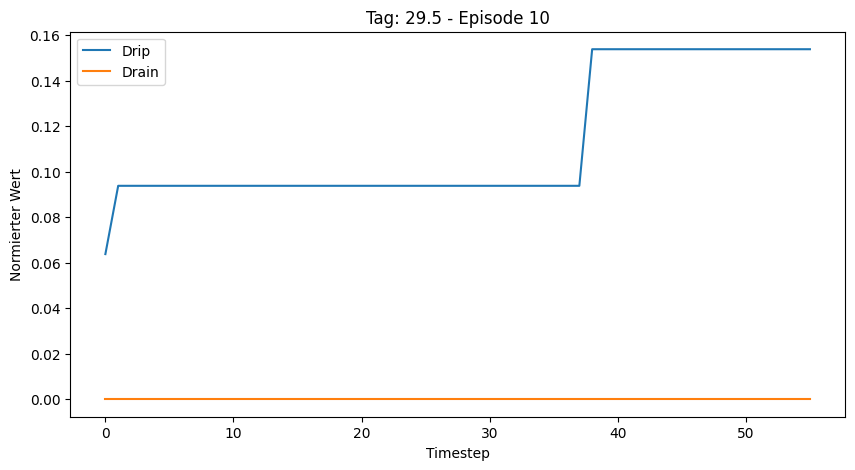

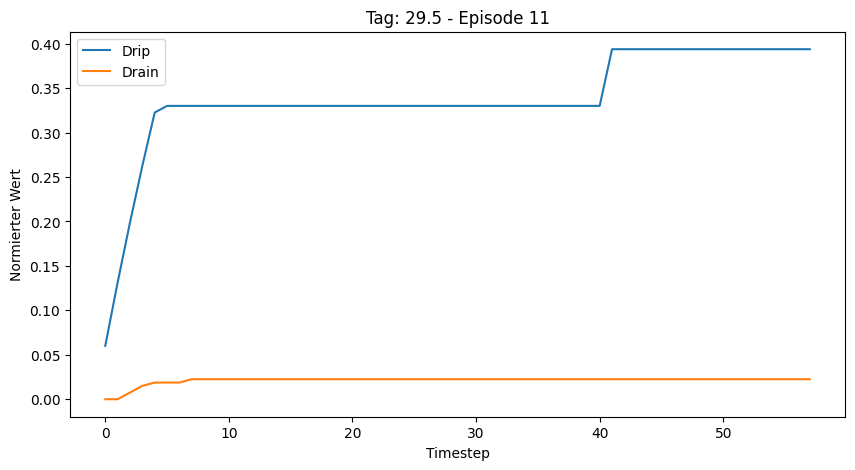

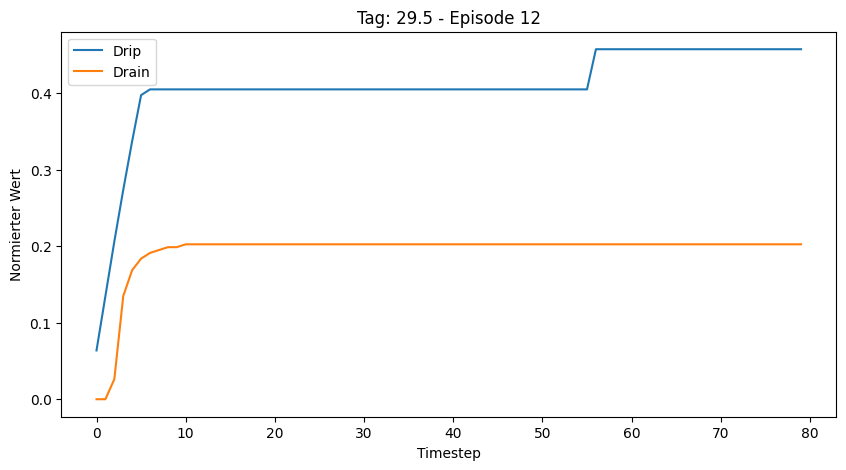

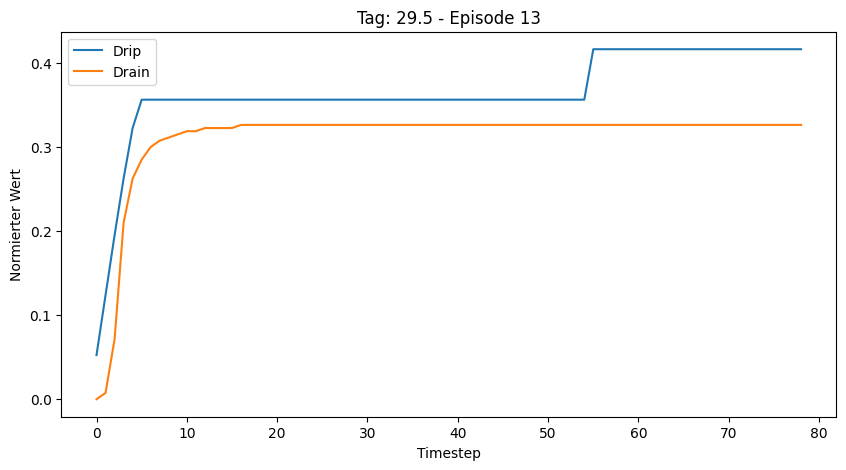

from(bucket: "SensorNodes")|> range(start: 2023-05-30T04:00:00+02:00, stop: 2023-05-30T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-30T04:00:00+02:00, stop: 2023-05-30T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-30T04:00:00+02:00, stop: 2023-05-30T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-30T04:00:00+02:00, stop: 2023-05-30T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-30T04:00:00+02:00, stop:

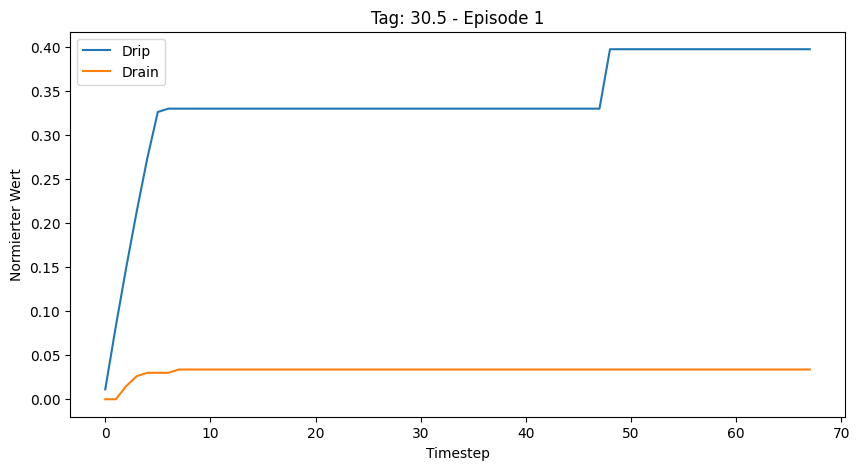

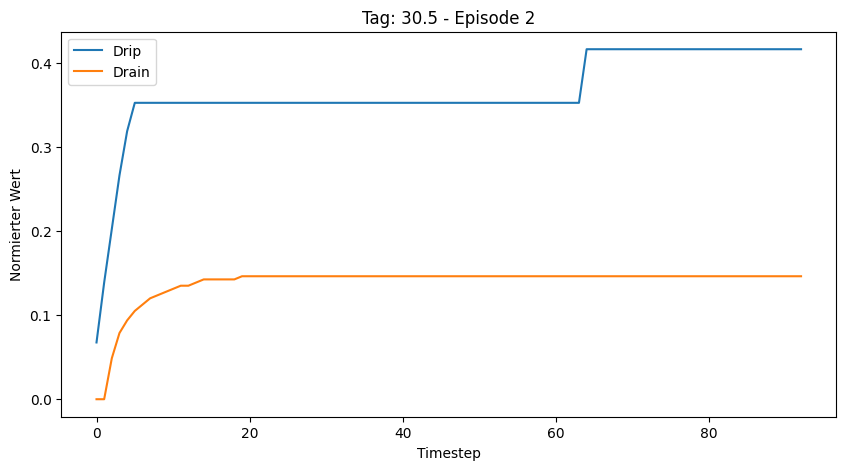

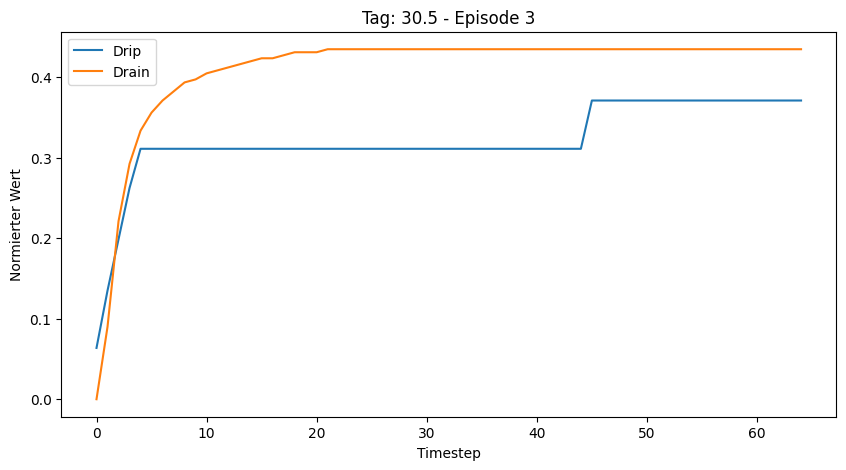

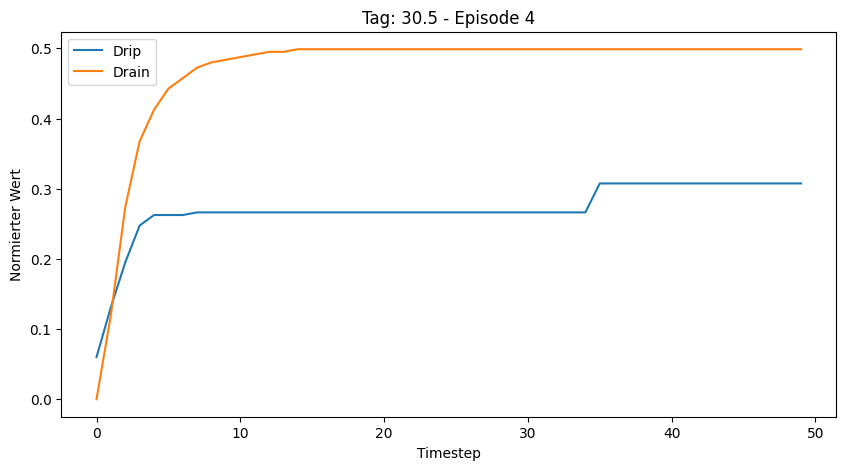

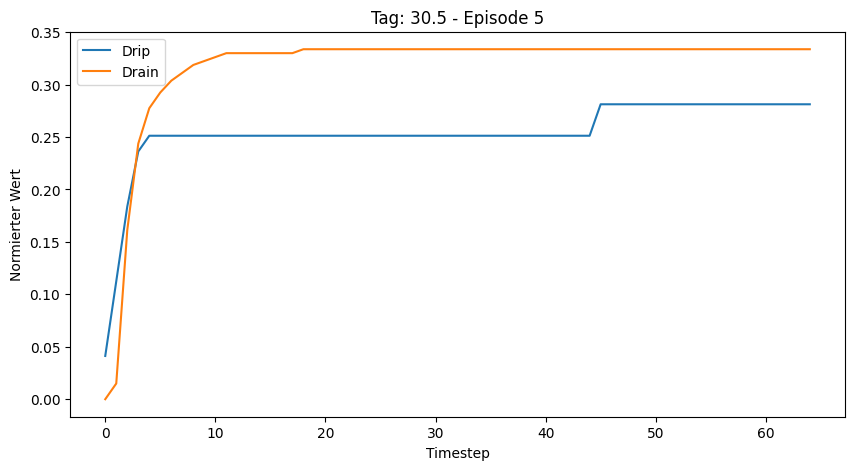

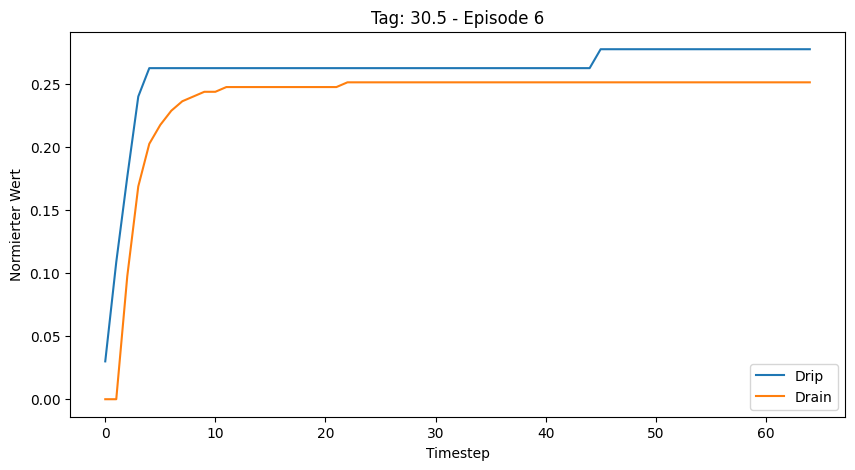

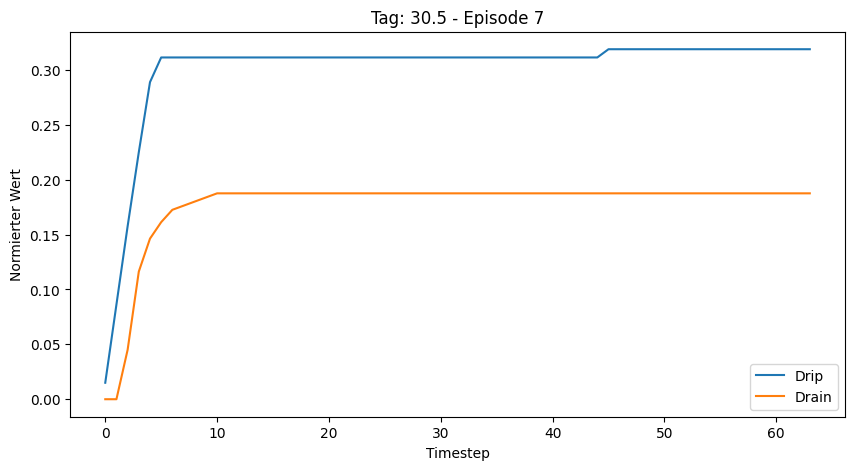

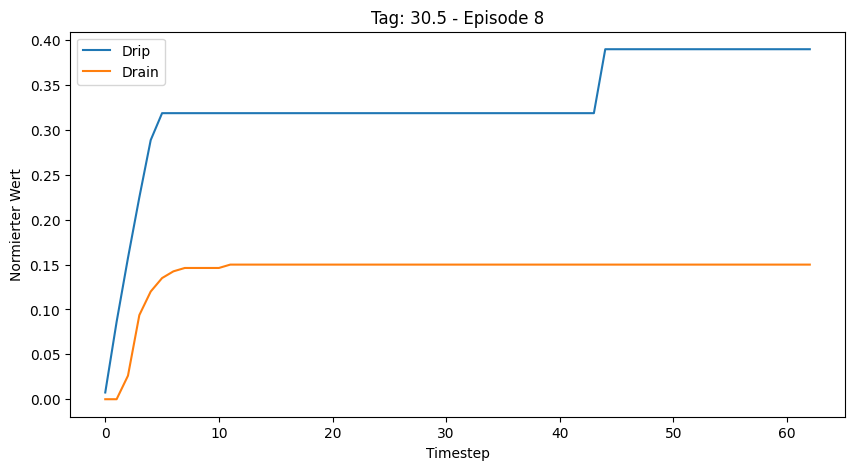

from(bucket: "SensorNodes")|> range(start: 2023-05-31T04:00:00+02:00, stop: 2023-05-31T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-05-31T04:00:00+02:00, stop: 2023-05-31T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-05-31T04:00:00+02:00, stop: 2023-05-31T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-05-31T04:00:00+02:00, stop: 2023-05-31T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-05-31T04:00:00+02:00, stop:

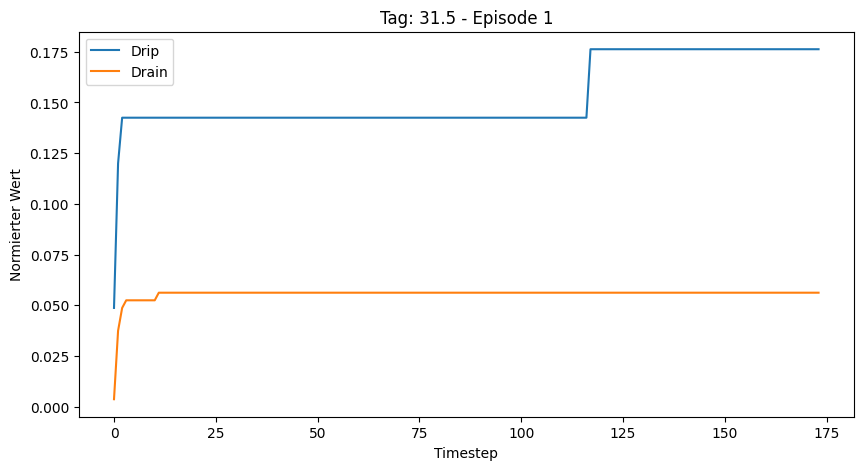

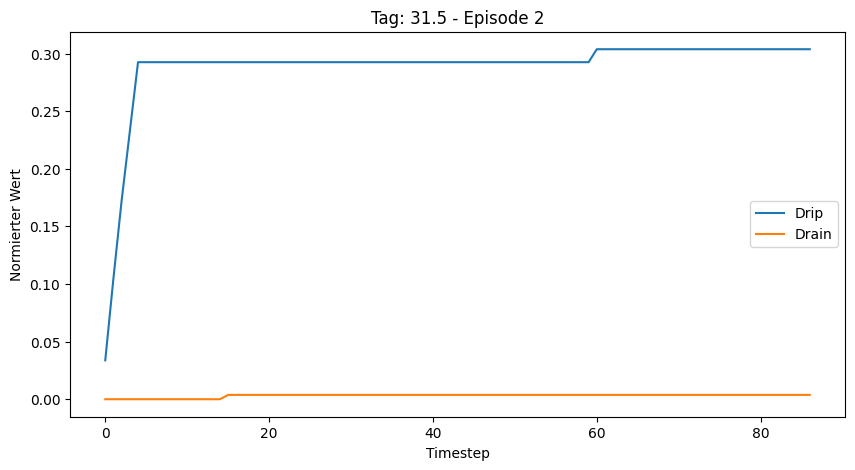

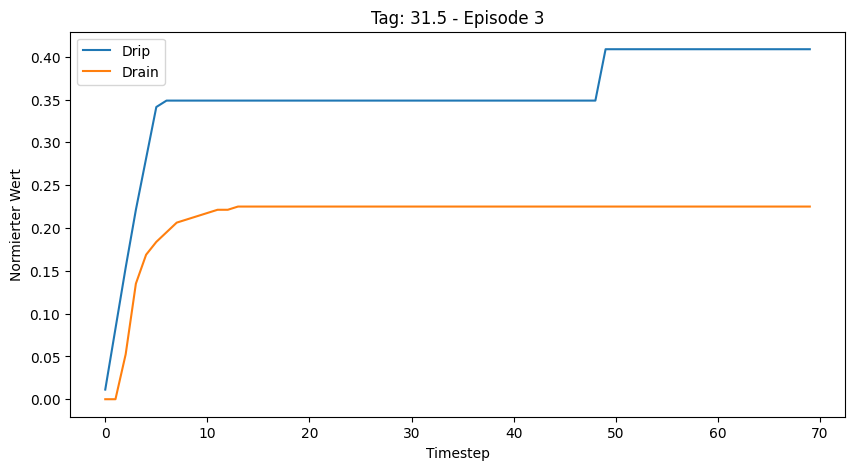

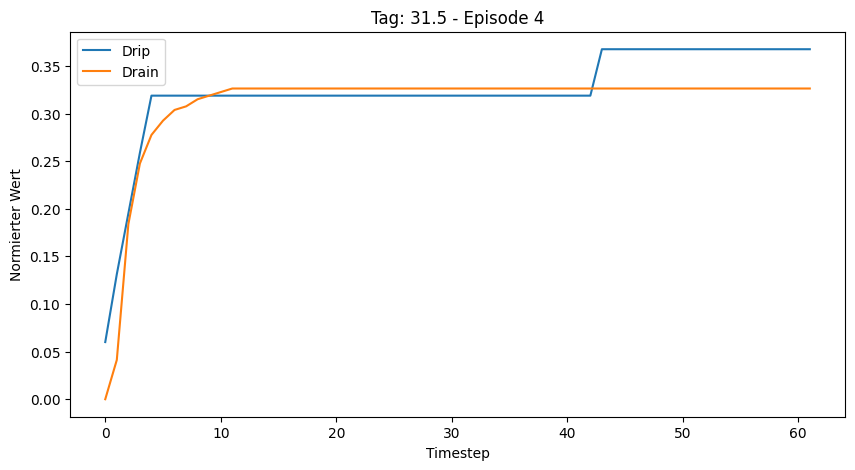

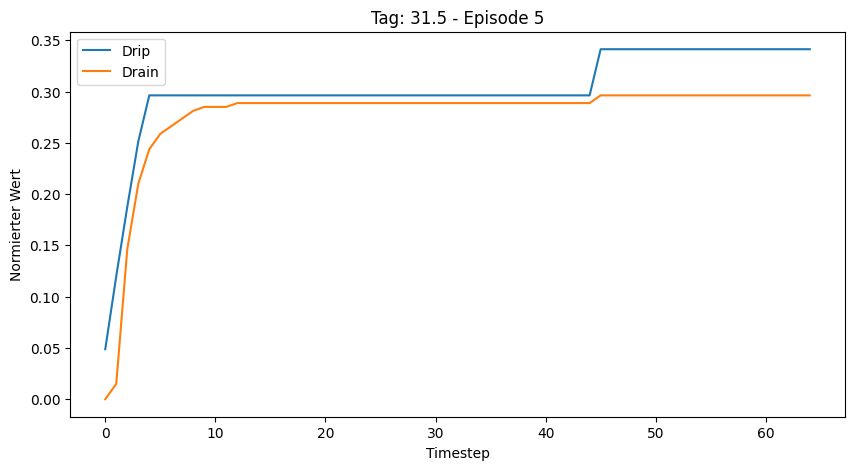

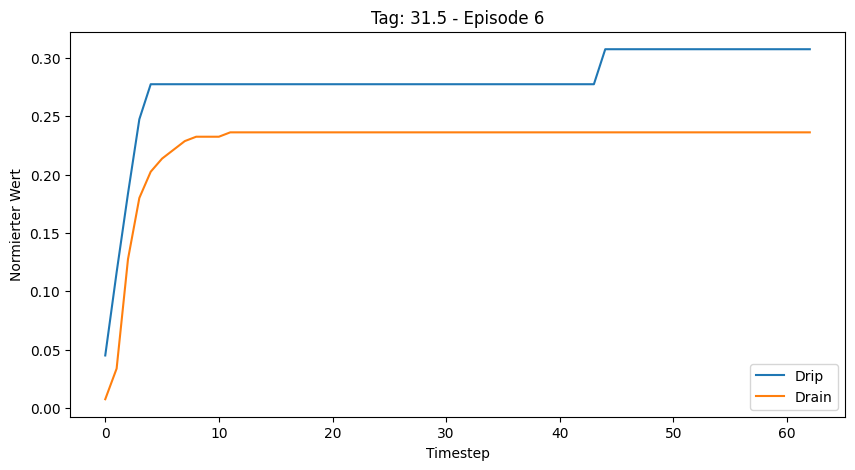

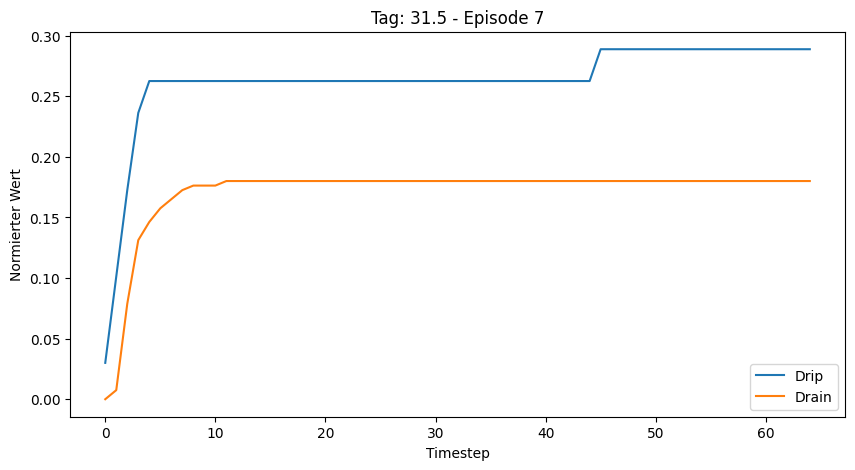

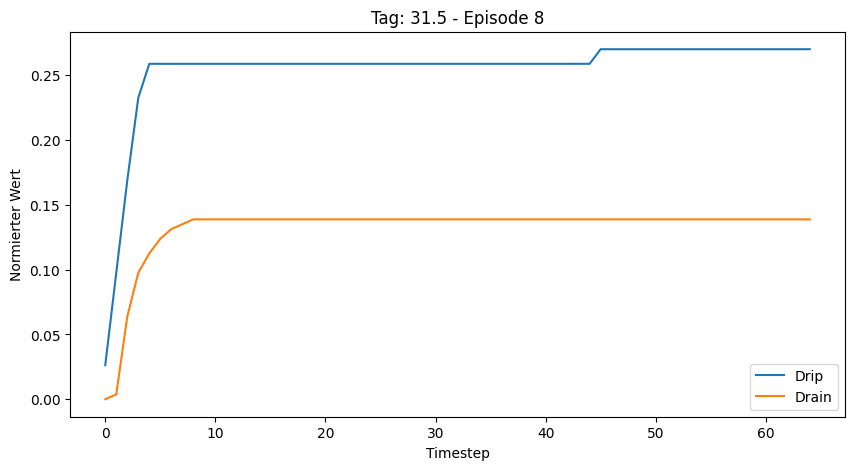

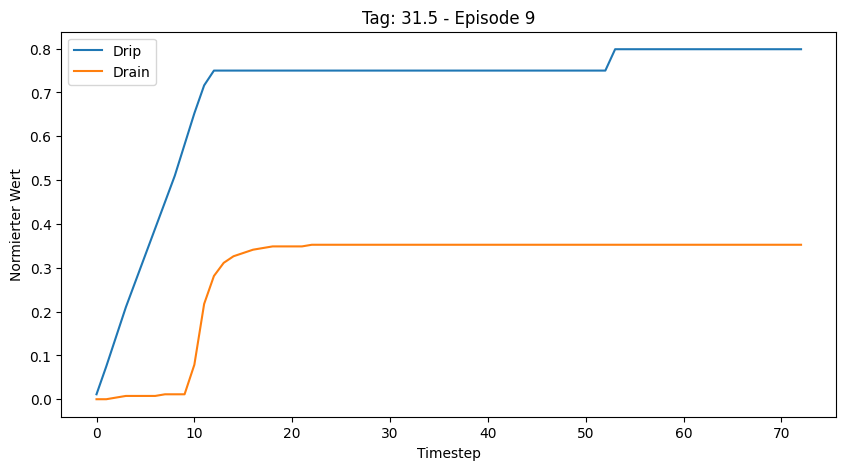

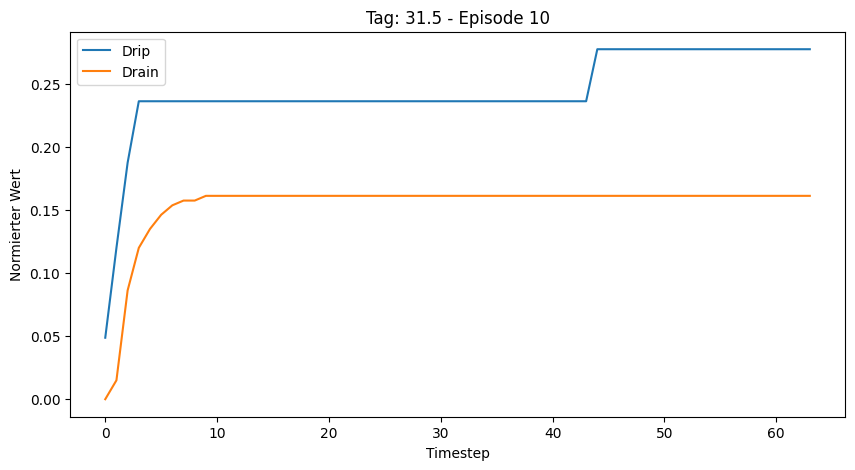

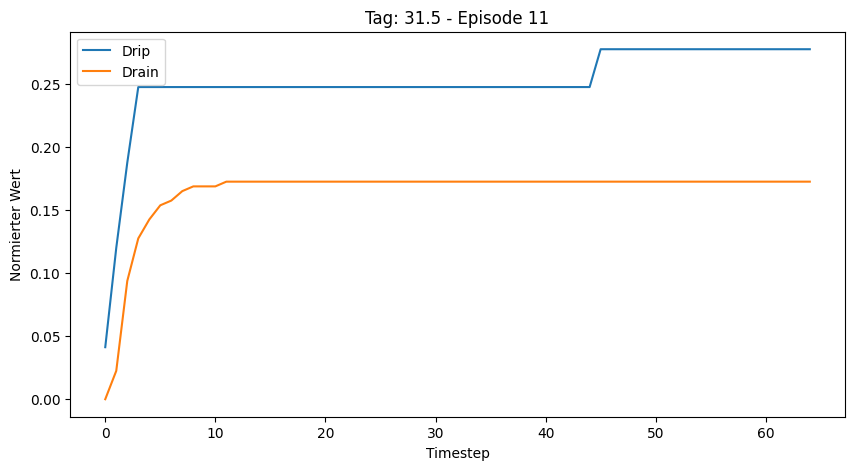

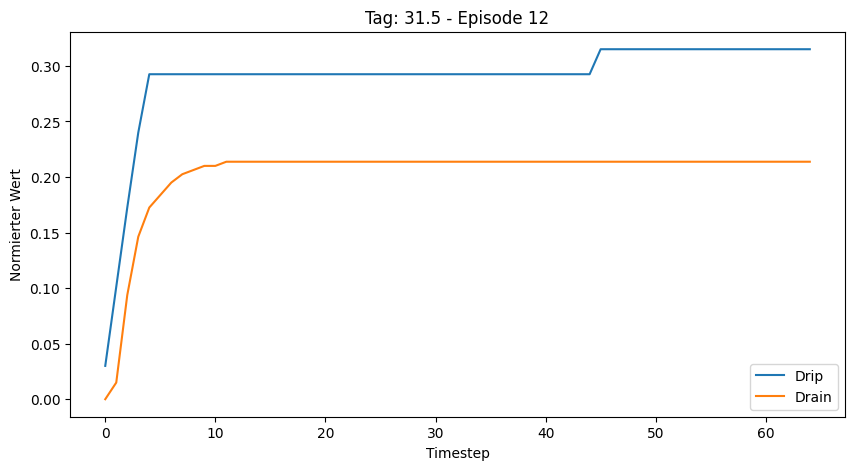

from(bucket: "SensorNodes")|> range(start: 2023-06-02T04:00:00+02:00, stop: 2023-06-02T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-02T04:00:00+02:00, stop: 2023-06-02T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-02T04:00:00+02:00, stop: 2023-06-02T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-02T04:00:00+02:00, stop: 2023-06-02T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-02T04:00:00+02:00, stop:

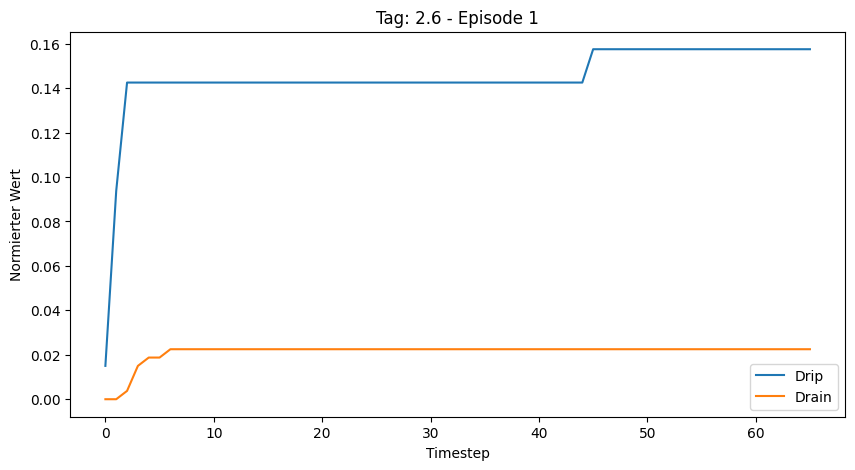

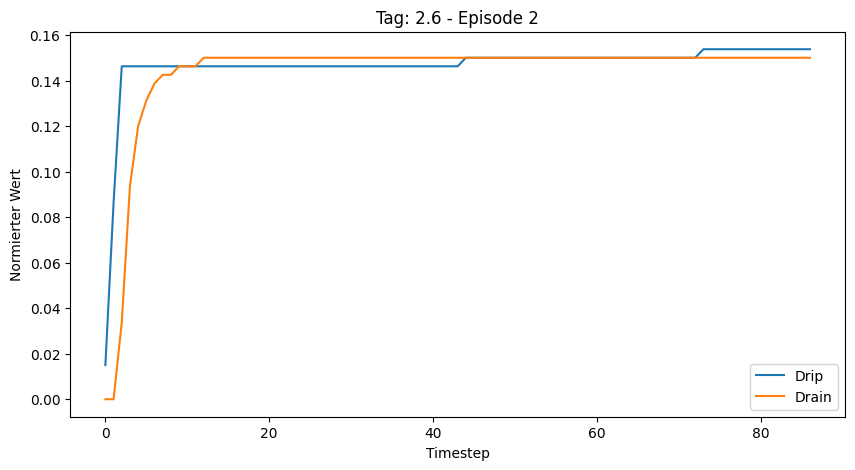

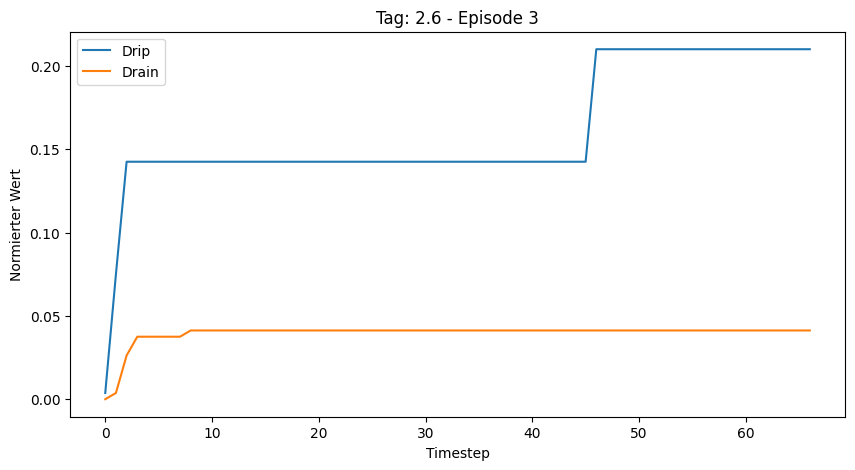

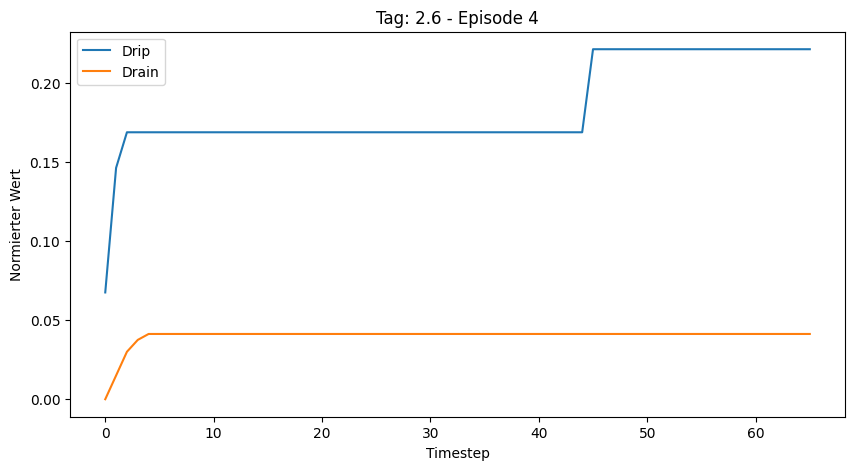

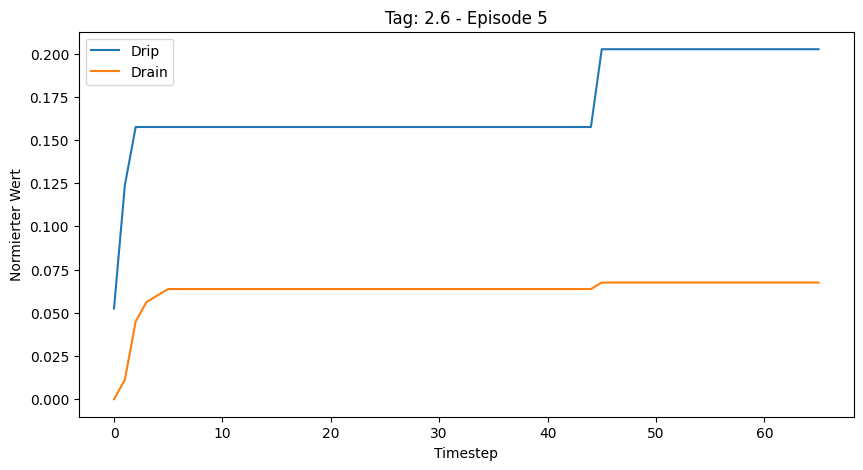

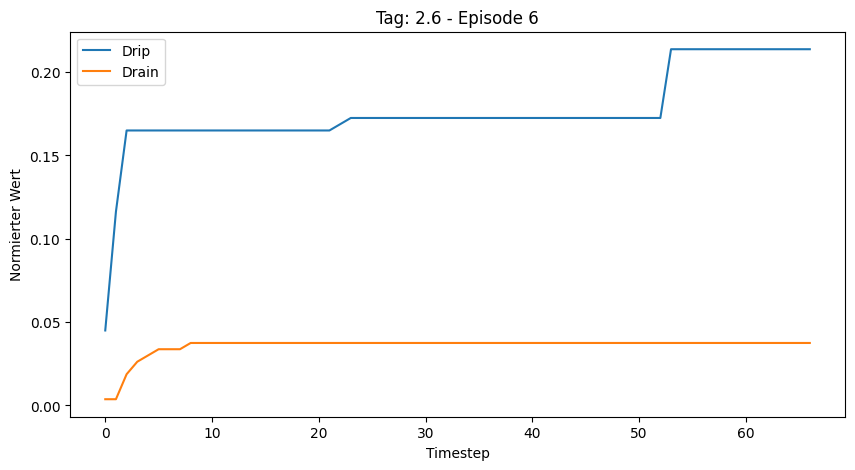

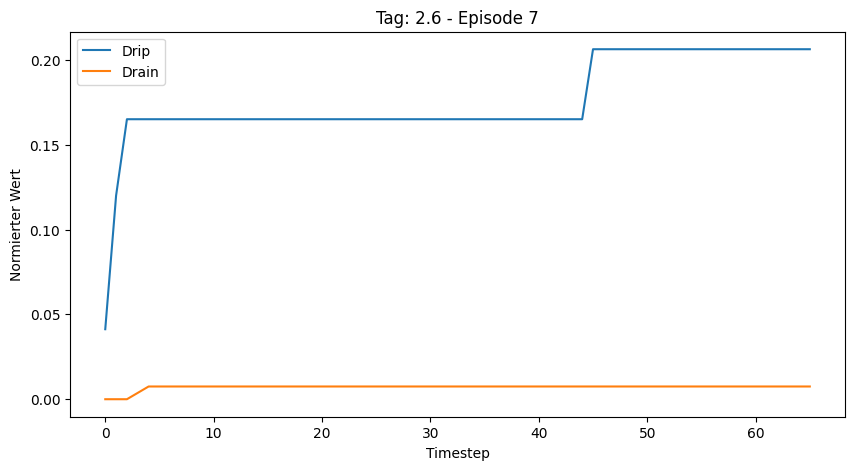

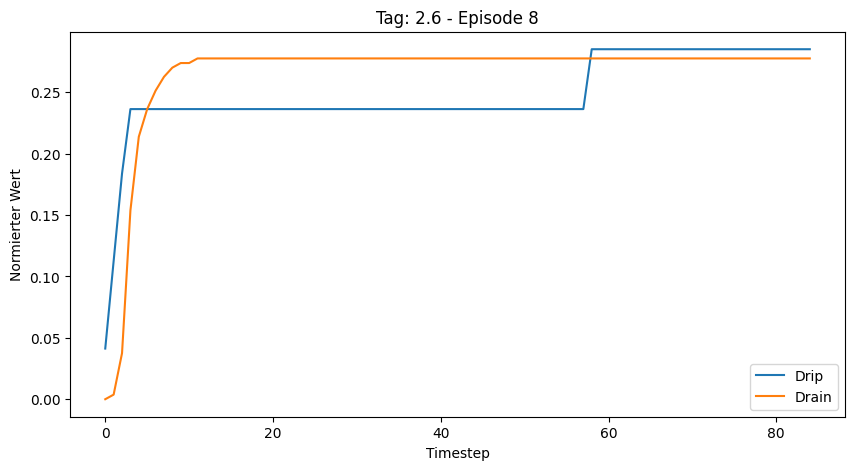

from(bucket: "SensorNodes")|> range(start: 2023-06-03T04:00:00+02:00, stop: 2023-06-03T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-03T04:00:00+02:00, stop: 2023-06-03T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-03T04:00:00+02:00, stop: 2023-06-03T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-03T04:00:00+02:00, stop: 2023-06-03T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-03T04:00:00+02:00, stop:

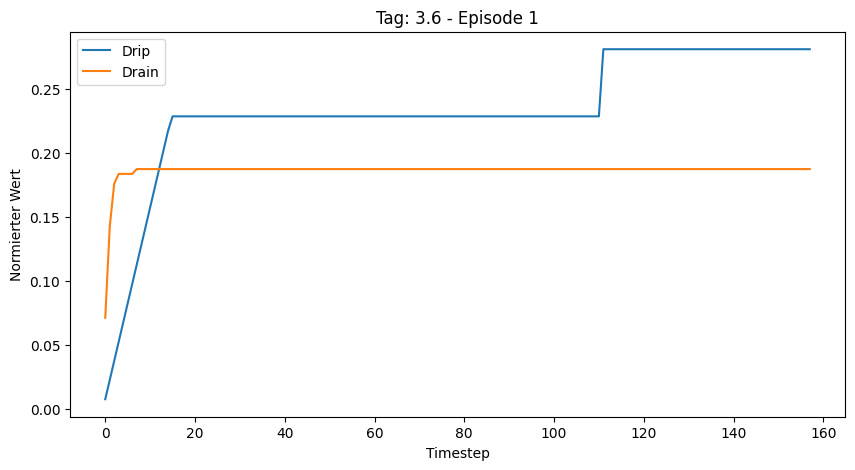

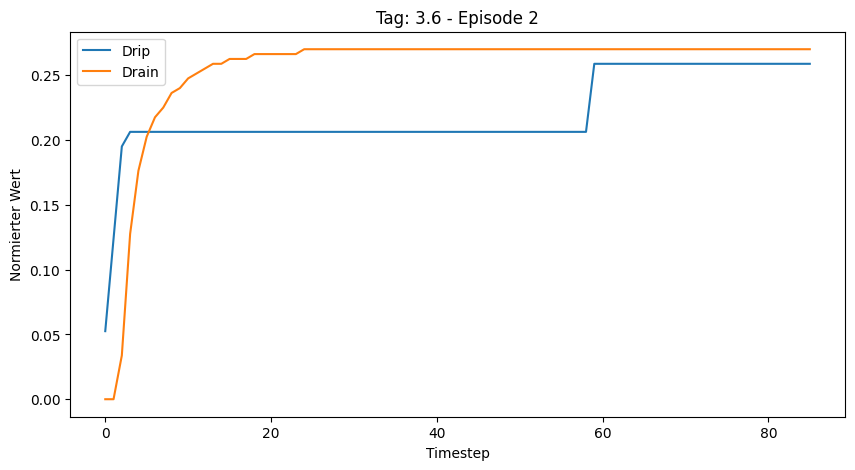

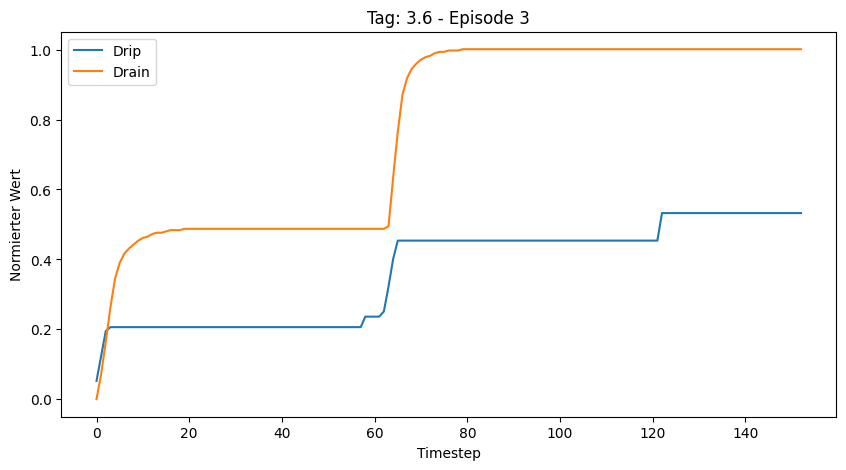

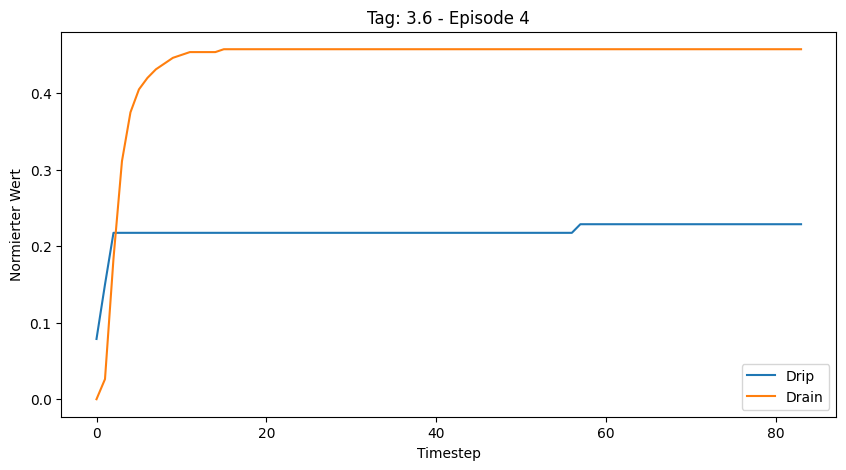

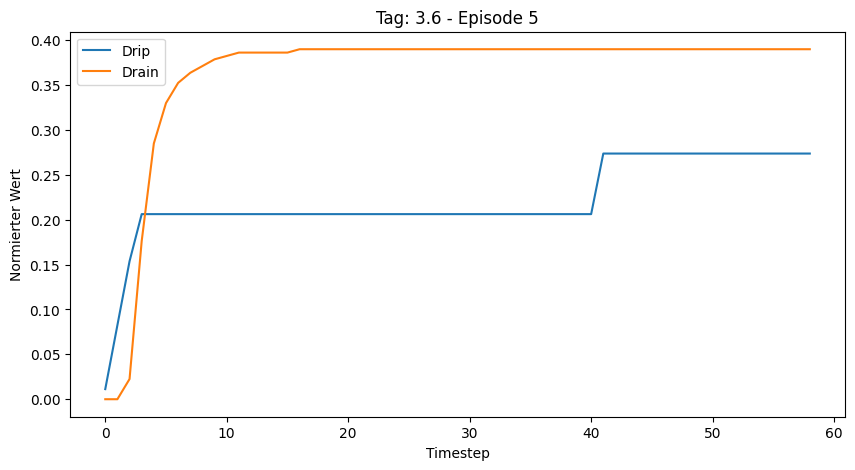

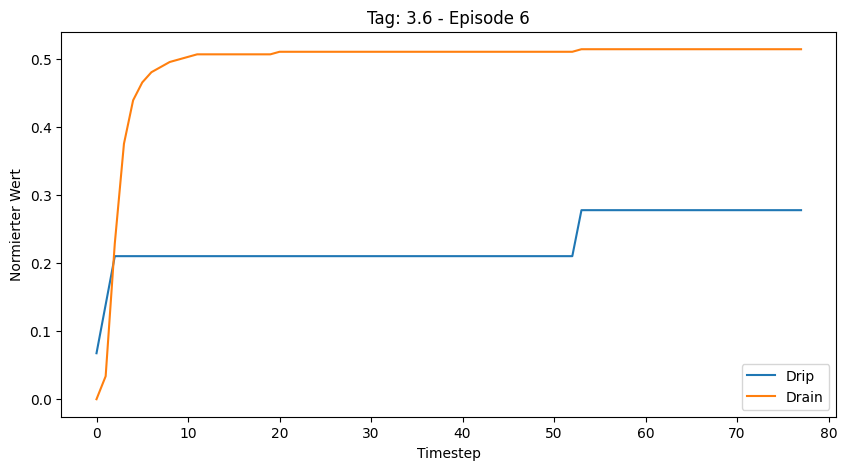

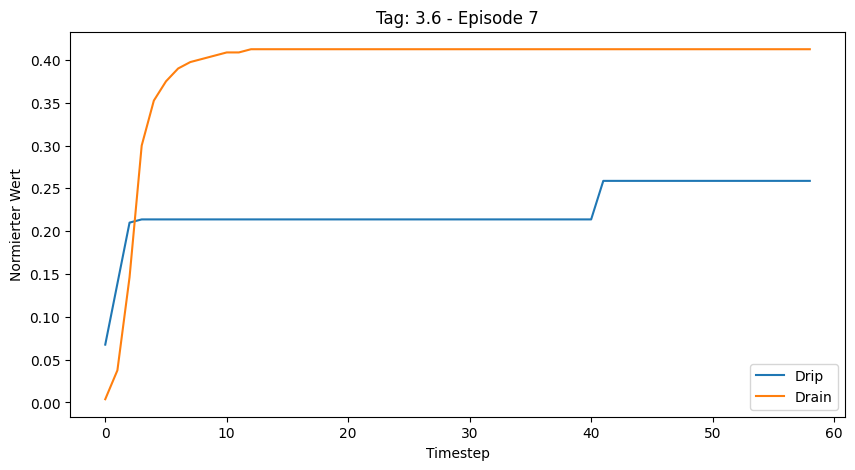

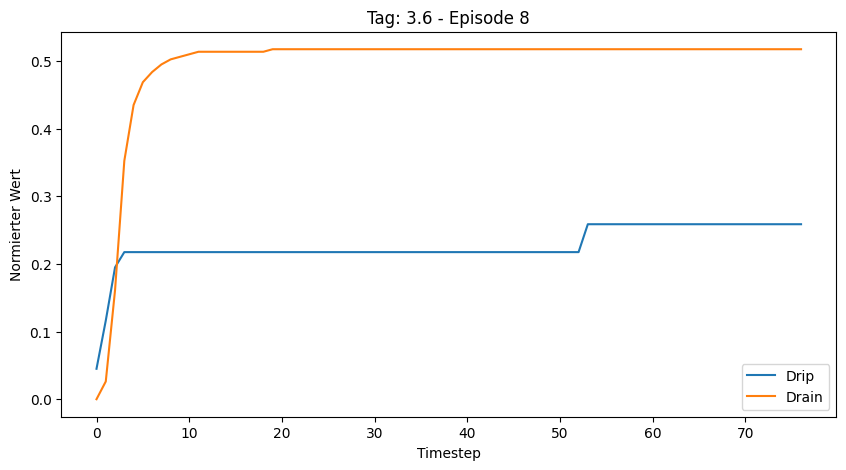

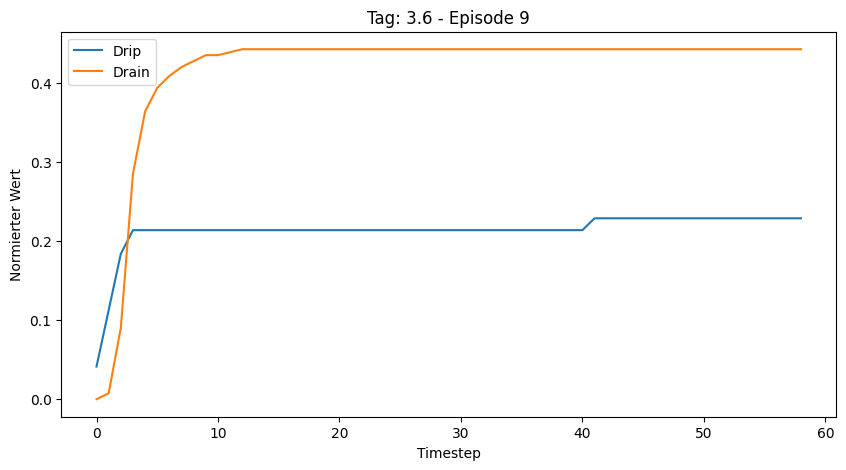

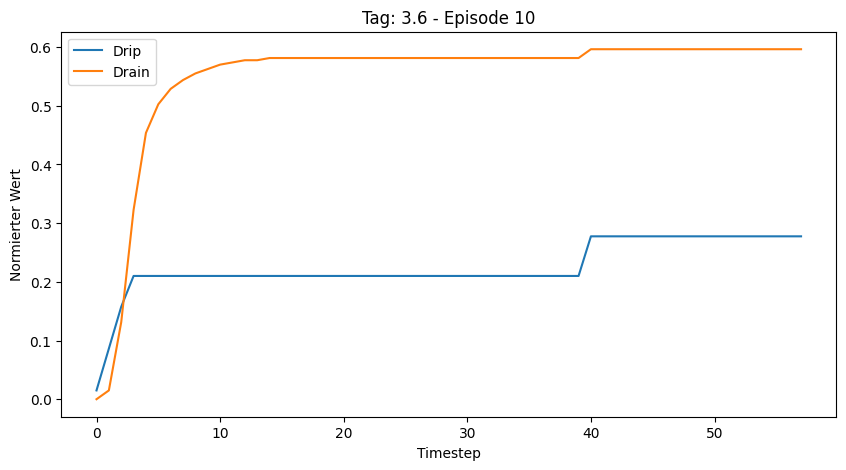

from(bucket: "SensorNodes")|> range(start: 2023-06-14T04:00:00+02:00, stop: 2023-06-14T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-14T04:00:00+02:00, stop: 2023-06-14T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-14T04:00:00+02:00, stop: 2023-06-14T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-14T04:00:00+02:00, stop: 2023-06-14T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-14T04:00:00+02:00, stop:

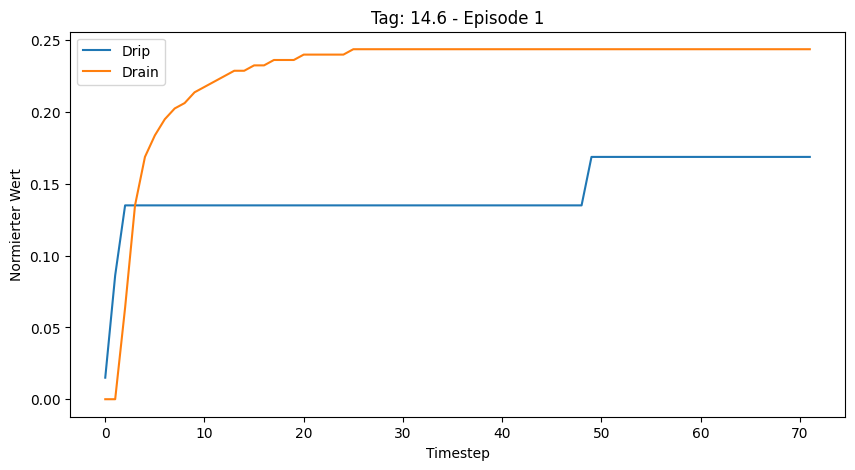

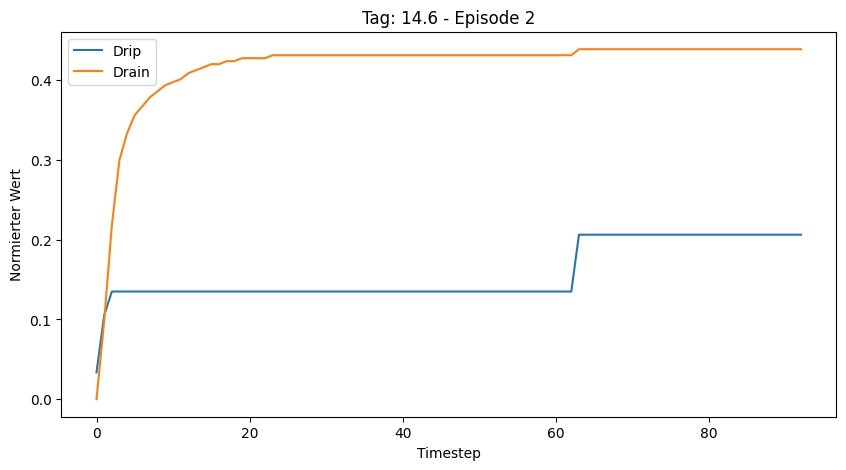

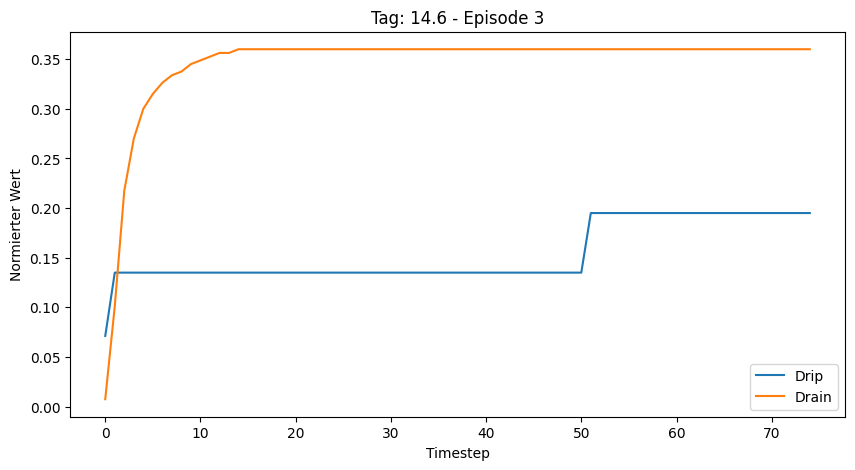

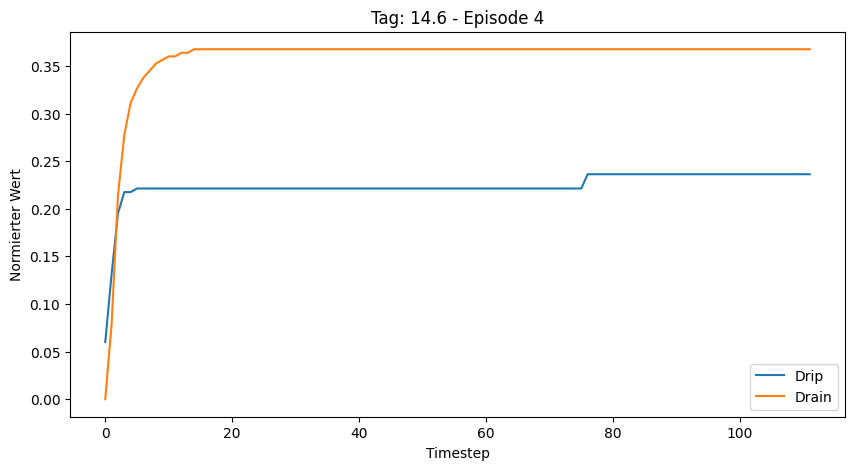

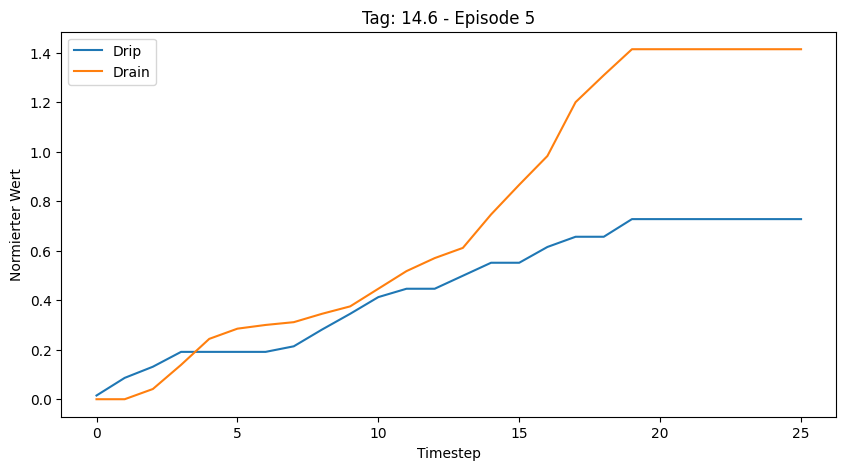

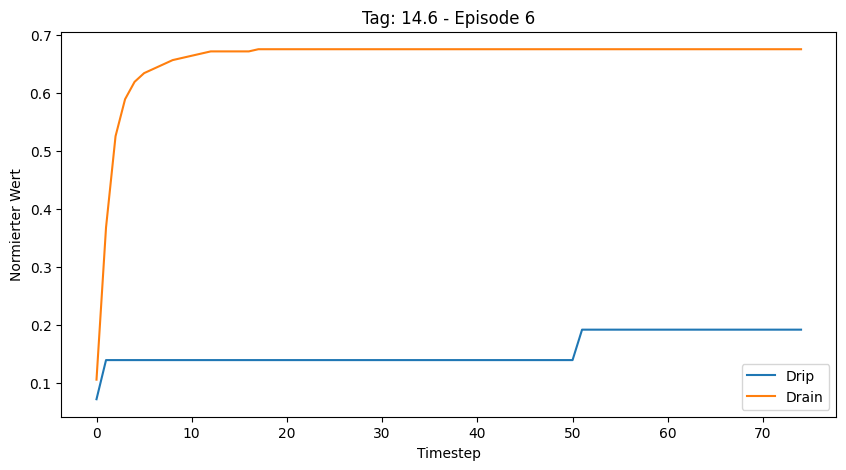

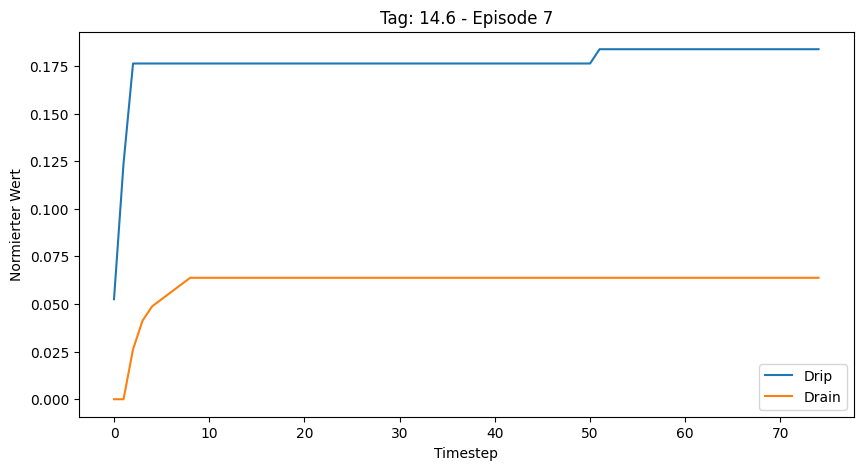

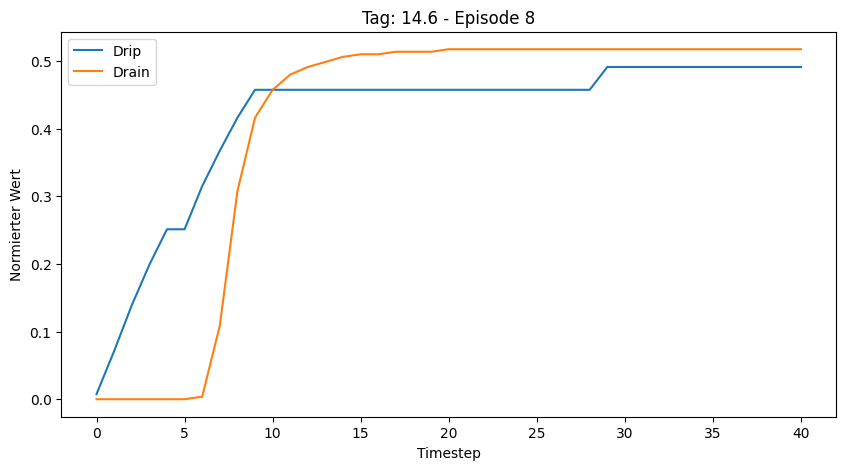

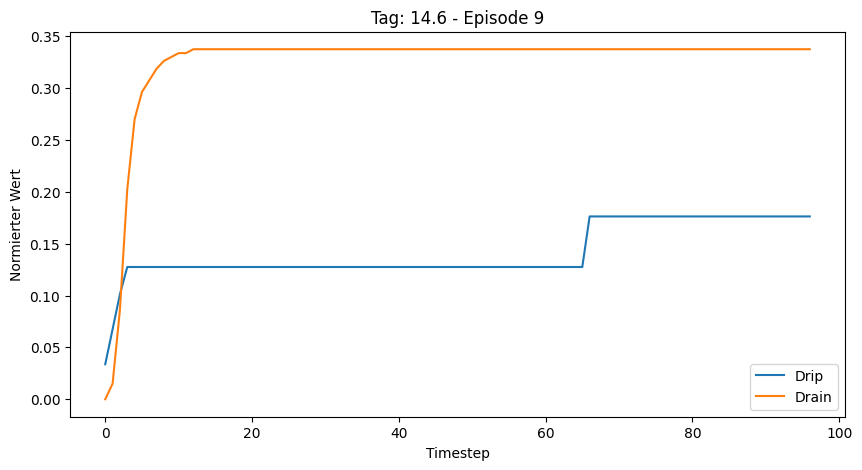

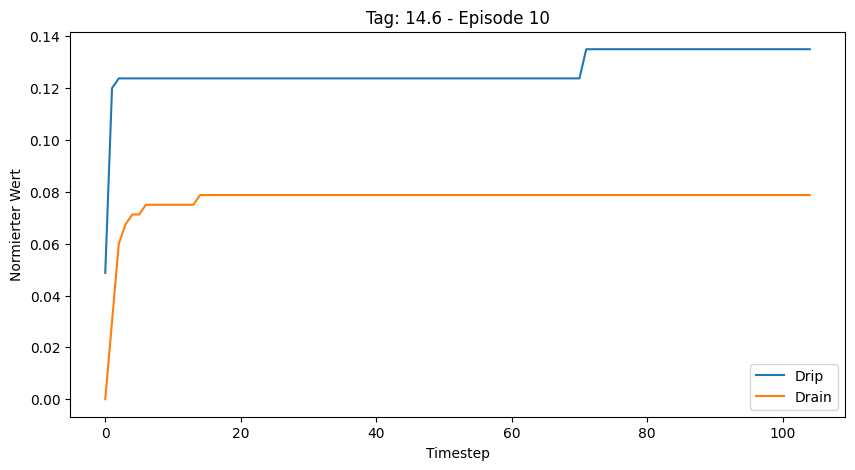

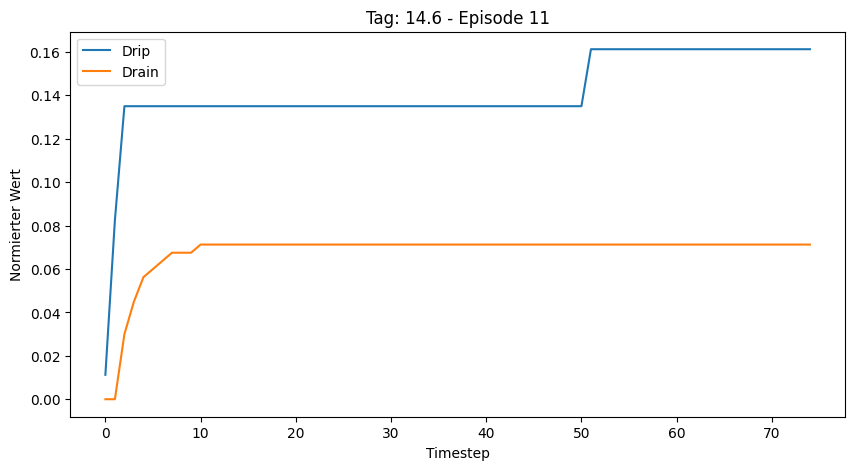

from(bucket: "SensorNodes")|> range(start: 2023-06-15T04:00:00+02:00, stop: 2023-06-15T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-15T04:00:00+02:00, stop: 2023-06-15T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-15T04:00:00+02:00, stop: 2023-06-15T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-15T04:00:00+02:00, stop: 2023-06-15T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-15T04:00:00+02:00, stop:

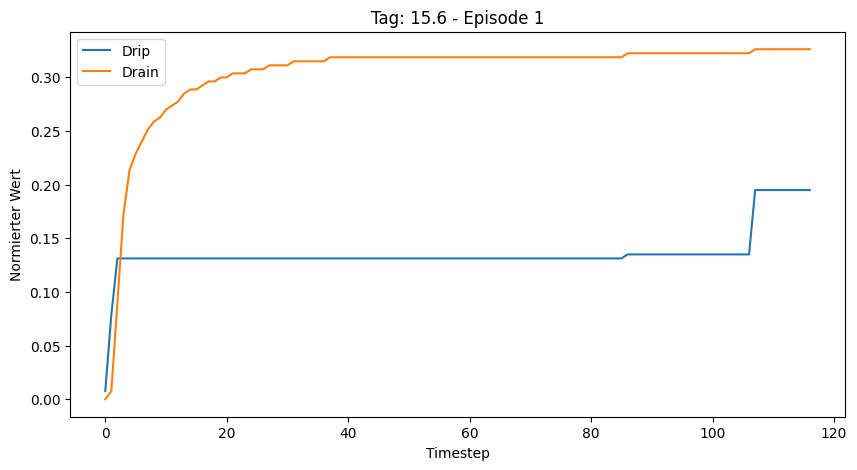

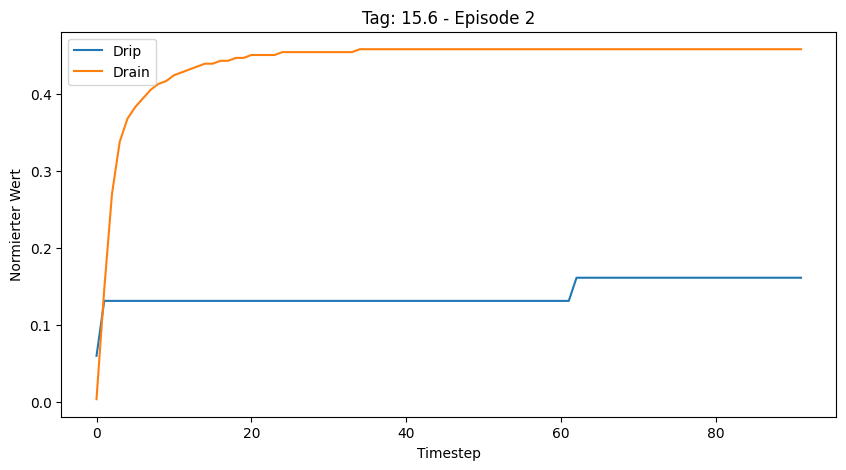

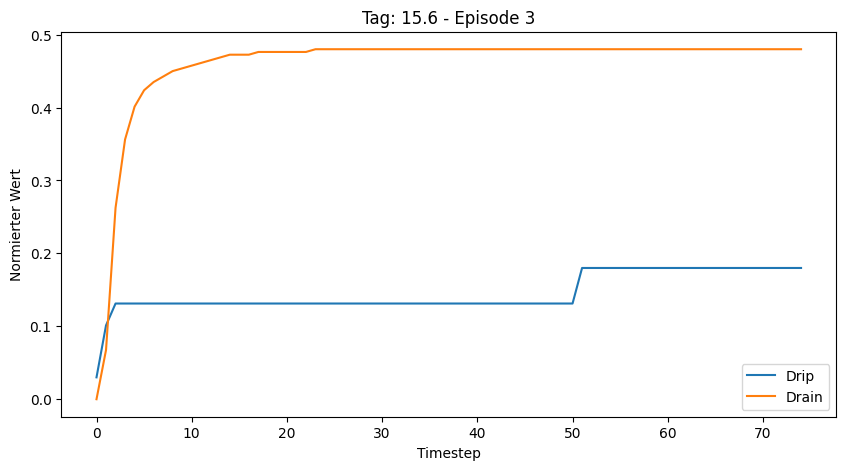

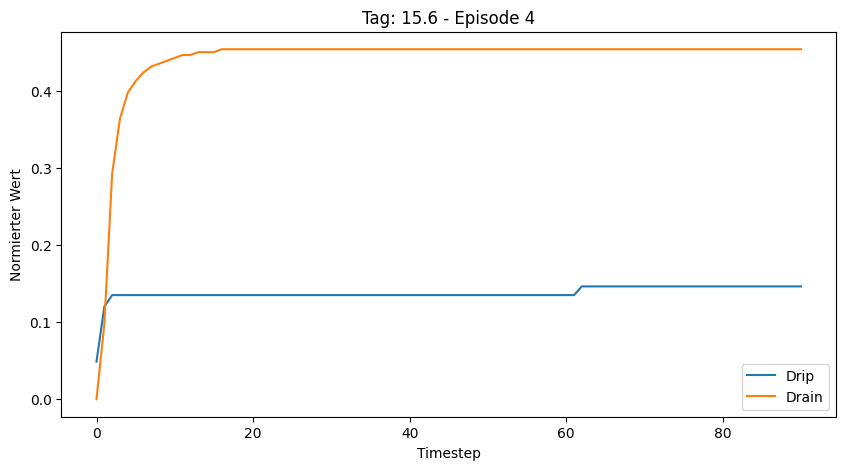

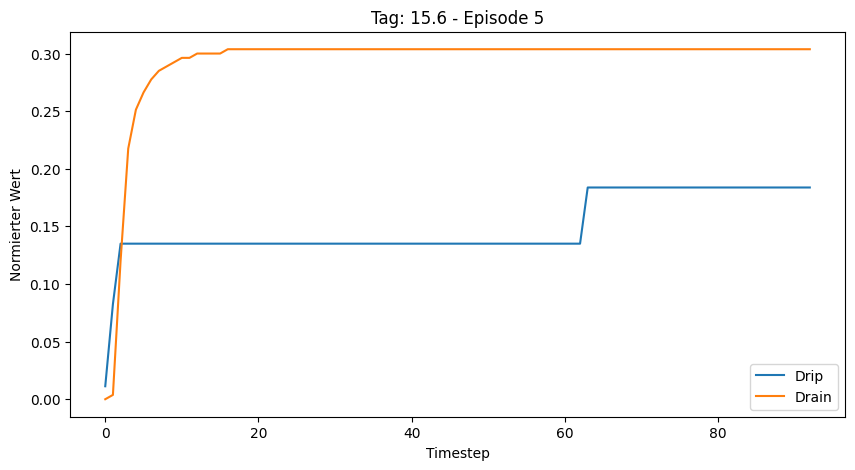

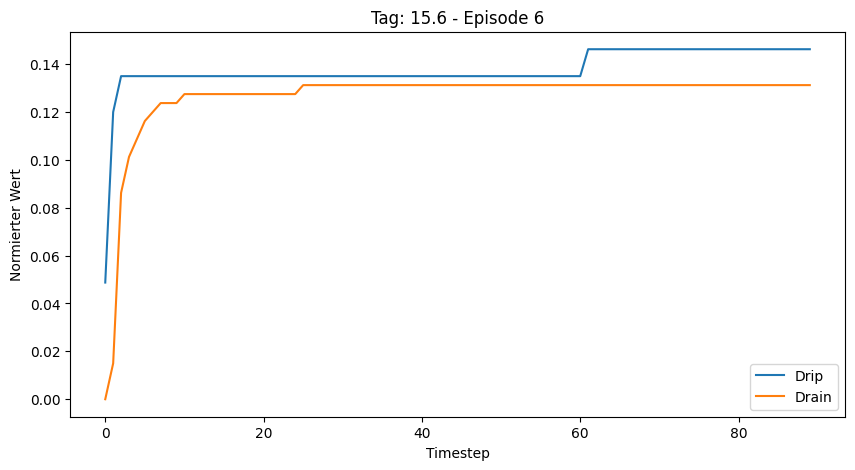

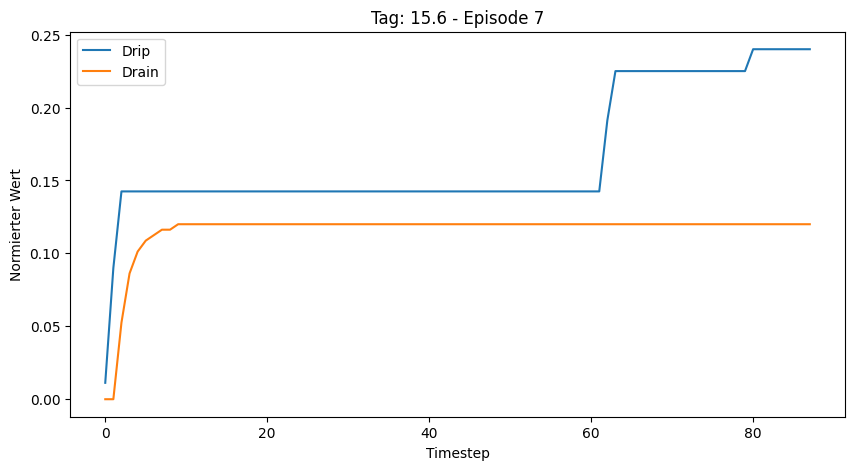

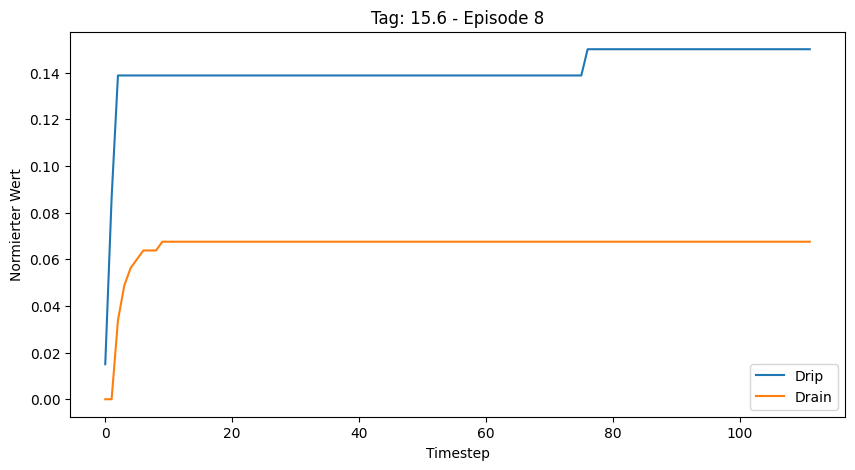

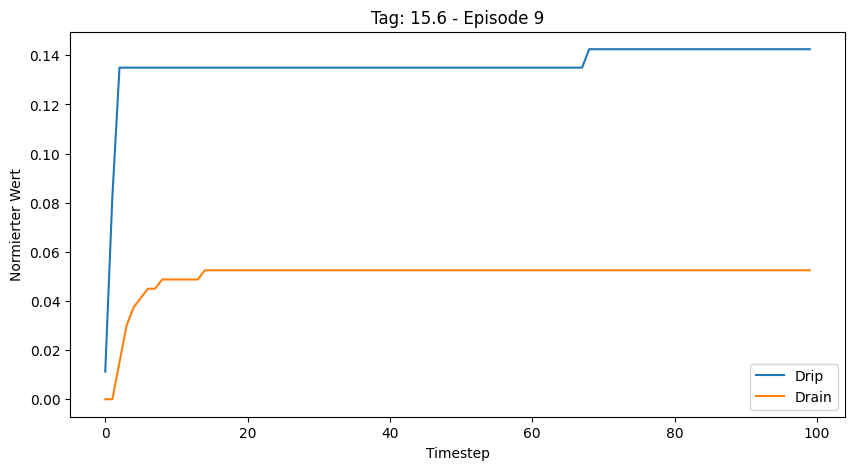

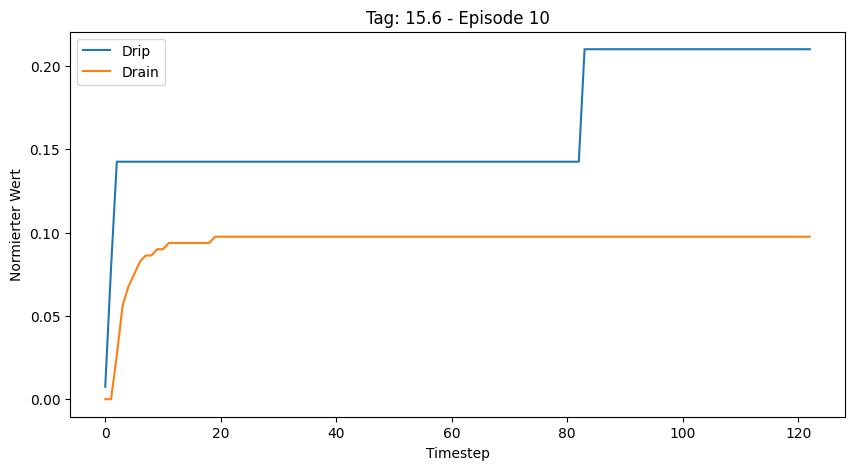

from(bucket: "SensorNodes")|> range(start: 2023-06-16T04:00:00+02:00, stop: 2023-06-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-16T04:00:00+02:00, stop: 2023-06-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-16T04:00:00+02:00, stop: 2023-06-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-16T04:00:00+02:00, stop: 2023-06-16T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-16T04:00:00+02:00, stop:

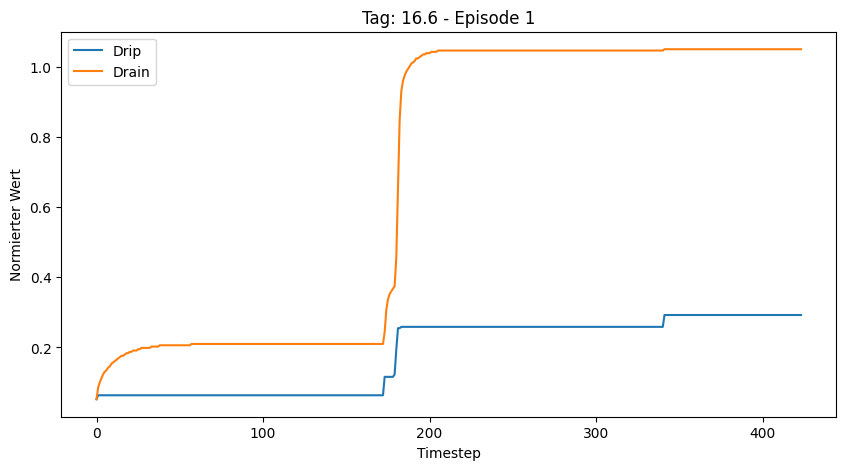

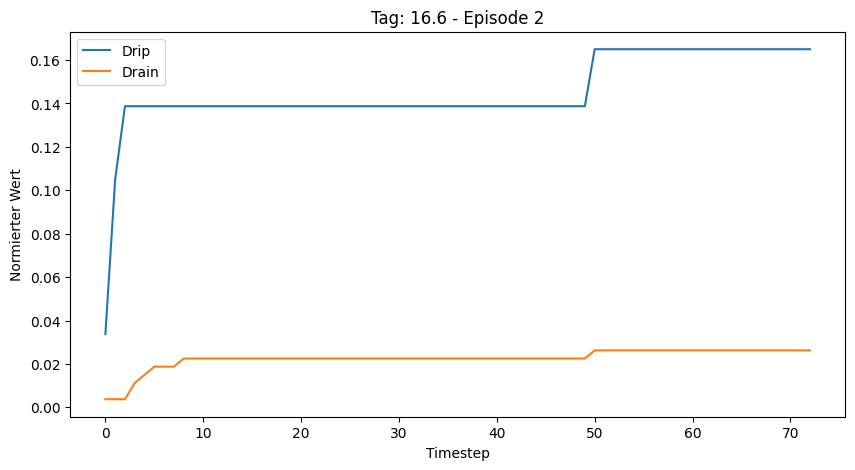

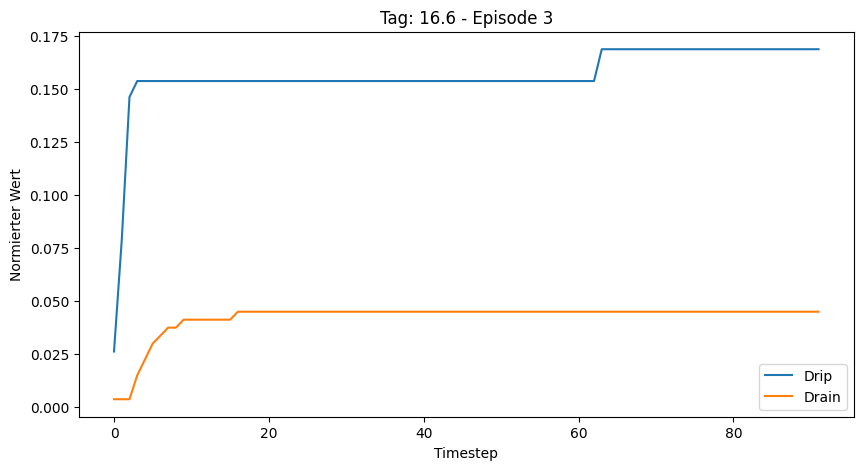

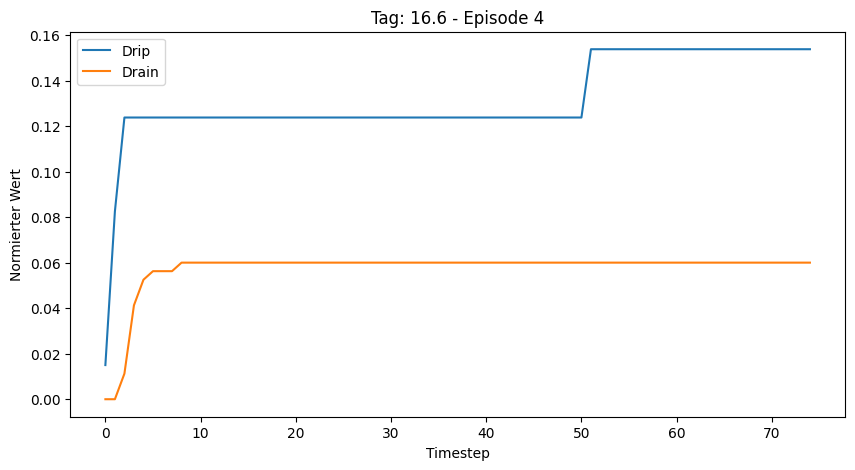

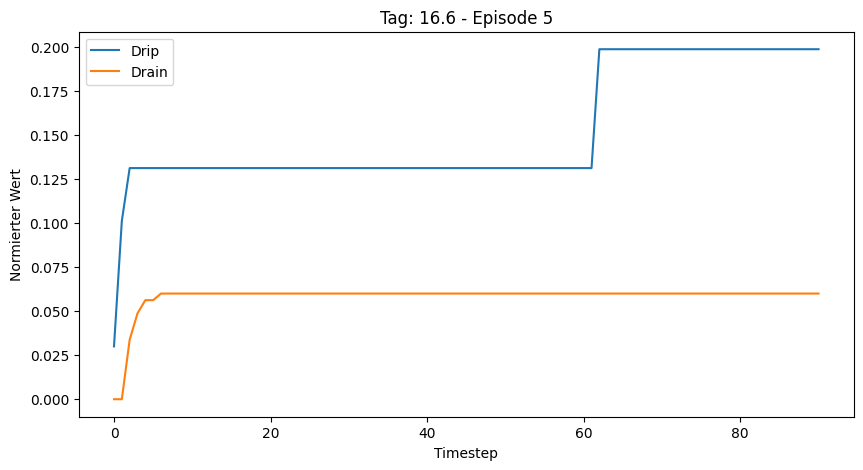

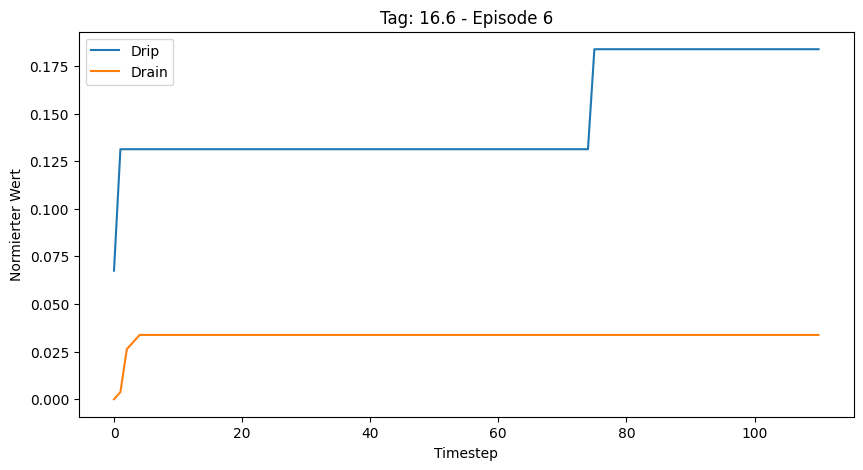

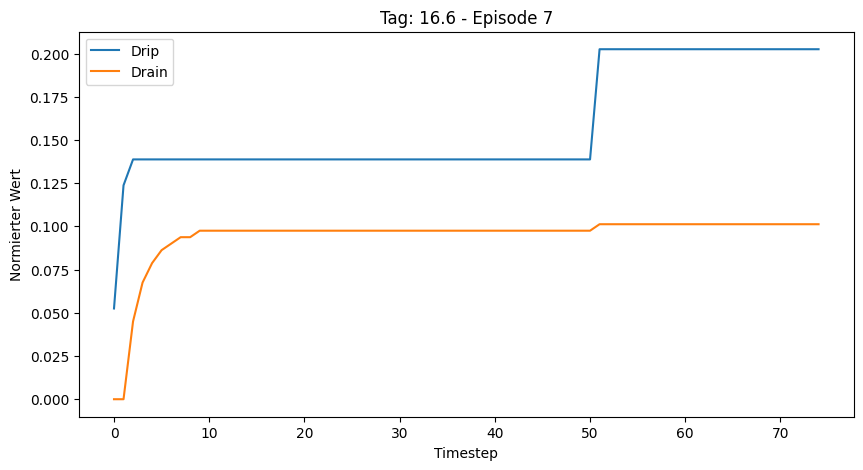

from(bucket: "SensorNodes")|> range(start: 2023-06-17T04:00:00+02:00, stop: 2023-06-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-17T04:00:00+02:00, stop: 2023-06-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-17T04:00:00+02:00, stop: 2023-06-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-17T04:00:00+02:00, stop: 2023-06-17T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-17T04:00:00+02:00, stop:

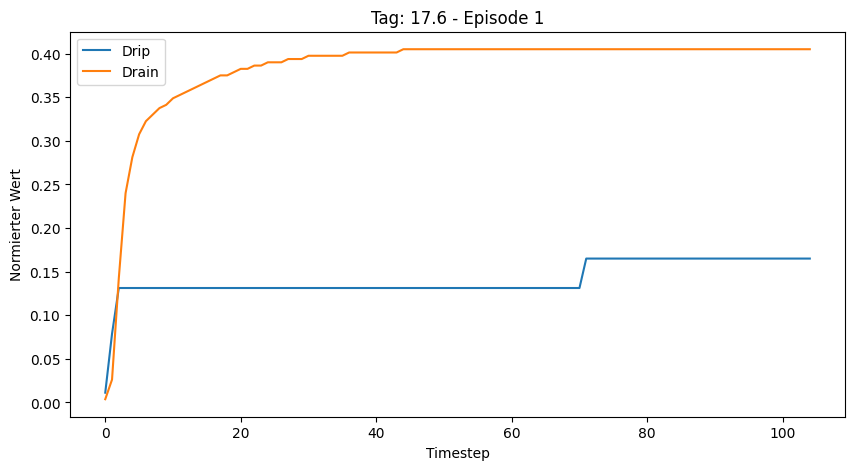

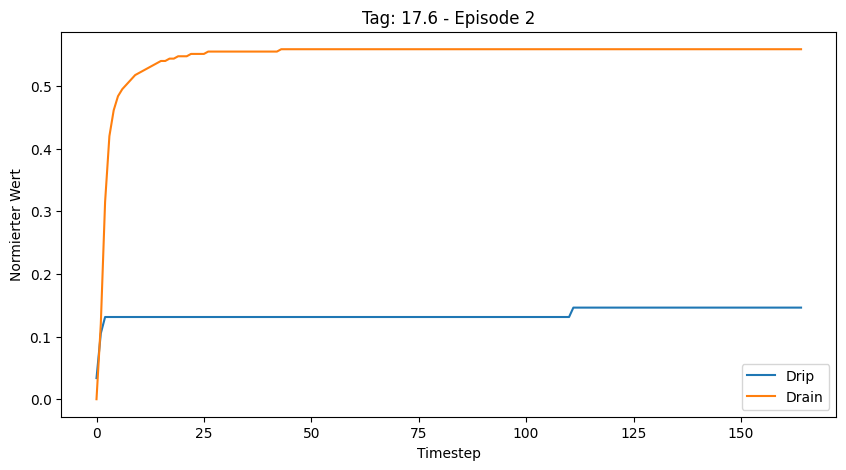

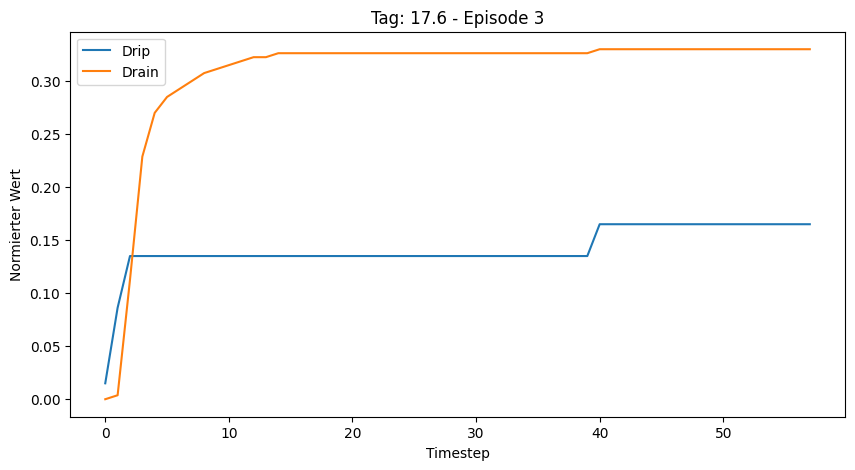

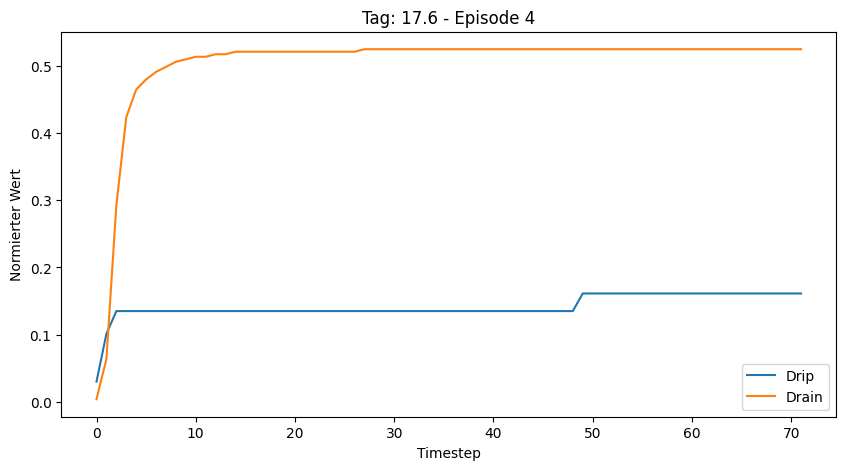

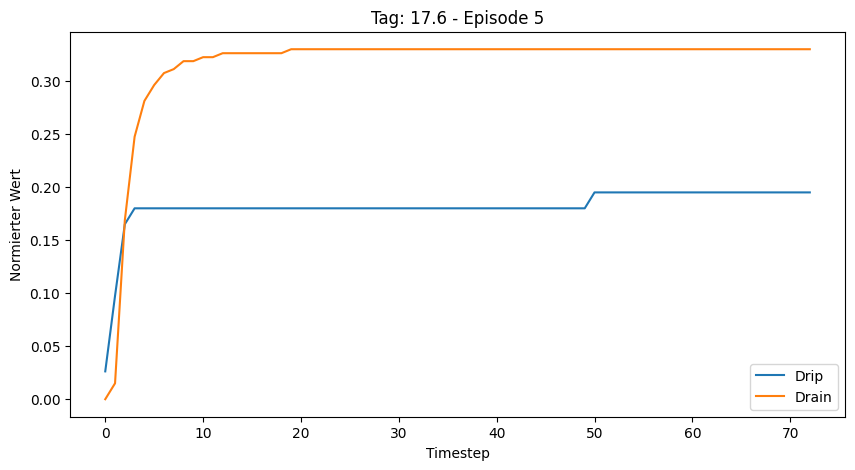

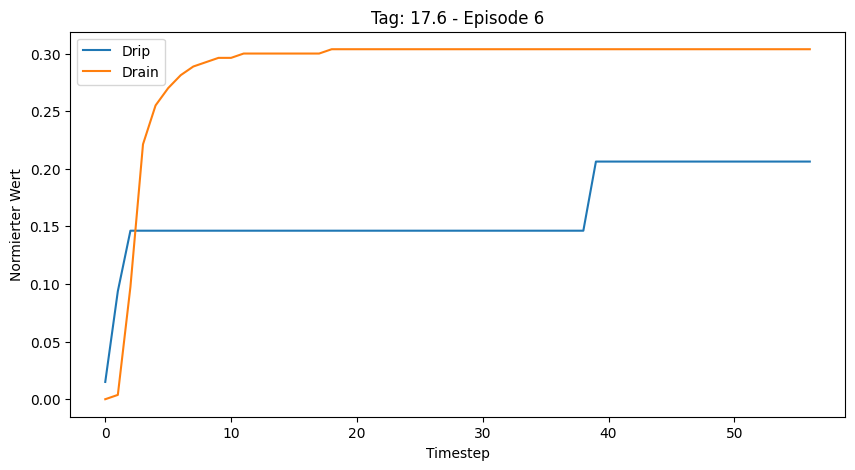

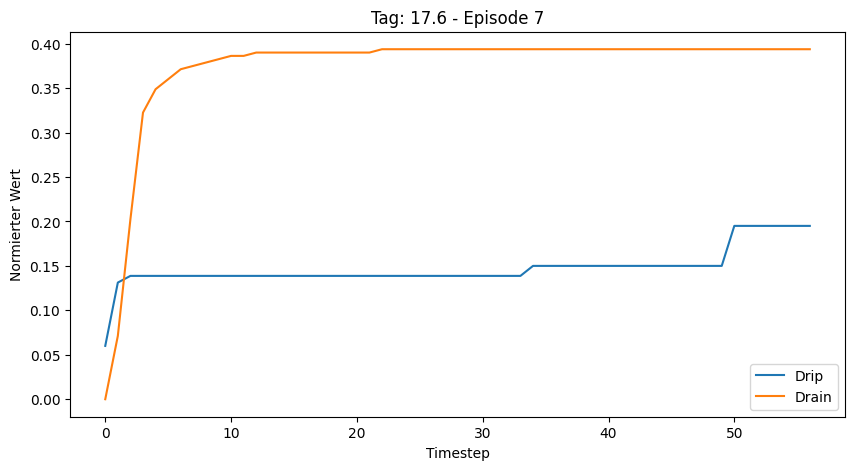

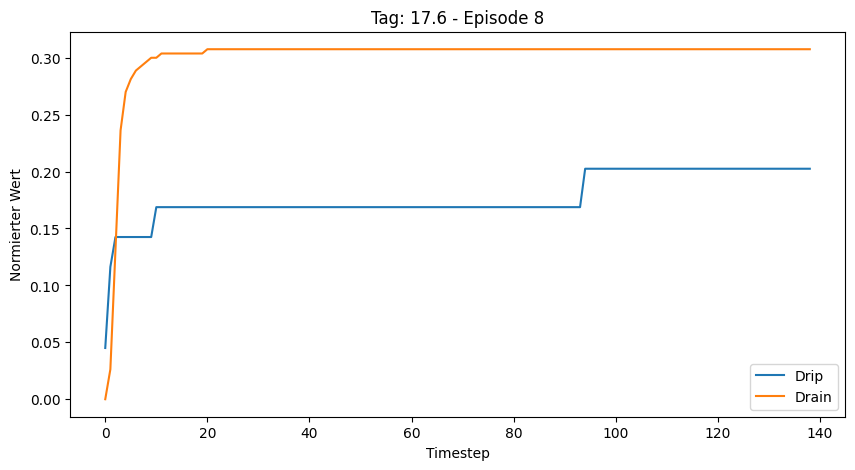

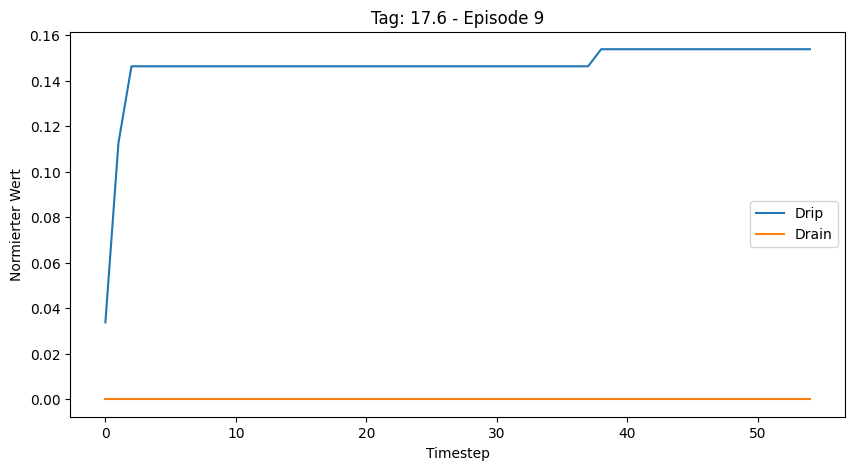

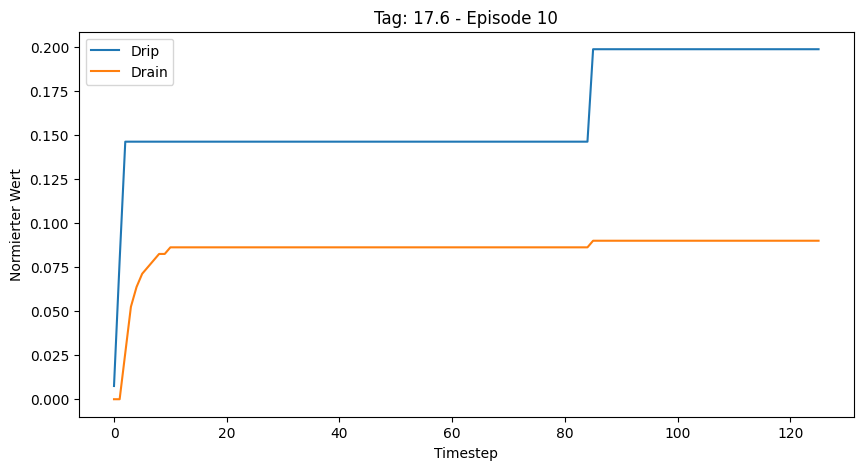

from(bucket: "SensorNodes")|> range(start: 2023-06-18T04:00:00+02:00, stop: 2023-06-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-18T04:00:00+02:00, stop: 2023-06-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-18T04:00:00+02:00, stop: 2023-06-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-18T04:00:00+02:00, stop: 2023-06-18T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-18T04:00:00+02:00, stop:

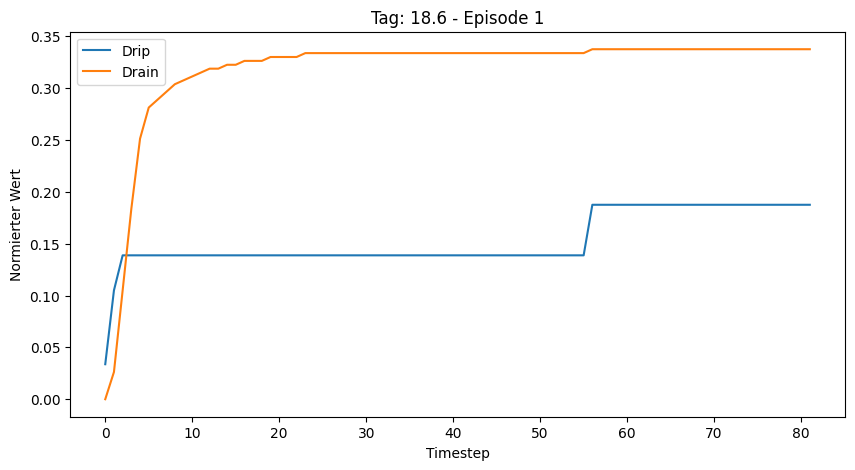

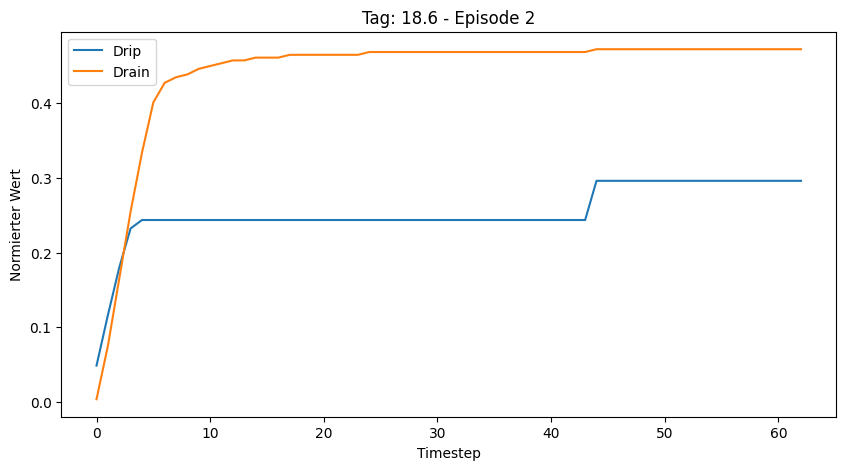

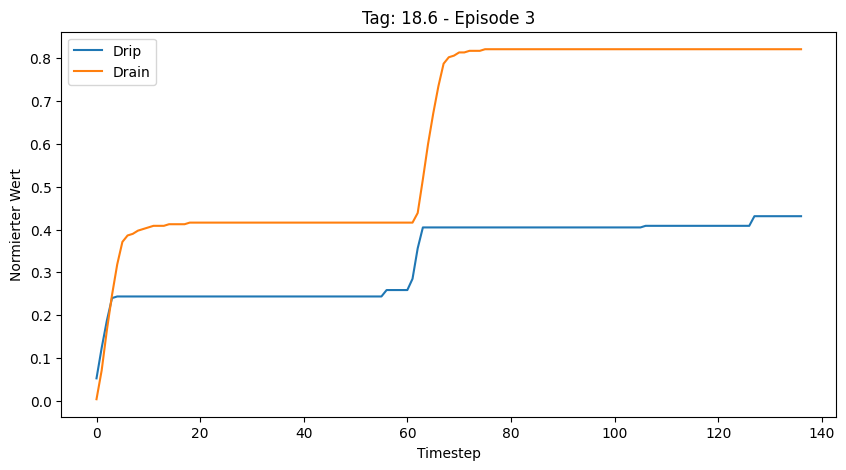

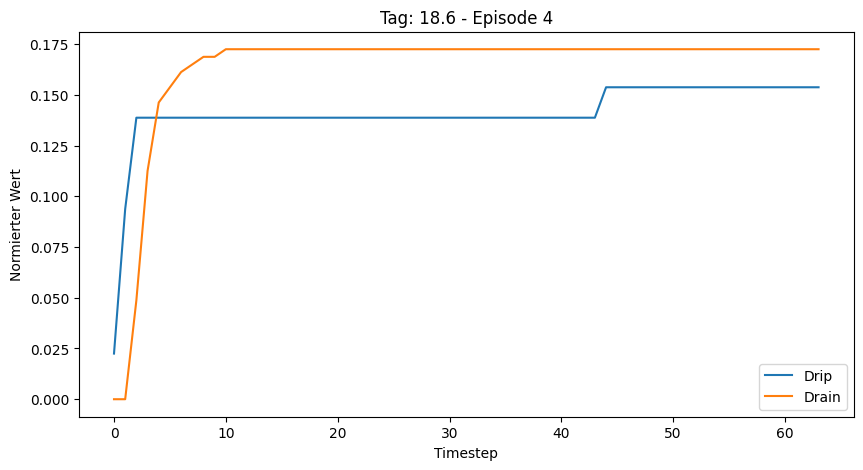

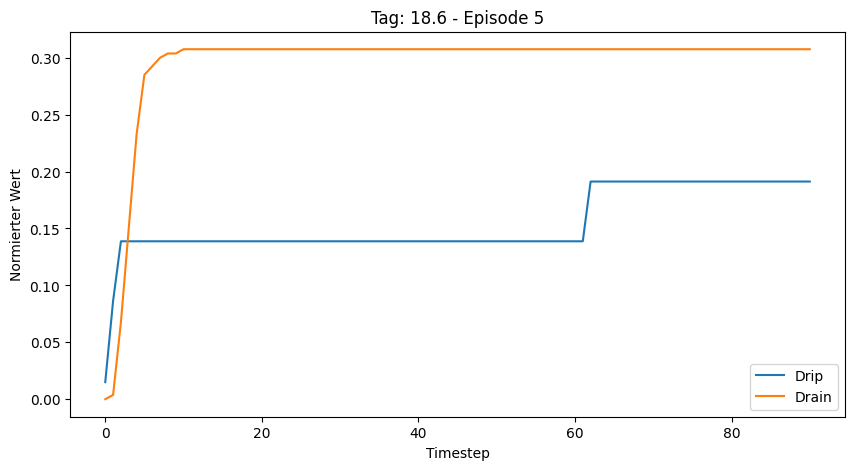

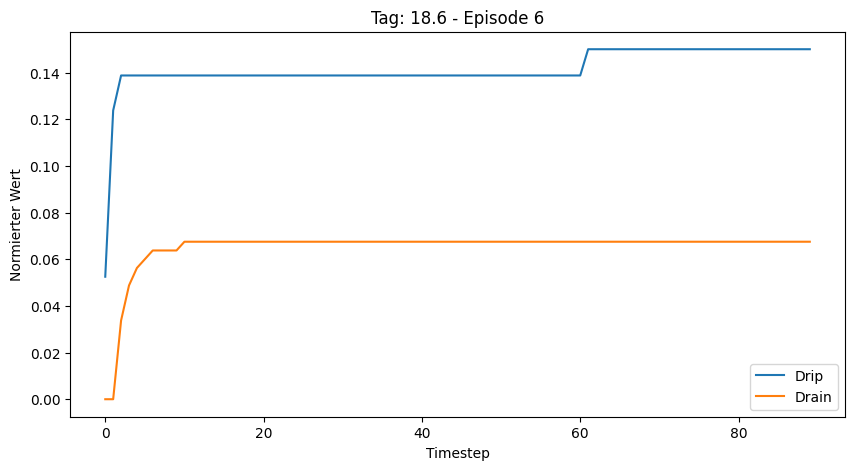

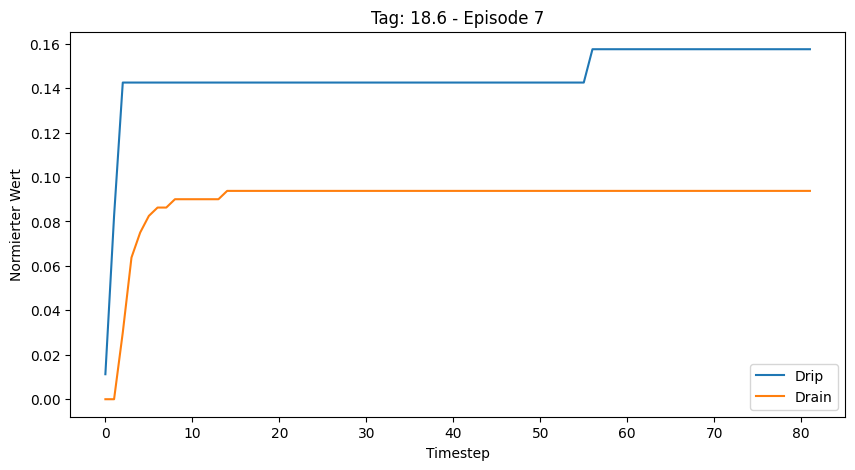

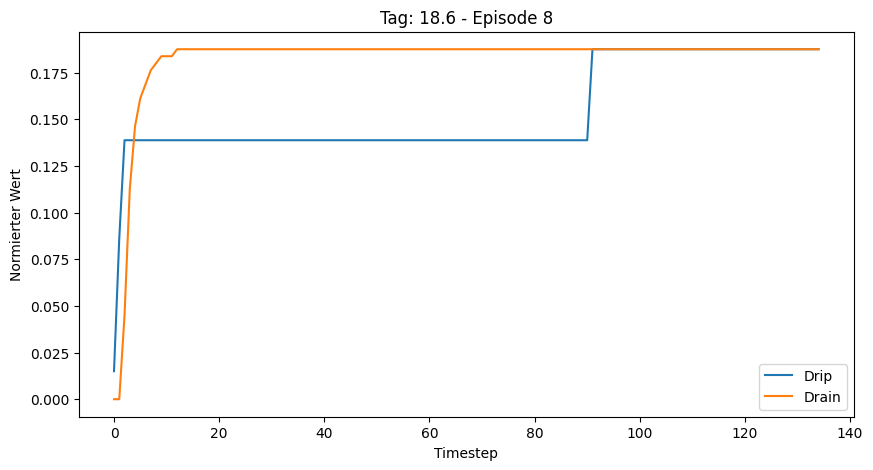

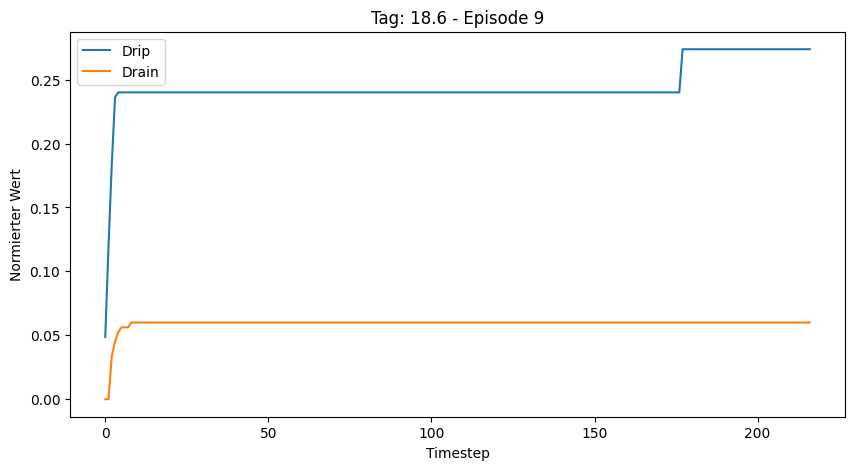

from(bucket: "SensorNodes")|> range(start: 2023-06-19T04:00:00+02:00, stop: 2023-06-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")
from(bucket: "SensorNodes")|> range(start: 2023-06-19T04:00:00+02:00, stop: 2023-06-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")
from(bucket: "SensorNodes")|> range(start: 2023-06-19T04:00:00+02:00, stop: 2023-06-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "humidity")
from(bucket: "SensorNodes")|> range(start: 2023-06-19T04:00:00+02:00, stop: 2023-06-19T23:00:00+02:00)|> filter(fn: (r) => r["_measurement"] == "70B3D57ED005C6D0")|> filter(fn: (r) => r["_field"] == "temperature")
from(bucket: "SensorNodes")|> range(start: 2023-06-19T04:00:00+02:00, stop:

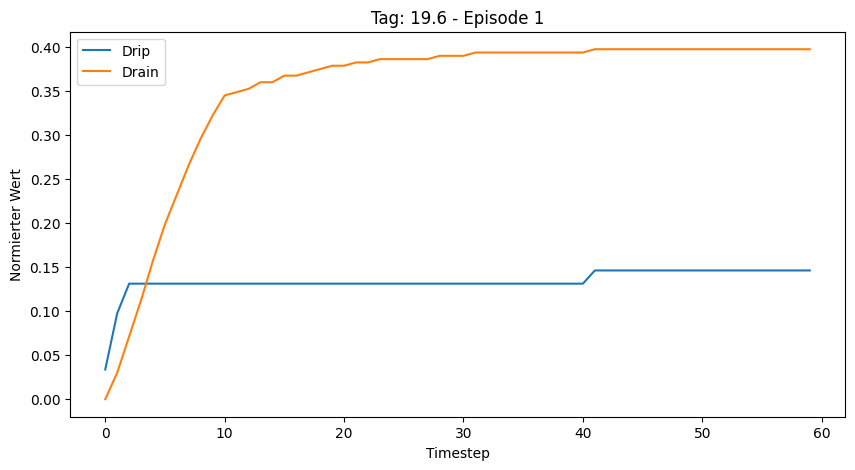

In [ ]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Ordner zum Speichern der Plots
output_dir = os.path.join("..", "plots", "episoden_d0")
os.makedirs(output_dir, exist_ok=True)

# Iteriere über alle Tage in dataD0
for month, day in dataD0:
    # Hole die Daten für den Tag
    dayData = get_data("70B3D57ED005C6D0", datetime(2023, month, day, 4), datetime(2023, month, day, 23))
    episoden = get_episodes_from_day(dayData)
    # Iteriere über alle Episoden des Tages
    for epi_idx, epi in enumerate(episoden):
        # Drip- und Drain-Werte extrahieren
        drip = [obs[6] for obs in epi]
        drain = [obs[2] for obs in epi]
        x = list(range(len(epi)))
        plt.figure(figsize=(10,5))
        plt.plot(x, drip, label="Drip")
        plt.plot(x, drain, label="Drain")
        plt.xlabel("Timestep")
        plt.ylabel("Normierter Wert")
        plt.title(f"Tag: {day}.{month} - Episode {epi_idx+1}")
        plt.legend()
        plt.show()